# Setup


## Types


In [ ]:
from enum import Enum
from typing import Protocol, List, Optional, Dict, Tuple, Any
from datetime import datetime
from dataclasses import dataclass

# Enums -----------------------------------------------------------

class AgentStatus(Enum):
    """Possible states of an agent."""
    IDLE = "IDLE"
    MOVING = "MOVING"
    WORKING = "WORKING"
    CHARGING = "CHARGING"
    ERROR = "ERROR"

class AgentType(Enum):
    """Types of agents in the warehouse."""
    PICKER = "PICKER"
    TRANSPORTER = "TRANSPORTER"

class NodeType(Enum):
    """Types of nodes in the warehouse."""
    ENTRY = "ENTRY"
    EXIT = "EXIT"
    NORMAL = "NORMAL"
    CENTER = "CENTER"

class TaskType(Enum):
    """Types of tasks in the warehouse."""
    PICK = "PICK"
    PLACE = "PLACE"
    MOVE = "MOVE"
    CHARGE = "CHARGE"

class TaskStatus(Enum):
    """Possible states of a task."""
    PENDING = "PENDING"
    IN_PROGRESS = "IN_PROGRESS"
    COMPLETED = "COMPLETED"
    FAILED = "FAILED"

# Interfaces -----------------------------------------------------------

class INode(Protocol):
    """Protocol defining the interface for a Node."""
    hash: str
    x: float
    y: float
    neighbours: Dict['INode', float]
    heuristic: float
    type: NodeType
    locked: bool
    is_goal: bool

class ITask(Protocol):
    """Protocol defining the interface for a Task."""
    hash_id: str
    initial_state: str
    goal_state: str
    job: TaskType
    priority: int

class IAgent(Protocol):
    """Interface for agent objects."""
    agent_id: int
    node: 'NodeType'
    weight: float
    status: AgentStatus
    goal_state: str
    mixer: Optional['IMixer']
    path: List['NodeType']
    battery: float
    agent_type: AgentType
    hash_id: str

class IMixer(Protocol):
    """Interface for mixer objects."""
    warehouse: 'IWarehouse'
    tasks: List['TaskType']
    priority_tasks: List['TaskType']
    agents: Dict[str, IAgent]
    logs: List[str]
    log_file: str

    def log_event(self, event_type: str, message: str, agent: Optional[IAgent] = None, task: Optional['Task'] = None) -> None:
        """Logs an event in the system."""
        pass

class IWarehouse(Protocol):
    """Interface for warehouse objects."""
    name: str
    location: str
    width: float
    length: float
    height: float
    racks: List['Rack']
    shelves: List['Shelf']
    items: Dict[str, 'ItemInformation']
    transactions: List['Transaction']

# Data Models -----------------------------------------------------------

@dataclass
class ItemInformation:
    """Data model for storing item information in the warehouse system."""
    item_id: str  # PK
    name: str
    category: str
    box_weight: float
    box_height: float
    box_price: float
    expiry: Optional[datetime]
    counter: int = 0

@dataclass
class ItemShelf:
    """Data model for mapping items to shelves in the warehouse."""
    item_id: str  # FK
    shelf_id: str  # FK
    order_in_shelf: int
    addition_date: datetime
    accessible_nodes: List[str]
    finale: bool = False

@dataclass
class Rack:
    """Data model for storage racks in the warehouse."""
    rack_id: str  # PK
    is_frozen: bool
    current_capacity: float
    start_coords: Tuple[float, float]  # [x,y]
    center_coords: Tuple[float, float]  # [x,y]
    end_coords: Tuple[float, float]    # [x,y]

@dataclass
class Shelf:
    """Data model for shelves within racks."""
    shelf_id: str  # PK
    rack_id: str   # FK -> Rack
    z_level: float
    current_weight: float
    is_locked: bool = False

@dataclass
class Transaction:
    """Data model for warehouse transactions."""
    transaction_id: str  # PK
    transaction_type: str
    item_id: str  # FK -> ItemInformation
    quantity: int
    date: datetime

@dataclass
class FactsTable:
    """Data model for warehouse configuration and constraints."""
    name: str
    location: str
    warehouse_width: float
    warehouse_length: float
    warehouse_height: float
    n_racks: int
    n_shelfs_per_rack: int
    shelfs_max_height: List[float]  # [z1,z2..]
    shelf_max_width: float
    item_length: float

    warehouse_height: float
    n_racks: int
    n_shelfs_per_rack: int
    shelfs_max_height: List[float]  # [z1,z2..]
    shelf_max_width: float
    item_length: float

## Task


In [ ]:
from typing import Optional
import uuid

class Task(ITask):
    """Represents a task to be performed by an agent within the warehouse environment.
    
    Attributes:
        hash_id (str): Unique identifier for the task
        initial_state (str): Starting state/location of the task
        goal_state (str): Target state/location for the task
        job (TaskType): Type of job to be performed
        priority (int): Priority level of the task (0 = normal, 1 = high)
    """

    def __init__(self, goal_state: str, job: TaskType, priority: int = 0, initial_state: str = "", hash_id: Optional[str] = None):
        """Initializes a Task instance.

        Args:
            goal_state (str): Description or identifier of the target state/location for the task.
            job (TaskType): The type of job to be performed
            priority (int, optional): The priority level of the task (0 = normal, 1 = high)
            initial_state (str, optional): Description or identifier of the starting state/location
            hash_id (Optional[str], optional): A unique identifier (Primary Key) for the task

        Raises:
            ValueError: If goal_state or job is empty, or if priority is negative
        """
        if not goal_state:
            raise ValueError("Goal state cannot be empty")
        if not job:
            raise ValueError("Job type cannot be empty")
        if priority < 0:
            raise ValueError("Priority cannot be negative")

        self.hash_id: str = hash_id if hash_id is not None else str(uuid.uuid4())
        self.initial_state: str = initial_state
        self.goal_state: str = goal_state
        self.job: TaskType = job
        self.priority: int = priority

    def __str__(self) -> str:
        """Return a string representation of the task.
        
        Returns:
            str: A human-readable string representation of the task
        """
        return f"Task(Job='{self.job.name}', Goal='{self.goal_state}', Priority={self.priority}, ID='{self.hash_id}')"

    def __repr__(self) -> str:
        """Return a detailed string representation for debugging.
        
        Returns:
            str: A detailed string representation of the task
        """
        return (f"Task(hash_id='{self.hash_id}', initial_state='{self.initial_state}', "
                f"goal_state='{self.goal_state}', job='{self.job.name}', priority={self.priority})")

    def __eq__(self, other: object) -> bool:
        """Check if two tasks are equal based on their unique hash_id.
        
        Args:
            other (object): The object to compare with
            
        Returns:
            bool: True if the tasks are equal, False otherwise
        """
        if not isinstance(other, Task):
            return NotImplemented
        return self.hash_id == other.hash_id

    def __hash__(self) -> int:
        """Return a hash based on the task's unique hash_id.
        
        Returns:
            int: A hash value computed from the task's hash_id
        """
        return hash(self.hash_id)

## Nodes


In [ ]:
from typing import Dict, Optional, List
from enum import Enum, auto
from dataclasses import dataclass, field

@dataclass
class Node:
    """Represents a node in the warehouse grid.
    
    Attributes:
        x (int): X coordinate
        y (int): Y coordinate
        node_type (NodeType): Type of the node
        name (str): Name of the node (e.g., "A1", "B2")
        neighbours (Dict[Node, float]): Dictionary of neighboring nodes and their distances
        locked_by (Optional[str]): ID of the agent that has locked this node
    """
    x: int
    y: int
    node_type: NodeType
    name: str
    neighbours: Dict['Node', float] = field(default_factory=dict)
    locked_by: Optional[str] = None
    locked: bool = False
    is_goal: bool = False

    def add_neighbor(self, node: 'Node', distance: float = 1.0) -> None:
        """Adds a neighboring node with the given distance."""
        self.neighbours[node] = distance
        node.neighbours[self] = distance

    def is_locked(self) -> bool:
        """Returns whether the node is currently locked by an agent."""
        return self.locked

    def lock(self, agent_id: str) -> bool:
        """Attempts to lock the node for an agent.
        
        Args:
            agent_id (str): ID of the agent attempting to lock the node
            
        Returns:
            bool: True if the node was successfully locked, False otherwise
        """
        if not self.is_locked():
            self.locked = True
            self.locked_by = agent_id
            return True
        return False

    def unlock(self, agent_id: str) -> bool:
        """Attempts to unlock the node for an agent.
        
        Args:
            agent_id (str): ID of the agent attempting to unlock the node
            
        Returns:
            bool: True if the node was successfully unlocked, False otherwise
        """
        if self.locked and self.locked_by == agent_id:
            self.locked = False
            self.locked_by = None
            return True
        return False

    def __hash__(self) -> int:
        """Returns a hash value for the node."""
        return hash((self.x, self.y))

    def __eq__(self, other: object) -> bool:
        """Checks if two nodes are equal."""
        if not isinstance(other, Node):
            return False
        return self.x == other.x and self.y == other.y

    def __str__(self) -> str:
        """Returns a string representation of the node."""
        return f"{self.name} ({self.x}, {self.y})"

    def get_locking_agent(self) -> Optional[str]:
        """Gets the agent that currently has the node locked.

        Returns:
            Optional[str]: The agent that locked the node, or None if the node is not locked
        """
        return self.locked_by

    def set_type(self, node_type: NodeType) -> None:
        """Sets the type of the node.

        Args:
            node_type (NodeType): The new type for the node
        """
        self.node_type = node_type

    def set_goal(self, is_goal: bool = True) -> None:
        """Sets whether this node is a goal node.

        Args:
            is_goal (bool, optional): Whether this is a goal node. Defaults to True.
        """
        self.is_goal = is_goal


## Warehouse


In [ ]:
from typing import Dict, Optional, List, TYPE_CHECKING
from math import sqrt
from dataclasses import dataclass, field
import uuid
import json
import os

if TYPE_CHECKING:
    from backend.core.agent import Agent

@dataclass
class Warehouse:
    """Represents the warehouse environment.
    
    Attributes:
        facts (FactsTable): Warehouse configuration and facts
        nodes (Dict[str, Node]): All nodes in the warehouse, keyed by node name
        racks (Dict[str, Rack]): All racks in the warehouse, keyed by rack ID
        shelves (Dict[str, Shelf]): All shelves in the warehouse, keyed by shelf ID
        agents (Dict[str, Agent]): All agents in the warehouse
        tasks (List[Task]): All tasks in the warehouse
        goal (Optional[Node]): Current goal node for pathfinding
    """
    facts: FactsTable
    nodes: Dict[str, Node] = field(default_factory=dict)
    racks: Dict[str, Rack] = field(default_factory=dict)
    shelves: Dict[str, Shelf] = field(default_factory=dict)
    agents: Dict[str, 'Agent'] = field(default_factory=dict)
    tasks: List[Task] = field(default_factory=list)
    goal: Optional[Node] = None
    
    @classmethod
    def create_default(cls) -> 'Warehouse':
        """Creates a default warehouse configuration for testing/example purposes."""
        # Create facts table
        facts = FactsTable(
            name="Example Warehouse",
            location="Test Location",
            warehouse_width=20.0,
            warehouse_length=30.0,
            warehouse_height=5.0,
            n_racks=4,
            n_shelfs_per_rack=3,
            shelfs_max_height=[1.0, 2.0, 3.0],
            shelf_max_width=2.0,
            item_length=0.5
        )
        
        # Create a 5x5 grid of nodes
        nodes: Dict[str, Node] = {}
        for i in range(5):
            for j in range(5):
                node_hash = f"node_{i}_{j}"
                nodes[node_hash] = Node(float(i), float(j), node_hash, {}, 0.0)
        
        # Connect nodes (up, down, left, right)
        for i in range(5):
            for j in range(5):
                current = nodes[f"node_{i}_{j}"]
                neighbors = {}
                
                # Check all adjacent positions
                for di, dj in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                    ni, nj = i + di, j + dj
                    if 0 <= ni < 5 and 0 <= nj < 5:
                        neighbor = nodes[f"node_{ni}_{nj}"]
                        neighbors[neighbor] = 1.0
                
                current.neighbours = neighbors
        
        # Create racks
        racks: Dict[str, Rack] = {}
        rack_positions = [(1, 1), (1, 3), (3, 1), (3, 3)]
        for i, (x, y) in enumerate(rack_positions):
            rack_id = f"rack_{i+1}"
            racks[rack_id] = Rack(
                rack_id=rack_id,
                is_frozen=False,
                current_capacity=0.0,
                start_coords=(float(x-0.5), float(y-0.5)),
                center_coords=(float(x), float(y)),
                end_coords=(float(x+0.5), float(y+0.5))
            )
            # Mark the node as a center
            nodes[f"node_{x}_{y}"].set_type(NodeType.CENTER)
        
        # Create shelves
        shelves: Dict[str, Shelf] = {}
        for rack_id, rack in racks.items():
            for level in range(3):
                shelf_id = f"{rack_id}_shelf_{level+1}"
                shelves[shelf_id] = Shelf(
                    shelf_id=shelf_id,
                    rack_id=rack_id,
                    z_level=float(level + 1),
                    current_weight=0.0,
                    is_locked=False
                )
        
        return cls(facts=facts, nodes=nodes, racks=racks, shelves=shelves)
    
    @classmethod
    def load_from_json(cls, json_path: str) -> 'Warehouse':
        """Loads warehouse configuration from a JSON file.
        
        Args:
            json_path (str): Path to the JSON configuration file
            
        Returns:
            Warehouse: A new Warehouse instance with the loaded configuration
            
        Raises:
            ValueError: If the JSON file is invalid or missing required fields
        """
        try:
            with open(json_path, 'r') as f:
                config = json.load(f)
                
            # Create default facts table
            facts = FactsTable(
                name="Warehouse",
                location="Default",
                warehouse_width=20.0,  # meters
                warehouse_length=30.0,  # meters
                warehouse_height=5.0,   # meters
                n_racks=5,             # number of racks
                n_shelfs_per_rack=3,   # shelves per rack
                shelfs_max_height=[1.0, 2.0, 3.0],  # height of each shelf level
                shelf_max_width=2.0,   # meters
                item_length=0.5        # meters
            )
                
            # Create warehouse instance with facts
            warehouse = cls(facts=facts)
            
            # Create nodes
            nodes = {}
            for node_name, node_data in config['nodes'].items():
                # Convert node type string to enum
                try:
                    node_type = NodeType[node_data['type']]
                except KeyError:
                    raise ValueError(f"Invalid node type: {node_data['type']}")
                    
                node = Node(
                    x=node_data['x'],
                    y=node_data['y'],
                    node_type=node_type,
                    name=node_name
                )
                nodes[node_name] = node
                
            # Create connections
            for node1_name, node2_name in config['connections']:
                node1 = nodes[node1_name]
                node2 = nodes[node2_name]
                node1.add_neighbor(node2)
                node2.add_neighbor(node1)
                
            warehouse.nodes = list(nodes.values())
            
            # Create racks and shelves
            for rack_id, rack_data in config['racks'].items():
                center_node = nodes[rack_data['center']]
                rack = Rack(
                    rack_id=rack_id,
                    is_frozen=False,
                    current_capacity=0.0,
                    start_coords=(center_node.x - 0.5, center_node.y - 0.5),
                    center_coords=(center_node.x, center_node.y),
                    end_coords=(center_node.x + 0.5, center_node.y + 0.5)
                )
                warehouse.racks.append(rack)
                
                # Create shelves for the rack
                for shelf_id in rack_data['shelves']:
                    shelf = Shelf(
                        shelf_id=shelf_id,
                        rack_id=rack.rack_id,
                        z_level=len(rack.shelves) + 1,
                        current_weight=0.0,
                        is_locked=False
                    )
                    warehouse.shelves.append(shelf)
                    
            return warehouse
            
        except Exception as e:
            raise ValueError(f"Failed to load warehouse from {json_path}: {str(e)}")
    
    def get_node(self, x: int, y: int) -> Optional[Node]:
        """Returns the node at the given coordinates."""
        for node in self.nodes.values():
            if node.x == x and node.y == y:
                return node
        return None

    def get_node_by_name(self, name: str) -> Optional[Node]:
        """Returns the node with the given name."""
        return self.nodes.get(name)

    def get_rack_at_node(self, node: Node) -> Optional[Rack]:
        """Returns the rack at the given node."""
        for rack in self.racks.values():
            if rack.center_node == node:
                return rack
        return None

    def get_shelves_for_rack(self, rack: Rack) -> List[Shelf]:
        """Returns all shelves in the given rack."""
        return list(rack.shelves.values())

    def get_distance(self, n1: Node, n2: Node) -> float:
        """Calculates Euclidean distance between two nodes.

        Args:
            n1 (Node): First node.
            n2 (Node): Second node.

        Returns:
            float: Euclidean distance between n1 and n2.
        """
        return sqrt((n1.x - n2.x) ** 2 + (n1.y - n2.y) ** 2)

    def get_actions(self, node: Node) -> Dict[str, float]:
        """Returns a dictionary of possible actions (neighboring nodes) from a given node.

        Args:
            node (Node): The node to get actions from.

        Returns:
            Dict[str, float]: Dictionary of neighboring nodes and their distances.
        """
        return {k: v for k, v in node.neighbours.items() if k != node.parent}

    def assign_heuristics(self):
        """Assigns heuristic values to nodes based on the goal location."""
        if not self.goal:
            return
        for node in self.nodes.values():
            node.set_heuristic(self.get_distance(node, self.goal))

    def add_task(self, task: Task):
        """Adds a task to the warehouse task list.

        Args:
            task (Task): The task to add.
        """
        self.tasks.append(task)

    def assign_task(self, agent: 'Agent'):
        """Assigns the highest priority task to an agent.

        Args:
            agent (Agent): The agent to assign the task to.
        """
        if self.tasks:
            # Sort tasks by priority (lower priority value means higher priority)
            self.tasks.sort(key=lambda x: x.priority)
            task = self.tasks.pop(0)  # Get the highest priority task
            agent.set_goal(task.goal_state)
            print(f"Assigned Task {task.job} to Agent {agent}.")
        else:
            print(f"No tasks available for Agent {agent}.")

    def calculate_heuristics(self, goal_node: Node, agent_type: AgentType) -> Dict[str, float]:
        """Calculates heuristic values for all nodes based on the goal and agent type."""
        heuristics = {}
        
        for node_name, node in self.nodes.items():
            # Base heuristic is Manhattan distance
            distance = abs(node.x - goal_node.x) + abs(node.y - goal_node.y)
            
            # Adjust heuristic based on agent type
            if agent_type == AgentType.PICKER:
                # Pickers prefer paths with fewer obstacles
                if node.type == NodeType.CENTER:
                    distance += 2  # Penalize rack centers
                elif node.type == NodeType.ENTRY or node.type == NodeType.EXIT:
                    distance -= 1  # Favor entry/exit points
            elif agent_type == AgentType.TRANSPORTER:
                # Transporters prefer straight paths
                if node.type == NodeType.CENTER:
                    distance += 3  # Strongly penalize rack centers
                elif node.type == NodeType.ENTRY or node.type == NodeType.EXIT:
                    distance -= 2  # Strongly favor entry/exit points
            
            heuristics[node_name] = distance
            
        return heuristics

    def __repr__(self):
        """String representation of the Warehouse map."""
        return f"Warehouse(Agents: {len(self.agents)}, Tasks: {len(self.tasks)})"


## Agents


In [ ]:
from typing import List, Optional
from dataclasses import dataclass, field
import uuid

@dataclass
class Agent(IAgent):
    """Represents an agent in the warehouse system.
    
    Attributes:
        agent_id (int): Unique identifier for the agent
        node (Node): Current node where the agent is located
        weight (float): Weight of the agent (used for priority)
        status (AgentStatus): Current status of the agent
        goal_state (str): Target state/location for the agent
        mixer (Optional[IMixer]): Reference to the global mixer instance
        path (List[Node]): Current planned path
        battery (float): Current battery level (0-100)
        agent_type (AgentType): Type of agent
    """
    agent_id: int
    node: Node
    weight: float
    status: AgentStatus = AgentStatus.IDLE
    goal_state: str = ""
    mixer: Optional[IMixer] = None
    path: List[Node] = field(default_factory=list)
    battery: float = 100.0
    agent_type: AgentType = AgentType.PICKER
    hash_id: str = field(default_factory=lambda: str(uuid.uuid4()))

    def __post_init__(self):
        """Initializes an Agent with its node and registers with the mixer."""
        if not self.node:
            raise ValueError("Agent must be initialized with a valid node")
            
        # Add initial node to path
        self.path.append(self.node)
        if not self.node.lock(self):
            raise RuntimeError(f"Failed to lock initial node {self.node}")
            
        # Register with the global Mixer if available
        if self.mixer:
            self.mixer.log_event('agent_creation', f"Agent {self.agent_id} created at {self.node}", self)

    def move(self, new_node: Node) -> bool:
        """Moves the agent to a new node and logs the action."""
        if not new_node:
            if self.mixer:
                self.mixer.log_event('movement_failed', "Cannot move to None node", self)
            return False
            
        # Try to lock the new node
        if not new_node.lock(self):
            if self.mixer:
                self.mixer.log_event('movement_failed', f"Failed to move to {new_node} - node locked", self)
            return False
            
        # Unlock the current node
        self.node.unlock(self)
        
        # Update node and path
        self.node = new_node
        self.path.append(new_node)
        
        # Log the movement if mixer is available
        if self.mixer:
            self.mixer.log_event('movement', f"Moved to {new_node}", self)
        return True

    def backtrack(self, steps: int = 1) -> bool:
        """Moves the agent back along its path history.
        
        Args:
            steps (int): Number of steps to backtrack
            
        Returns:
            bool: True if backtrack was successful, False otherwise
        """
        if steps <= 0:
            if self.mixer:
                self.mixer.log_event('backtrack_failed', f"Invalid number of steps: {steps}", self)
            return False
            
        if len(self.path) <= steps:
            if self.mixer:
                self.mixer.log_event('backtrack_failed', f"Not enough path history to backtrack {steps} steps", self)
            return False
            
        # Get the target node to backtrack to
        target_node = self.path[-steps-1]
        
        # Try to lock the target node
        if not target_node.lock(self):
            if self.mixer:
                self.mixer.log_event('backtrack_failed', f"Failed to backtrack to {target_node} - node locked", self)
            return False
            
        # Unlock the current node
        self.node.unlock(self)
        
        # Update node and path history
        self.node = target_node
        self.path = self.path[:-steps]
        
        # Log the backtrack if mixer is available
        if self.mixer:
            self.mixer.log_event('backtrack', f"Backtracked {steps} steps to {target_node}", self)
        return True

    def set_goal(self, goal: str) -> None:
        """Sets a new goal state for the agent."""
        if not goal:
            raise ValueError("Goal cannot be empty")
            
        self.goal_state = goal
        if self.mixer:
            self.mixer.log_event('goal_change', f"Goal set to {goal}", self)

    def complete_task(self, task: Task) -> None:
        """Completes the given task and logs the completion.
        
        Args:
            task (Task): The task to complete
        """
        if not task:
            raise ValueError("Task cannot be None")
            
        if self.mixer:
            self.mixer.log_event('task_completion', f"Completed task: {task.job} to goal {task.goal_state}", self, task)

    def get_last_node(self) -> Optional[Node]:
        """Returns the last node in the path history.
        
        Returns:
            Optional[Node]: The last node in the path history, or None if history is empty
        """
        return self.path[-1] if self.path else None

    def clear_path_history(self) -> None:
        """Clears the path history, keeping only the current node."""
        if self.path:
            current_node = self.path[-1]
            self.path = [current_node]
            
    def update_battery(self, level: float) -> None:
        """Updates the agent's battery level.
        
        Args:
            level (float): New battery level (0-100)
            
        Raises:
            ValueError: If battery level is not between 0 and 100
        """
        if not 0 <= level <= 100:
            raise ValueError("Battery level must be between 0 and 100")
        self.battery = level
        
        if self.mixer and level < 20:
            self.mixer.log_event('battery_low', f"Battery low ({level}%)", self)

    def __str__(self) -> str:
        """Returns a string representation of the agent."""
        return f"Agent({self.agent_id}, {self.status.name}, {self.node})"

## Mixer


In [ ]:
from typing import List, Dict, Optional, Any
from queue import Queue
import json
import os
from datetime import datetime
import uuid

class Mixer(IMixer):
    """Handles task assignment, prioritization, and monitoring for agents in the warehouse system.
    Also plays the role of Monitor.
    
    Attributes:
        warehouse (Dict[str, Any]): Reference to the warehouse configuration
        tasks (Queue): Regular tasks queue
        priority_tasks (Queue): High-priority tasks queue
        agents (List[Agent]): List of agents in the system
    """
    
    _instance = None
    LOG_BATCH_SIZE = 100  # Number of logs to accumulate before saving
    
    def __new__(cls, *args, **kwargs):
        if cls._instance is None:
            cls._instance = super(Mixer, cls).__new__(cls)
            cls._instance._initialized = False
        return cls._instance
    
    def __init__(self, warehouse: Any = None, agents: List[IAgent] = None):
        if self._initialized:
            return
            
        self.warehouse = warehouse  # FK
        self.tasks = Queue()  # Regular tasks queue
        self.priority_tasks = Queue()  # High-priority tasks queue
        self.agents = agents or []  # FK
        self.logs = []  # List to store all system logs
        self._log_file_path = os.path.join(os.path.dirname(__file__), '..', 'data', 'logs')
        self._ensure_log_directory()
        self._initialized = True

    def _ensure_log_directory(self) -> None:
        """Ensures the log directory exists."""
        os.makedirs(self._log_file_path, exist_ok=True)

    def _get_log_file_path(self) -> str:
        """Returns the path to the current log file."""
        timestamp = datetime.now().strftime("%Y%m%d")
        return os.path.join(self._log_file_path, f"warehouse_logs_{timestamp}.json")

    def _save_logs(self) -> None:
        """Saves the current logs to a file."""
        if not self.logs:
            return

        log_file = self._get_log_file_path()
        try:
            # Read existing logs if file exists
            existing_logs = []
            if os.path.exists(log_file):
                with open(log_file, 'r') as f:
                    existing_logs = json.load(f)

            # Append new logs
            existing_logs.extend(self.logs)
            
            # Save all logs
            with open(log_file, 'w') as f:
                json.dump(existing_logs, f, indent=2)
            
            # Clear the in-memory logs
            self.logs = []
            
        except Exception as e:
            print(f"Error saving logs: {e}")

    def log_event(self, event_type: str, message: str, agent: Optional[IAgent] = None, task: Optional[ITask] = None) -> None:
        """Logs an event in the system and saves logs if batch size is reached.
        
        Args:
            event_type (str): Type of event (e.g., 'movement', 'task', 'deadlock')
            message (str): Description of the event
            agent (Agent, optional): Agent involved in the event
            task (Task, optional): Task involved in the event
        """
        log_entry = {
            'id': str(uuid.uuid4()),
            'timestamp': datetime.now().isoformat(),
            'type': event_type,
            'message': message,
            'agent_id': agent.hash_id if agent else None,
            'task_id': task.hash_id if task else None
        }
        self.logs.append(log_entry)
        print(f"[{log_entry['timestamp']}] {event_type}: {message}")

        # Save logs if batch size is reached
        if len(self.logs) >= self.LOG_BATCH_SIZE:
            self._save_logs()

    def get_logs(self, event_type: Optional[str] = None, agent_id: Optional[str] = None, task_id: Optional[str] = None) -> List[Dict]:
        """Retrieves logs based on filters.
        
        Args:
            event_type (str, optional): Filter by event type
            agent_id (str, optional): Filter by agent ID
            task_id (str, optional): Filter by task ID
            
        Returns:
            List[dict]: Filtered log entries
        """
        filtered_logs = self.logs
        if event_type:
            filtered_logs = [log for log in filtered_logs if log['type'] == event_type]
        if agent_id:
            filtered_logs = [log for log in filtered_logs if log['agent_id'] == agent_id]
        if task_id:
            filtered_logs = [log for log in filtered_logs if log['task_id'] == task_id]
        return filtered_logs

    def _load_deadlock_table(self) -> dict:
        """Loads the deadlock table from the JSON file."""
        try:
            file_path = os.path.join(os.path.dirname(__file__), '..', 'data', 'deadlock_table.json')
            with open(file_path, 'r') as f:
                return json.load(f)
        except FileNotFoundError:
            print("Warning: deadlock_table.json not found. Using default deadlock handling.")
            return {
                "deadlock_scenarios": {
                    "agent_blocked": {
                        "action": "move_agent_back",
                        "parameters": {"steps": 1}
                    }
                },
                "default_resolution": {
                    "action": "move_agent_back",
                    "parameters": {"steps": 1}
                }
            }

    def _enqueue(self, agent: Agent, task: Task):
        """Helper method to enqueue tasks based on priority."""
        queue = self.priority_tasks if task.priority == 1 else self.tasks
        queue.put({
            'agent': agent,
            'goal': task.goal_state,
            'job': task.job
        })

    def order(self, agent: Agent, task: Task):
        """Orders a task for an agent by enqueuing it into the appropriate queue."""
        self._enqueue(agent, task)

    def assign_task(self, agent: IAgent) -> None:
        """Assigns tasks from the priority queue first, then from the regular queue."""
        task_assigned = False

        if not self.priority_tasks.empty():
            task = self.priority_tasks.get()
            agent.set_goal(task['goal'])
            task_assigned = True
            print(f"Assigned high-priority Task {task['job']} to Agent {agent}.")
        
        if not task_assigned and not self.tasks.empty():
            task = self.tasks.get()
            agent.set_goal(task['goal'])
            print(f"Assigned Task {task['job']} to Agent {agent}.")

    def detect_and_resolve_deadlock(self):
        """Detects deadlock and resolves it using the deadlock table."""
        blocked_agents = [agent for agent in self.agents if agent.state == "blocked"]

        if len(blocked_agents) > 0:
            # Identify deadlock scenario based on blocked agents
            deadlock_type = self.identify_deadlock_type(blocked_agents)
            scenario = self.deadlock_table["deadlock_scenarios"].get(deadlock_type)
            
            if scenario:
                print(f"Deadlock detected: {scenario['description']}")
                print(f"Resolution: {scenario['resolution']}")
                self.resolve_deadlock(deadlock_type, blocked_agents, scenario)
            else:
                # Use default resolution if scenario not found
                default = self.deadlock_table["default_resolution"]
                print(f"Deadlock detected. Using default resolution: {default['action']}")
                self.resolve_deadlock(deadlock_type, blocked_agents, default)

    def identify_deadlock_type(self, blocked_agents: List[Agent]) -> str:
        """Identifies the type of deadlock based on the blocked agents' situation."""
        if len(blocked_agents) == 1:
            return "agent_blocked"
        elif len(blocked_agents) > 1:
            return "agents_blocked"
        else:
            return "path_blocked"

    def resolve_deadlock(self, deadlock_type: str, blocked_agents: List[Agent], scenario: dict):
        """Resolves the deadlock based on the deadlock type and blocked agents."""
        action = scenario["action"]
        params = scenario.get("parameters", {})

        if action == "move_agent_back":
            self.move_agent_back(blocked_agents, params)
        elif action == "switch_agent_positions":
            self.switch_agent_positions(blocked_agents, params)
        elif action == "recalculate_path":
            self.recalculate_path(blocked_agents, params)
        elif action == "break_circular_wait":
            self.break_circular_wait(blocked_agents, params)
        elif action == "release_resources":
            self.release_resources(blocked_agents, params)

    def move_agent_back(self, agents: List[Agent], params: dict):
        """Moves a blocked agent back along its path history."""
        agent = agents[0]
        steps = params.get("steps", 1)
        
        # Try to backtrack the specified number of steps
        success = agent.backtrack(steps)
        if not success:
            print(f"Warning: Could not backtrack {steps} steps for {agent}. Not enough path history.")
            # If we can't backtrack, try to move back one step at a time
            for _ in range(steps):
                if not agent.backtrack(1):
                    break

    def switch_agent_positions(self, agents: List[Agent], params: dict):
        """Switches positions between two blocked agents."""
        max_agents = params.get("max_agents", 2)
        if len(agents) > max_agents:
            agents = agents[:max_agents]
            
        agent1, agent2 = agents
        # Store current positions
        pos1 = agent1.node
        pos2 = agent2.node
        
        # Move agents to each other's positions
        agent1.move(pos2)
        agent2.move(pos1)
        
        print(f"Switched positions between {agent1} and {agent2}.")

    def recalculate_path(self, agents: List[Agent], params: dict):
        """Recalculates the path for blocked agents."""
        algorithm = params.get("algorithm", "A*")
        max_attempts = params.get("max_attempts", 3)
        print(f"Recalculating path for {agents} using {algorithm} (max attempts: {max_attempts})")

    def break_circular_wait(self, agents: List[Agent], params: dict):
        """Breaks circular wait by moving the lowest weight agent back."""
        priority = params.get("priority", "lowest_weight")
        if priority == "lowest_weight":
            agent = min(agents, key=lambda a: a.weight)
            self.move_agent_back([agent], {"steps": 1})
            print(f"Broke circular wait by moving lowest weight agent: {agent}")

    def release_resources(self, agents: List[Agent], params: dict):
        """Releases and reacquires resources for deadlocked agents."""
        timeout = params.get("timeout", 5)
        retry_interval = params.get("retry_interval", 1)
        print(f"Releasing resources for {agents} (timeout: {timeout}s, retry interval: {retry_interval}s)")


# --------------------------------------------------------------------------------------------


# Item Insertion


## Steepest Ascent


### Steepest Ascent Hill Climbing Algorithm

This section implements the Steepest Ascent Hill Climbing algorithm, a local search technique. Starting from an initial candidate solution, it iteratively moves to the _best_ neighboring solution (the one offering the greatest improvement according to an evaluation function) until no further improvement can be found, at which point a local optimum is reached.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy
import json
import csv
import random
import math
import pandas as pd

# --- CONFIGURATION & CONSTANTS ---
MAX_SLOTS_PER_SHELF = 5
SHELF_LEVELS = 3
HEAVY_ITEM_THRESHOLD = 20
DISTANCE_BASE_FACTOR = 0.1
FREQUENCY_DISTANCE_MULTIPLIER = 5.0
MAX_DISTANCE_SCORE_CONTRIBUTION = 5.0

COMPATIBILITY_MATRIX = {
    'food':           {'food': 1.0, 'beverages': 0.8, 'household goods': 0.2, 'chemicals': 0.0, 'frozen': 0.1},
    'beverages':      {'food': 0.8, 'beverages': 1.0, 'household goods': 0.3, 'chemicals': 0.0, 'frozen': 0.1},
    'household goods':{'food': 0.2, 'beverages': 0.3, 'household goods': 1.0, 'chemicals': 0.1, 'frozen': 0.05},
    'chemicals':      {'food': 0.0, 'beverages': 0.0, 'household goods': 0.1, 'chemicals': 1.0, 'frozen': 0.0},
    'frozen':         {'food': 0.1, 'beverages': 0.1, 'household goods': 0.05, 'chemicals': 0.0, 'frozen': 1.0},
}
CATEGORY_COLORS = {
    'food': 'lightgreen', 'beverages': 'lightblue', 'household goods': 'lightcoral',
    'chemicals': 'gold', 'frozen': 'lightcyan', 'default': 'lightgrey'
}

ENTRANCE_COORDS_MAIN = None
ENTRANCE_COORDS_FROZEN = None
MAX_WEIGHT_PER_SHELF_LEVEL = None
SHELF_MAX_HEIGHT_PER_LEVEL = None

# --- DATA GENERATION FUNCTIONS ---
def generate_item_csv(filename="items.csv", num_items=30):
    """Creates a- CSV file with item data for testing."""
    categories = list(COMPATIBILITY_MATRIX.keys())
    items_data = []
    for i in range(num_items):
        item_id = f"item{str(i+1).zfill(3)}"
        category = random.choice(categories)
        name = f"{random.choice(['Premium', 'Value', 'Eco'])} {category.capitalize()} {random.choice(['Pack', 'Unit', 'Box'])}"
        weight = round(random.uniform(1, 75), 1)
        slots = random.randint(1, 3)
        retrieval_counter = random.randint(0, 100)
        insertion_counter = random.randint(1, 20)
        items_data.append([item_id, name, weight, category, slots, retrieval_counter, insertion_counter])
    
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'name', 'weight', 'category', 'slots_required', 'retrieval_counter', 'insertion_counter'])
        writer.writerows(items_data)
    print(f"Generated {filename} with {len(items_data)} items (incl. counters).")

def generate_rack_layout_csv(filename="rack_layout.csv", rack_ids=None, item_ids_for_layout=None):
    """Creates a CSV for an initial sparse rack layout."""
    if rack_ids is None: rack_ids = [f"R{str(i+1).zfill(2)}" for i in range(8)]
    if item_ids_for_layout is None:
        try: 
            temp_df = pd.read_csv("items.csv")
            item_ids_for_layout = list(temp_df['id'])
        except FileNotFoundError:
            item_ids_for_layout = [f"item{str(i+1).zfill(3)}" for i in range(30)]
        except Exception as e: 
            item_ids_for_layout = [f"item{str(i+1).zfill(3)}" for i in range(30)]

    layout_data = []
    item_slots_map = {}
    try:
        df_items = pd.read_csv("items.csv")
        for _index, row in df_items.iterrows(): # Changed from zip for student persona
            item_slots_map[row['id']] = row['slots_required']
    except Exception:
        pass 

    for rack_id in rack_ids:
        for shelf_level in range(SHELF_LEVELS):
            num_items_on_shelf = random.randint(0,1)
            current_slots_occupied_on_shelf = 0
            items_placed_on_this_shelf = 0
            shuffled_item_ids_to_pick_from = random.sample(item_ids_for_layout, len(item_ids_for_layout))

            for item_id in shuffled_item_ids_to_pick_from:
                if items_placed_on_this_shelf >= num_items_on_shelf:
                    break
                slots_needed_for_this_item = item_slots_map.get(item_id, random.randint(1,2))
                if current_slots_occupied_on_shelf + slots_needed_for_this_item <= MAX_SLOTS_PER_SHELF:
                    layout_data.append([rack_id, shelf_level, item_id])
                    current_slots_occupied_on_shelf += slots_needed_for_this_item
                    items_placed_on_this_shelf +=1
    
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['rack_id', 'shelf_level', 'item_id'])
        writer.writerows(layout_data)
    print(f"Generated {filename} with initial layout.")

# --- HELPER FUNCTIONS ---
def euclidean_distance(p1, p2):
    """Calculates standard Euclidean distance."""
    if p1 is None or p2 is None:
        return float('inf')
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# --- CLASSES ---
class ItemPlacementData:
    """Stores information about one item."""
    def __init__(self, item_id, name, weight, category, slots_required, retrieval_counter=0, insertion_counter=1):
        self.item_id = item_id
        self.name = name
        self.weight = float(weight)
        self.category = category
        self.slots_required = int(slots_required)
        self.retrieval_counter = int(retrieval_counter)
        self.insertion_counter = max(1, int(insertion_counter)) # Avoid division by zero
        self.is_frozen = (category == 'frozen')

    @property
    def frequency_metric(self):
        """Metric for how often an item is picked vs stocked."""
        return self.retrieval_counter / self.insertion_counter

    def __repr__(self):
        return f"ItemData({self.item_id},'{self.name}',W:{self.weight},S:{self.slots_required},Fq:{self.frequency_metric:.2f})"

class ShelfState:
    """Represents one shelf on a rack."""
    def __init__(self, shelf_level_index, max_slots=MAX_SLOTS_PER_SHELF):
        self.shelf_level_index = shelf_level_index
        self.max_slots = max_slots
        self.items_on_shelf = []
        self.occupied_slots = 0
        self.current_weight_on_shelf = 0.0

    @property
    def available_slots(self):
        return self.max_slots - self.occupied_slots

    def can_add_item(self, item_data: ItemPlacementData, max_weight_for_this_level: float):
        if self.available_slots < item_data.slots_required:
            return False, "slot_capacity"
        if self.current_weight_on_shelf + item_data.weight > max_weight_for_this_level:
            return False, "weight_limit"
        return True, "ok"

    def add_item(self, item_data: ItemPlacementData, max_weight_for_this_level: float):
        can_add_flag, _reason = self.can_add_item(item_data, max_weight_for_this_level)
        if can_add_flag:
            self.items_on_shelf.append(item_data)
            self.occupied_slots += item_data.slots_required
            self.current_weight_on_shelf += item_data.weight
            return True
        return False

    def __repr__(self):
        return f"ShelfState(L{self.shelf_level_index},{self.occupied_slots}/{self.max_slots}s,{self.current_weight_on_shelf:.1f}kg)"

class RackState:
    """Represents a whole rack with multiple shelves."""
    def __init__(self, rack_id_str, is_rack_frozen=False, rack_center_coords=None):
        self.rack_id_str = rack_id_str
        self.is_rack_frozen = is_rack_frozen
        self.rack_center_coords = tuple(rack_center_coords) if rack_center_coords else (0,0)
        self.shelf_states = [] # Changed from list comprehension for student persona
        for i in range(SHELF_LEVELS):
            self.shelf_states.append(ShelfState(shelf_level_index=i))

    def get_shelf_state(self, shelf_level_index):
        if 0 <= shelf_level_index < SHELF_LEVELS:
            return self.shelf_states[shelf_level_index]
        return None

    def __repr__(self):
        return f"RackState({self.rack_id_str},Frozen:{self.is_rack_frozen},Center:{self.rack_center_coords})"

class WarehousePlacementSystem:
    """Manages the warehouse, items, and placement scoring logic."""
    def __init__(self, facts_json_file="facts.json"):
        self.rack_states_map = {}
        self.item_database = {}
        self.main_entrance_coords = None
        self.frozen_区域_entrance_coords = None # "区域" means area/zone
        self.max_weight_config_per_level = None
        self.shelf_max_height_config_per_level = None
        self._load_configuration_from_facts(facts_json_file)

    def _load_configuration_from_facts(self, facts_json_file):
        """Loads warehouse settings from facts.json."""
        global ENTRANCE_COORDS_MAIN, ENTRANCE_COORDS_FROZEN, MAX_WEIGHT_PER_SHELF_LEVEL, SHELF_MAX_HEIGHT_PER_LEVEL
        try:
            with open(facts_json_file, 'r') as f:
                facts_data = json.load(f)
            
            self.main_entrance_coords = ENTRANCE_COORDS_MAIN = tuple(facts_data["entrance_coords"])
            self.frozen_区域_entrance_coords = ENTRANCE_COORDS_FROZEN = tuple(facts_data["frozen_entrance_coords"])
            self.max_weight_config_per_level = MAX_WEIGHT_PER_SHELF_LEVEL = facts_data["max_weight_per_level"]
            self.shelf_max_height_config_per_level = SHELF_MAX_HEIGHT_PER_LEVEL = facts_data["shelfs_max_height"]

            racks_info_from_file = facts_data.get("racks_info", {})
            for rack_id_str, rack_specific_info in racks_info_from_file.items():
                self.rack_states_map[rack_id_str] = RackState(
                    rack_id_str, 
                    rack_specific_info.get("is_frozen", False), 
                    rack_specific_info.get("center_coords")
                )
        except FileNotFoundError:
            print(f"FATAL: Config file '{facts_json_file}' not found.")
            exit()
        except KeyError as e:
            print(f"FATAL: Missing key {e} in config file '{facts_json_file}'.")
            exit()
        except Exception as e:
            print(f"FATAL: Error loading config from '{facts_json_file}': {e}.")
            exit()

    def load_item_properties_from_csv(self, items_csv_file="items.csv"):
        """Loads item details from a CSV file."""
        try:
            df_items = pd.read_csv(items_csv_file)
            for _index, row_data in df_items.iterrows():
                self.item_database[row_data['id']] = {
                    'name': row_data['name'], 'weight': float(row_data['weight']), 
                    'category': row_data['category'], 'slots_required': int(row_data['slots_required']),
                    'retrieval_counter': int(row_data['retrieval_counter']),
                    'insertion_counter': int(row_data['insertion_counter'])
                }
        except FileNotFoundError:
            print(f"Error: Item file '{items_csv_file}' not found.")
        except Exception as e:
            print(f"Error loading items from '{items_csv_file}': {e}")

    def _get_item_placement_data_by_id(self, item_id_str: str) -> ItemPlacementData | None:
        """Retrieves an ItemPlacementData object for a given item ID."""
        item_props = self.item_database.get(item_id_str)
        if item_props:
            return ItemPlacementData(item_id_str, **item_props)
        return None

    def initialize_layout_from_csv(self, layout_csv_file="rack_layout.csv"):
        """Initializes warehouse state from a layout CSV."""
        if not self.max_weight_config_per_level:
            return
        try:
            df_layout = pd.read_csv(layout_csv_file)
            for _index, layout_row in df_layout.iterrows():
                rack_id_str, shelf_level_idx, item_id_str = layout_row['rack_id'], int(layout_row['shelf_level']), layout_row['item_id']
                if rack_id_str in self.rack_states_map:
                    rack = self.rack_states_map[rack_id_str]
                    shelf = rack.get_shelf_state(shelf_level_idx)
                    if shelf:
                        item_to_place = self._get_item_placement_data_by_id(item_id_str)
                        if item_to_place:
                            valid_frozen = not (item_to_place.is_frozen and not rack.is_rack_frozen) and \
                                           not (not item_to_place.is_frozen and rack.is_rack_frozen and shelf.items_on_shelf)
                            if valid_frozen:
                                shelf.add_item(item_to_place, self.max_weight_config_per_level[shelf_level_idx])
        except FileNotFoundError:
            print(f"Error: Layout file '{layout_csv_file}' not found.")
        except Exception as e:
            print(f"Error initializing layout from '{layout_csv_file}': {e}")

    def evaluate_potential_placement(self, item_to_place: ItemPlacementData, rack: RackState, shelf: ShelfState):
        """Core scoring function to determine how good a potential spot is."""
        score_components = {
            "base": 0.0, "slot_capacity_fail": 0.0, "shelf_weight_limit_fail": 0.0,
            "frozen_mismatch_penalty": 0.0, "category_compatibility_score": 0.0, 
            "item_weight_placement_score": 0.0, "space_utilization_bonus": 0.0, 
            "distance_frequency_bonus": 0.0
        }
        current_total_soft_score = 0.0

        can_add_physically, reason_physical_fail = shelf.can_add_item(item_to_place, self.max_weight_config_per_level[shelf.shelf_level_index])
        if not can_add_physically:
            score_components[f"{reason_physical_fail}_fail"] = -float('inf')
            return -float('inf'), score_components

        if item_to_place.is_frozen and not rack.is_rack_frozen:
            score_components["frozen_mismatch_penalty"] = -float('inf')
            return -float('inf'), score_components
        if not item_to_place.is_frozen and rack.is_rack_frozen and len(shelf.items_on_shelf) > 0:
            score_components["frozen_mismatch_penalty"] = -float('inf')
            return -float('inf'), score_components
        elif not item_to_place.is_frozen and rack.is_rack_frozen and len(shelf.items_on_shelf) == 0:
            score_components["frozen_mismatch_penalty"] = -10.0

        if len(shelf.items_on_shelf) > 0:
            sum_compatibility = sum(COMPATIBILITY_MATRIX.get(item_to_place.category, {}).get(ex.category, 0.0) 
                                  for ex in shelf.items_on_shelf)
            cat_compat_val = (sum_compatibility / len(shelf.items_on_shelf)) * 2.0
        else:
            cat_compat_val = 1.0
        score_components["category_compatibility_score"] = cat_compat_val
        current_total_soft_score += cat_compat_val

        item_w_place_val = 0.0
        if item_to_place.weight > HEAVY_ITEM_THRESHOLD:
            if shelf.shelf_level_index == 0: item_w_place_val = 1.5
            elif shelf.shelf_level_index == 1: item_w_place_val = 0.5
            else: item_w_place_val = -1.0
        else: 
            if shelf.shelf_level_index == (SHELF_LEVELS - 1): item_w_place_val = 0.2
        score_components["item_weight_placement_score"] = item_w_place_val
        current_total_soft_score += item_w_place_val
        
        new_occupancy_ratio = (shelf.occupied_slots + item_to_place.slots_required) / shelf.max_slots
        space_util_val = 0.3 if new_occupancy_ratio > 0.75 else 0.0
        if new_occupancy_ratio == 1.0: space_util_val += 0.5
        score_components["space_utilization_bonus"] = space_util_val
        current_total_soft_score += space_util_val
        
        dist_freq_val = 0.0
        relevant_entrance_coords = self.frozen_区域_entrance_coords if rack.is_rack_frozen else self.main_entrance_coords
        if relevant_entrance_coords and rack.rack_center_coords != (0,0):
            distance_to_entrance = max(euclidean_distance(rack.rack_center_coords, relevant_entrance_coords), 0.1)
            base_dist_score_part = (1 / distance_to_entrance) * (1 / DISTANCE_BASE_FACTOR)
            frequency_multiplier = 1.0 + (item_to_place.frequency_metric * FREQUENCY_DISTANCE_MULTIPLIER)
            dist_freq_val = min(base_dist_score_part * frequency_multiplier, MAX_DISTANCE_SCORE_CONTRIBUTION)
        score_components["distance_frequency_bonus"] = dist_freq_val
        current_total_soft_score += dist_freq_val
        
        final_calculated_score = score_components["base"]
        if score_components["frozen_mismatch_penalty"] != -float('inf'):
            final_calculated_score += score_components["frozen_mismatch_penalty"]
        final_calculated_score += current_total_soft_score
        
        return final_calculated_score, score_components

    def find_best_placement_for_item(self, item_id_to_place: str):
        """Finds the best spot for a single item by checking all shelves."""
        item_data_to_place = self._get_item_placement_data_by_id(item_id_to_place)
        if not item_data_to_place:
            print(f"Cannot analyze {item_id_to_place}: item not in database.")
            return None, -float('inf'), {}

        all_evaluated_options = []
        print(f"\n--- Evaluating All Potential Placements for: {item_data_to_place} ---")
        print("-" * 90)
        print(f"{'Location':<12} | {'Score':>7} | {'Breakdown of Score (Key Factors)':<60}")
        print("-" * 90)

        for rack_id, current_rack in self.rack_states_map.items():
            for shelf_idx in range(SHELF_LEVELS):
                current_shelf = current_rack.get_shelf_state(shelf_idx)
                if not current_shelf: continue

                calculated_score, score_details = self.evaluate_potential_placement(item_data_to_place, current_rack, current_shelf)
                option_location_string = f"{rack_id}-L{shelf_idx}"
                all_evaluated_options.append({
                    "score_value": calculated_score,
                    "placement_location_tuple": (rack_id, shelf_idx),
                    "placement_location_str": option_location_string,
                    "score_breakdown_dict": score_details
                })
                breakdown_summary_parts = [f"{name.split('_')[0].capitalize()}: FAIL" if val == -float('inf') 
                                           else f"{name.split('_')[0].capitalize()}: {val:.2f}" 
                                           for name, val in score_details.items() if val != 0.0]
                print(f"{option_location_string:<12} | {calculated_score:7.2f} | {'; '.join(breakdown_summary_parts)}")
        print("-" * 90)

        valid_options_for_placement = [opt for opt in all_evaluated_options if opt["score_value"] > -float('inf')]

        if not valid_options_for_placement:
            print(f"NO VALID SPOT FOUND for {item_data_to_place.item_id}. Reasons for failure:")
            failure_reason_counts = {}
            for spot_eval_res in all_evaluated_options:
                for comp, val in spot_eval_res["score_breakdown_dict"].items():
                    if val == -float('inf'):
                        reason = comp.replace("_fail","").replace("_penalty","").replace("_mismatch","").replace("_", " ")
                        failure_reason_counts[reason] = failure_reason_counts.get(reason, 0) + 1
            for reason, count in sorted(failure_reason_counts.items(), key=lambda x: x[1], reverse=True):
                print(f"  - {reason.capitalize()} caused failure at {count} locations.")
            return None, -float('inf'), failure_reason_counts
            
        valid_options_for_placement.sort(key=lambda opt: opt["score_value"], reverse=True)
        chosen_best_option = valid_options_for_placement[0]
        
        print(f"\nSELECTED BEST OPTION: {chosen_best_option['placement_location_str']} | Score: {chosen_best_option['score_value']:.2f}")
        print("  Breakdown for the Best Spot:")
        for name, val in chosen_best_option['score_breakdown_dict'].items():
            if val != 0.0 and val != -float('inf'):
                print(f"    - {name.split('_')[0].capitalize()}: {val:.2f}")
        
        return chosen_best_option['placement_location_tuple'], chosen_best_option['score_value'], chosen_best_option['score_breakdown_dict']

    def execute_item_placement(self, item_id_to_place: str, placement_location_tuple: tuple):
        """Actually puts the item on the shelf in the system's model."""
        if not placement_location_tuple or not self.max_weight_config_per_level: return False
        item_data = self._get_item_placement_data_by_id(item_id_to_place)
        if not item_data: return False
        
        rack_id_str, shelf_level_idx = placement_location_tuple
        if rack_id_str in self.rack_states_map:
            target_rack = self.rack_states_map[rack_id_str]
            target_shelf = target_rack.get_shelf_state(shelf_level_idx)
            if target_shelf and target_shelf.add_item(item_data, self.max_weight_config_per_level[shelf_level_idx]):
                return True
        return False

    def visualize_current_state(self, title_str="Warehouse State", item_id_to_highlight=None, rack_id_to_highlight=None, shelf_level_to_highlight=None):
        """Draws the warehouse state using Matplotlib."""
        num_racks_to_show = len(self.rack_states_map)
        if num_racks_to_show == 0: return

        plot_cols = 4
        plot_rows = (num_racks_to_show + plot_cols - 1) // plot_cols
        fig_obj, axes_array = plt.subplots(plot_rows, plot_cols, figsize=(plot_cols * 4.5, plot_rows * 4.5), squeeze=False)
        flat_axes = axes_array.flatten()
        sorted_rack_ids = sorted(list(self.rack_states_map.keys()))
        
        shelf_labels = [f"L{j}\n({(self.max_weight_config_per_level[j] if self.max_weight_config_per_level and len(self.max_weight_config_per_level) >= SHELF_LEVELS else '?')}kg)" for j in range(SHELF_LEVELS)]

        ax_idx = -1
        for ax_idx, current_rack_id in enumerate(sorted_rack_ids):
            ax_current = flat_axes[ax_idx]
            current_rack_obj = self.rack_states_map[current_rack_id]

            ax_current.set_xlim(-0.5, MAX_SLOTS_PER_SHELF + 0.5); ax_current.set_ylim(-0.5, SHELF_LEVELS - 0.5 + 1)
            ax_current.set_xticks(range(MAX_SLOTS_PER_SHELF + 1)); ax_current.set_yticks(range(SHELF_LEVELS))
            ax_current.set_yticklabels(shelf_labels); ax_current.grid(True, linestyle='--', alpha=0.7)
            ax_current.set_title(f"R {current_rack_obj.rack_id_str}{' (F)' if current_rack_obj.is_rack_frozen else ''}", fontsize=9)

            for shelf_idx, current_shelf_obj in enumerate(current_rack_obj.shelf_states):
                x_offset = 0
                for item in current_shelf_obj.items_on_shelf:
                    width, height = item.slots_required, 0.8
                    color = CATEGORY_COLORS.get(item.category, CATEGORY_COLORS['default'])
                    is_hl = (item.item_id == item_id_to_highlight and current_rack_obj.rack_id_str == rack_id_to_highlight and current_shelf_obj.shelf_level_index == shelf_level_to_highlight)
                    ec, lw = ('red', 2.5) if is_hl else ('black', 1)
                    
                    rect = patches.Rectangle((x_offset, shelf_idx + (1 - height) / 2), width, height, fc=color, ec=ec, lw=lw, alpha=0.8)
                    ax_current.add_patch(rect)
                    ax_current.text(x_offset + width / 2, shelf_idx + 0.5, f"{item.item_id[:5]}\n{item.weight}kg", ha='center', va='center', fontsize=5.5)
                    x_offset += width
            
            if item_id_to_highlight and rack_id_to_highlight == current_rack_obj.rack_id_str and shelf_level_to_highlight is not None:
                target_shelf = current_rack_obj.get_shelf_state(shelf_level_to_highlight)
                if target_shelf and not any(it.item_id == item_id_to_highlight for it in target_shelf.items_on_shelf):
                    target_item = self._get_item_placement_data_by_id(item_id_to_highlight)
                    if target_item and self.max_weight_config_per_level:
                        can_place, _ = target_shelf.can_add_item(target_item, self.max_weight_config_per_level[shelf_level_to_highlight])
                        if can_place:
                            rect = patches.Rectangle((target_shelf.occupied_slots, shelf_level_to_highlight + (1-0.8)/2), target_item.slots_required, 0.8, 
                                                     fc='yellow', ec='red', lw=2, alpha=0.5, ls='--')
                            ax_current.add_patch(rect)
                            ax_current.text(target_shelf.occupied_slots + target_item.slots_required/2, shelf_level_to_highlight+0.5,
                                            f"TARGET\n{target_item.item_id[:5]}", ha='center', va='center', fontsize=5, color='red')
        
        if ax_idx >= 0:
            for k_ax in range(ax_idx + 1, len(flat_axes)): fig_obj.delaxes(flat_axes[k_ax])
        
        legend_elements = [patches.Patch(color=c, label=cat) for cat, c in CATEGORY_COLORS.items() if cat != 'default']
        fig_obj.legend(handles=legend_elements, loc='lower center', ncol=len(legend_elements), bbox_to_anchor=(0.5, 0.01), fontsize='small')
        fig_obj.suptitle(title_str, fontsize=16); plt.tight_layout(rect=[0, 0.05, 1, 0.96])
        plt.show()

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    print("--- Generating Data ---")
    generate_item_csv("items.csv", num_items=50)
    try:
        with open("facts.json", 'r') as f: facts_data = json.load(f)
        rack_ids = list(facts_data.get("racks_info", {}).keys())
        item_ids = list(pd.read_csv("items.csv")['id'])
    except Exception as e:
        rack_ids = [f"R{str(i+1).zfill(2)}" for i in range(12)]
        item_ids = [f"item{str(i+1).zfill(3)}" for i in range(50)]
    generate_rack_layout_csv("rack_layout.csv", rack_ids=rack_ids, item_ids_for_layout=item_ids[:15])
    print("-" * 30)

    print("--- Initializing Warehouse System ---")
    placement_system = WarehousePlacementSystem(facts_json_file="facts.json")
    placement_system.load_item_properties_from_csv("items.csv")
    placement_system.initialize_layout_from_csv("rack_layout.csv")

    print("\n--- Initial Warehouse State ---")
    placement_system.visualize_current_state("Initial Warehouse Layout")

    all_db_item_ids = list(placement_system.item_database.keys())
    placed_ids = {item.item_id for rack in placement_system.rack_states_map.values() for shelf in rack.shelf_states for item in shelf.items_on_shelf}
    items_to_place_ids = [id_val for id_val in all_db_item_ids if id_val not in placed_ids] # Changed for student persona
    random.shuffle(items_to_place_ids)
    items_to_insert = items_to_place_ids[:10]

    if not items_to_insert: print("\nNo new items to place.")
    successful_placements = []

    for i, item_id in enumerate(items_to_insert):
        print(f"\n\n{'='*15} ATTEMPTING ITEM {i+1}/{len(items_to_insert)}: {item_id} {'='*15}")
        item_obj = placement_system._get_item_placement_data_by_id(item_id)
        if not item_obj: continue
        
        spot, score, _ = placement_system.find_best_placement_for_item(item_id)
        if spot:
            successful_placements.append({"item_id": item_obj.item_id, "item_name": item_obj.name, "rack_id": spot[0], "shelf_level": spot[1], "score": score})
            viz_copy = copy.deepcopy(placement_system)
            viz_copy.visualize_current_state(f"Target ({i+1}): {item_obj.item_id} @ {spot[0]}-L{spot[1]}", item_id, spot[0], spot[1])
            
            print(f"\n--- Placing {item_id} at {spot} ---")
            if placement_system.execute_item_placement(item_id, spot):
                placement_system.visualize_current_state(f"Placed ({i+1}): {item_obj.item_id} @ {spot[0]}-L{spot[1]}", item_id, spot[0], spot[1])
                if item_id in placement_system.item_database:
                    placement_system.item_database[item_id]['insertion_counter'] += 1
            else:
                print(f"ERROR: Placement failed for {item_id} during execution.")
                successful_placements = [p for p in successful_placements if p["item_id"] != item_id]
        else:
            print(f"===> No suitable spot found for item {item_id}. Not placed. <===")
            placement_system.visualize_current_state(f"No spot for {item_id} (Attempt {i+1})")
        
    print("\n\n--- Final Warehouse State ---")
    placement_system.visualize_current_state("Final Warehouse State")

    print("\n\n--- SUMMARY OF SUCCESSFUL PLACEMENTS ---")
    if successful_placements:
        for p_info in successful_placements:
            print(f"Item ID: {p_info['item_id']} (Name: {p_info['item_name']}) placed at Rack: {p_info['rack_id']}, Shelf: L{p_info['shelf_level']} (Score: {p_info['score']:.2f})")
    else:
        print("No new items were successfully placed.")
    print("\n--- Simulation Complete ---")

In [ ]:
class ProblemForItemInsertion: # New wrapper
    def __init__(self, warehouse_system: WarehousePlacementSystem, item_to_insert: ItemPlacementData):
        self.warehouse = warehouse_system
        self.item_to_insert = item_to_insert
        self.all_possible_shelves = [] # (rack_id, shelf_level_idx)
        for r_id, rack in self.warehouse.rack_states_map.items():
            for s_lvl in range(SHELF_LEVELS):
                shelf = rack.get_shelf_state(s_lvl)
                # Check basic capacity for the item (slots, weight)
                # This pre-filters to make SA's job slightly more focused
                can_add, _ = shelf.can_add_item(self.item_to_insert, self.warehouse.max_weight_config_per_level[s_lvl]) # type: ignore
                if can_add:
                     # Also check frozen compatibility here as a hard pre-filter
                    is_frozen_compatible = not (self.item_to_insert.is_frozen and not rack.is_rack_frozen) and \
                                          not (not self.item_to_insert.is_frozen and rack.is_rack_frozen and shelf.items_on_shelf)
                    if is_frozen_compatible:
                        self.all_possible_shelves.append((r_id, s_lvl))
        if not self.all_possible_shelves:
            print(f"Warning: No shelves initially seem viable for {self.item_to_insert.item_id} (slots/weight/frozen basic check).")


    def generate_initial_state(self):
        # Initial state is a randomly chosen valid shelf for THIS item
        if not self.all_possible_shelves:
            return None # No possible placement
        return random.choice(self.all_possible_shelves) # e.g., ('R01', 0)

    def evaluate(self, placement_tuple): # placement_tuple is (rack_id, shelf_level_idx)
        # Evaluate placing self.item_to_insert at placement_tuple
        if placement_tuple is None:
            return float('inf'), {} # High cost if no placement

        rack_id, shelf_level_idx = placement_tuple
        rack = self.warehouse.rack_states_map.get(rack_id)
        if not rack: return float('inf'), {}
        shelf = rack.get_shelf_state(shelf_level_idx)
        if not shelf: return float('inf'), {}

        placement_score, breakdown = self.warehouse.evaluate_potential_placement(self.item_to_insert, rack, shelf)
        
        if placement_score == -float('inf'):
            return float('inf'), breakdown # SA minimizes cost, so -inf score is +inf cost
        
        # SA minimizes cost, our score maximizes goodness. So, cost = -score.
        # Add a large constant to ensure cost is mostly positive if scores are small,
        # or handle negative costs appropriately in acceptance probability.
        # For simplicity, let's just use -score.
        return -placement_score, breakdown

    def generate_neighbor(self, current_placement_tuple):
        # Pick a *different* random valid shelf for THIS item
        if not self.all_possible_shelves:
            return None
        
        if current_placement_tuple is None and self.all_possible_shelves: # If current couldn't be placed, try any
             return random.choice(self.all_possible_shelves)

        # Try to find a different one
        potential_neighbors = [p for p in self.all_possible_shelves if p != current_placement_tuple]
        if not potential_neighbors: # Only one possible shelf, or no shelves
            return current_placement_tuple # Or None if no self.all_possible_shelves
            
        return random.choice(potential_neighbors)


def run_sa_for_single_item_insertion(problem_inserter: ProblemForItemInsertion, initial_temp, cooling_rate, iterations):
    current_placement = problem_inserter.generate_initial_state()
    if current_placement is None:
        print(f"No initial valid placement found for item {problem_inserter.item_to_insert.item_id} via SA problem setup.")
        return None, float('inf'), {}

    current_cost, _ = problem_inserter.evaluate(current_placement)
    
    best_placement = current_placement
    best_cost = current_cost
    
    cost_history_sa_item = [current_cost]

    print(f"  SA for {problem_inserter.item_to_insert.item_id}: Initial random choice {current_placement}, Cost: {current_cost:.2f}")

    for i in range(iterations):
        temp = initial_temp * (cooling_rate ** i)
        if temp < 1e-3: # Adjusted stopping condition for cost
            break
            
        neighbor_placement = problem_inserter.generate_neighbor(current_placement)
        if neighbor_placement is None: # Should not happen if all_possible_shelves is populated
            continue

        neighbor_cost, _ = problem_inserter.evaluate(neighbor_placement)
        
        if neighbor_cost < current_cost or \
           (current_cost != float('inf') and temp > 0 and random.random() < math.exp((current_cost - neighbor_cost) / temp)):
            current_placement = neighbor_placement
            current_cost = neighbor_cost
            
            if neighbor_cost < best_cost:
                best_placement = neighbor_placement
                best_cost = neighbor_cost
        
        cost_history_sa_item.append(current_cost)
        # if i % (iterations//10) == 0:
        #     print(f"    SA Iter {i}: Item {problem_inserter.item_to_insert.item_id}, CurrentCost {-current_cost:.2f}, BestCost {-best_cost:.2f}, Temp {temp:.2f}")
            
    final_score, final_breakdown = problem_inserter.evaluate(best_placement) # Get score & breakdown of best
    print(f"  SA for {problem_inserter.item_to_insert.item_id}: Best placement {best_placement}, Score: {-best_cost:.2f} (Cost: {best_cost:.2f})")
    return best_placement, -best_cost, final_breakdown # Return score (not cost)

# --- MAIN EXECUTION MODIFIED TO USE THIS SA APPROACH ---
if __name__ == "__main__":
    # --- Data Generation and Warehouse Setup (Same as your Steepest Ascent main) ---
    # (generate_dummy_item_csv, generate_dummy_rack_layout_csv)
    # (Initialize WarehousePlacementSystem: placement_system)
    # (Load items, initialize layout)
    # (Visualize initial state)
    # (Select items_to_insert_list)

    print("--- Generating Dummy Data ---")
    generate_dummy_item_csv("dummy_items.csv", num_items=50)
    try:
        with open("facts.json", 'r') as f: facts_content = json.load(f)
        rack_ids_from_facts = list(facts_content.get("racks_info", {}).keys())
        item_ids_for_layout_gen = list(pd.read_csv("dummy_items.csv")['id'])
    except Exception as e:
        rack_ids_from_facts = [f"R{str(i+1).zfill(2)}" for i in range(12)]
        item_ids_for_layout_gen = [f"item{str(i+1).zfill(3)}" for i in range(50)]
    generate_dummy_rack_layout_csv("dummy_rack_layout.csv", rack_ids=rack_ids_from_facts, item_ids_for_layout=item_ids_for_layout_gen[:15])
    print("-" * 30)

    placement_system = WarehousePlacementSystem(facts_json_file="facts.json")
    placement_system.load_item_properties_from_csv("dummy_items.csv")
    placement_system.initialize_layout_from_csv("dummy_rack_layout.csv")

    print("\n--- Initial Warehouse State ---")
    placement_system.visualize_current_state("Initial Warehouse State")

    all_item_ids_in_db = list(placement_system.item_database.keys())
    placed_item_ids = set()
    for rack_state in placement_system.rack_states_map.values():
        for shelf_state in rack_state.shelf_states:
            for item_in_shelf in shelf_state.items_on_shelf: placed_item_ids.add(item_in_shelf.item_id)
    
    items_to_attempt_placement = [id_val for id_val in all_item_ids_in_db if id_val not in placed_item_ids]
    random.shuffle(items_to_attempt_placement)
    items_to_insert_list = items_to_attempt_placement[:10]

    if not items_to_insert_list:
        print("No new items from DB to insert.")

    successful_placements_summary_sa = []

    for i, item_id_to_add in enumerate(items_to_insert_list):
        print(f"\n\n{'='*15} SA ATTEMPTING INSERTION {i+1}/{len(items_to_insert_list)} FOR ITEM: {item_id_to_add} {'='*15}")
        item_details_for_sa = placement_system._get_item_placement_data_by_id(item_id_to_add)
        if not item_details_for_sa:
            print(f"Item {item_id_to_add} details not found. Skipping.")
            continue
        
        # Create a problem instance for inserting THIS specific item
        # The warehouse_system state is captured at this moment
        current_warehouse_state_for_sa = copy.deepcopy(placement_system) # SA might explore, don't modify original yet
        
        item_insertion_problem = ProblemForItemInsertion(current_warehouse_state_for_sa, item_details_for_sa)

        if not item_insertion_problem.all_possible_shelves:
             print(f"===> No viable shelves for item {item_id_to_add} (basic checks failed). Item not placed. <===")
             # Optionally visualize current state
             placement_system.visualize_current_state(f"No viable shelves for {item_id_to_add} ({i+1})")
             continue


        # Run SA to find the best placement for THIS item
        # SA Parameters for single item placement - might need different tuning
        sa_initial_temp = 100  # Lower temp as the search space (number of shelves) is small
        sa_cooling_rate = 0.95 
        sa_iterations = 200    # Fewer iterations might be sufficient

        chosen_placement_tuple, chosen_score, _ = run_sa_for_single_item_insertion(
            item_insertion_problem, 
            initial_temp=sa_initial_temp, 
            cooling_rate=sa_cooling_rate, 
            iterations=sa_iterations
        )
        
        if chosen_placement_tuple and chosen_score > -float('inf'): # Check for valid score
            successful_placements_summary_sa.append({
                "item_id": item_details_for_sa.item_id,
                "item_name": item_details_for_sa.name,
                "rack_id": chosen_placement_tuple[0],
                "shelf_level": chosen_placement_tuple[1],
                "score": chosen_score
            })

            # Visualize target on a non-modified copy of the *original* placement_system
            wh_copy_viz = copy.deepcopy(placement_system)
            wh_copy_viz.visualize_current_state(
                f"SA Target ({i+1}): {item_details_for_sa.item_id} @ {chosen_placement_tuple[0]}-L{chosen_placement_tuple[1]} (Score: {chosen_score:.2f})",
                item_id_to_highlight=item_id_to_add, rack_id_to_highlight=chosen_placement_tuple[0], shelf_level_to_highlight=chosen_placement_tuple[1]
            )
            
            print(f"\n--- SA Placing {item_id_to_add} at {chosen_placement_tuple} ---")
            # Execute placement on the *original* placement_system
            if placement_system.execute_item_placement(item_id_to_add, chosen_placement_tuple):
                placement_system.visualize_current_state(
                    f"SA Placed ({i+1}): {item_details_for_sa.item_id} @ {chosen_placement_tuple[0]}-L{chosen_placement_tuple[1]}",
                    item_id_to_highlight=item_id_to_add, rack_id_to_highlight=chosen_placement_tuple[0], shelf_level_to_highlight=chosen_placement_tuple[1]
                )
                if item_id_to_add in placement_system.item_database:
                    placement_system.item_database[item_id_to_add]['insertion_counter'] +=1
            else:
                print(f"SA Placement execution failed for {item_id_to_add} despite a spot being found.")
                successful_placements_summary_sa = [p for p in successful_placements_summary_sa if p["item_id"] != item_id_to_add]
        else:
            print(f"===> SA found no suitable spot for item {item_id_to_add}. Item not placed. <===")
            placement_system.visualize_current_state(f"SA: No spot for {item_id_to_add} ({i+1})")
        
    print("\n--- Final Warehouse State After All SA Attempts ---")
    placement_system.visualize_current_state("Final Warehouse State (SA)")

    print("\n\n--- SUMMARY OF SA SUCCESSFUL PLACEMENTS ---")
    if successful_placements_summary_sa:
        for placement in successful_placements_summary_sa:
            print(f"Item ID: {placement['item_id']} (Name: {placement['item_name']}) placed at Rack: {placement['rack_id']}, Shelf: L{placement['shelf_level']} (SA Score: {placement['score']:.2f})")
    else:
        print("No items were successfully placed by SA during this simulation.")

# Path Finding


## Greedy


### Greedy Best-First Search Algorithm

This section implements the Greedy Best-First Search (GBFS) algorithm. GBFS explores a graph by expanding the most promising node chosen according to a specified heuristic function—in this case, the Manhattan distance. It aims to find a path to the goal quickly by always prioritizing nodes that appear closest to the destination.


In [ ]:
import json
import heapq
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import random

def load_json_file(file_path):
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
            return data
    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
        return None
    except json.JSONDecodeError as e:
        print(f"Error: The file {file_path} is not valid JSON. Details: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error happened while loading {file_path}: {e}")
        return None

warehouse_map_data = load_json_file('map.json')

def get_node_coordinates(node_id, graph_nodes_data):
    node = graph_nodes_data.get(node_id)
    if node:
        x_coord = node.get('x')
        y_coord = node.get('y')
        if isinstance(x_coord, (int, float)) and isinstance(y_coord, (int, float)):
            return (x_coord, y_coord)
    return (None, None)

def heuristic_manhattan(node1_id, node2_id, all_nodes_data):
    x1, y1 = get_node_coordinates(node1_id, all_nodes_data)
    x2, y2 = get_node_coordinates(node2_id, all_nodes_data)
    
    if x1 is not None and y1 is not None and x2 is not None and y2 is not None:
        return abs(x1 - x2) + abs(y1 - y2)
    return float('inf')

def reconstruct_path(came_from_map, current_node_id):
    total_path = [current_node_id]
    node_being_traced = current_node_id
    while node_being_traced in came_from_map and came_from_map[node_being_traced] is not None:
        node_being_traced = came_from_map[node_being_traced]
        total_path.append(node_being_traced)
    return total_path[::-1]

def greedy_best_first_search(start_node_id, goal_node_id, all_nodes_data, heuristic_func):
    if start_node_id not in all_nodes_data or goal_node_id not in all_nodes_data:
        return None, set()

    open_set_pq = [] 
    initial_h_value = heuristic_func(start_node_id, goal_node_id, all_nodes_data)
    heapq.heappush(open_set_pq, (initial_h_value, start_node_id))
    
    came_from = {start_node_id: None}
    closed_set = set()

    while len(open_set_pq) > 0:
        _current_h, current_node_id = heapq.heappop(open_set_pq)

        if current_node_id == goal_node_id:
            path = reconstruct_path(came_from, current_node_id)
            return path, closed_set

        if current_node_id in closed_set:
            continue 
        closed_set.add(current_node_id)
        
        current_node_details = all_nodes_data.get(current_node_id)
        if not current_node_details or 'neighbours' not in current_node_details:
            continue 

        for neighbor_id in current_node_details.get("neighbours", []):
            neighbor_details = all_nodes_data.get(neighbor_id)
            
            if neighbor_details and not neighbor_details.get("locked", False) and neighbor_id not in closed_set:
                if neighbor_id not in came_from: 
                    came_from[neighbor_id] = current_node_id
                    h_value_neighbor = heuristic_func(neighbor_id, goal_node_id, all_nodes_data)
                    heapq.heappush(open_set_pq, (h_value_neighbor, neighbor_id))
                else:
                    pass
                    
    return None, closed_set

def plot_path_on_map(all_nodes_data, start_node_id_plot, goal_node_id_plot, path_node_ids, title="Warehouse Path", explored_nodes_set=None):
    if not all_nodes_data:
        print("Cannot plot: No node data provided.")
        return

    fig, ax = plt.subplots(figsize=(18, 12))

    all_x_coords = []
    all_y_coords = []
    for node_id, node_info in all_nodes_data.items():
        x, y = get_node_coordinates(node_id, all_nodes_data)
        if x is not None and y is not None:
            all_x_coords.append(x)
            all_y_coords.append(y)
            ax.scatter(x, y, c='lightgray', s=30, zorder=1)

    if explored_nodes_set:
        explored_x_coords = []
        explored_y_coords = []
        for n_id in explored_nodes_set:
            if n_id in all_nodes_data:
                ex, ey = get_node_coordinates(n_id, all_nodes_data)
                if ex is not None and ey is not None:
                    explored_x_coords.append(ex)
                    explored_y_coords.append(ey)
        if len(explored_x_coords) > 0:
            ax.scatter(explored_x_coords, explored_y_coords, c='skyblue', s=50, label="Explored Nodes", alpha=0.5, zorder=2)

    start_x, start_y = get_node_coordinates(start_node_id_plot, all_nodes_data)
    goal_x, goal_y = get_node_coordinates(goal_node_id_plot, all_nodes_data)

    if start_x is not None:
        ax.scatter(start_x, start_y, c='lime', s=150, label="Start", zorder=5, marker='P', edgecolors='black') # type: ignore
        ax.text(start_x, start_y - 10, f"Start\n{start_node_id_plot}", fontsize=8, ha='center', color='green', weight='bold', zorder=6) # type: ignore
    if goal_x is not None:
        ax.scatter(goal_x, goal_y, c='magenta', s=150, label="Goal", zorder=5, marker='*', edgecolors='black') # type: ignore
        ax.text(goal_x, goal_y - 10, f"Goal\n{goal_node_id_plot}", fontsize=8, ha='center', color='purple', weight='bold', zorder=6) # type: ignore

    if path_node_ids and len(path_node_ids) > 0 :
        path_x_coords = []
        path_y_coords = []
        path_is_valid_for_plotting = True
        for node_id_in_path in path_node_ids:
            x, y = get_node_coordinates(node_id_in_path, all_nodes_data)
            if x is None or y is None:
                path_is_valid_for_plotting = False
                break
            path_x_coords.append(x)
            path_y_coords.append(y)

        if path_is_valid_for_plotting and len(path_x_coords) > 0:
            ax.plot(path_x_coords, path_y_coords, marker='.', markersize=5, linestyle='-', color='red', linewidth=1.5, label="Found Path", zorder=4)
    else:
        print(f"No path to plot for '{title}'.")

    ax.set_title(title, fontsize=16)
    ax.set_xlabel("X Coordinate", fontsize=12)
    ax.set_ylabel("Y Coordinate", fontsize=12)
    
    legend_elements_list = [
        mlines.Line2D([], [], color='lightgray', marker='o', linestyle='None', markersize=7, label='Map Nodes'),
        mlines.Line2D([], [], color='skyblue', marker='o', linestyle='None', markersize=7, label='Explored Nodes'),
        mlines.Line2D([], [], color='red', marker='.', linestyle='-', markersize=6, linewidth=1.5, label='Found Path'),
        mlines.Line2D([], [], color='lime', marker='P', linestyle='None', markersize=10, markeredgecolor='black', label='Start Node'),
        mlines.Line2D([], [], color='magenta', marker='*', linestyle='None', markersize=10, markeredgecolor='black', label='Goal Node')
    ]
    ax.legend(handles=legend_elements_list, loc='best')

    ax.grid(True, linestyle=':', alpha=0.6)
    ax.invert_yaxis() 
    ax.set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()

def run_pathfinding_simulation(num_operations=10):
    if not warehouse_map_data:
        print("Warehouse map data could not be loaded. Exiting simulation.")
        return

    all_nodes_in_map = warehouse_map_data.get("nodes", {})
    if not all_nodes_in_map:
        print("No nodes found in warehouse map data. Exiting simulation.")
        return

    list_of_node_ids = list(all_nodes_in_map.keys())
    if len(list_of_node_ids) < 2:
        print("Not enough nodes in the map to perform pathfinding.")
        return

    for i in range(num_operations):
        print(f"\n--- Operation {i+1}/{num_operations} ---")
        
        unlocked_node_ids = []
        for node_id, node_data in all_nodes_in_map.items():
            if not node_data.get("locked", False):
                unlocked_node_ids.append(node_id)
        
        if not unlocked_node_ids or len(unlocked_node_ids) < 2 :
             print("Not enough valid (unlocked) nodes to select start/goal. Check map data.")
             break 

        agent_start_node_id = random.choice(unlocked_node_ids)
        selected_goal_node_id = random.choice(unlocked_node_ids)
        
        while selected_goal_node_id == agent_start_node_id:
            selected_goal_node_id = random.choice(unlocked_node_ids)

        if agent_start_node_id not in all_nodes_in_map or selected_goal_node_id not in all_nodes_in_map:
            print(f"Simulation Error: A selected node is not in the map data. This shouldn't happen.")
            continue
            
        start_node_info = all_nodes_in_map[agent_start_node_id]
        if not start_node_info.get("neighbours") or len(start_node_info["neighbours"]) == 0:
            print(f"Warning: Start node '{agent_start_node_id}' has no defined neighbours. Pathfinding from it is not possible.")
            plot_path_on_map(all_nodes_in_map, agent_start_node_id, selected_goal_node_id, None, 
                             f"Greedy - No Path (Start '{agent_start_node_id}' Unconnected)", set())
            continue

        print(f"Selected Start: {agent_start_node_id}, Selected Goal: {selected_goal_node_id}")

        print("\nRunning Greedy Best-First Search...")
        greedy_path_result, greedy_explored_nodes = greedy_best_first_search(
            agent_start_node_id, selected_goal_node_id, all_nodes_in_map, heuristic_manhattan
        )
        
        plot_title_suffix = f"{agent_start_node_id} to {selected_goal_node_id} (Op {i+1})"
        if greedy_path_result:
            print(f"✅ Greedy Path Found: {' -> '.join(greedy_path_result)}")
            print(f"   Path Length: {len(greedy_path_result)-1} edges, Nodes in Closed Set (explored): {len(greedy_explored_nodes)}")
            plot_path_on_map(all_nodes_in_map, agent_start_node_id, selected_goal_node_id, greedy_path_result, 
                             f"Greedy Path - {plot_title_suffix}", greedy_explored_nodes)
        else:
            print(f"❌ Greedy: No path was found.")
            plot_path_on_map(all_nodes_in_map, agent_start_node_id, selected_goal_node_id, None, 
                             f"Greedy - No Path - {plot_title_suffix}", greedy_explored_nodes)
        
if __name__ == "__main__":
    run_pathfinding_simulation(num_operations=3)

## A\*


In [ ]:

import json
import csv
import heapq
import math

# Load warehouse map
try:
    with open("./backend/data/map.json") as f:
        map_data = json.load(f)
except FileNotFoundError:
    print("Error: map.json not found in ../data/ directory.")
    exit()
except json.JSONDecodeError:
    print("Error: Invalid JSON format in map.json.")
    exit()

nodes = map_data["nodes"]

# Ensure all nodes have required keys
for node in nodes.values():
    node.setdefault("locked", False)
    node.setdefault("heuristic", 0)
    node.setdefault("is_goal", False)

# Location lookup table
lookup_table = {
    "A1L": ["N3-21", "N4-21", "N5-21", "N6-21", "N7-21"],
    "A1R": ["N3-20", "N4-20", "N5-20", "N6-20", "N7-20"],
    "A2L": ["N8-21", "N9-21", "N10-21", "N11-21", "N12-21"],
    "A2R": ["N8-20", "N9-20", "N10-20", "N11-20", "N12-20"],
    "A3L": ["N13-21", "N14-21", "N15-21", "N16-21", "N17-21"],
    "A3R": ["N13-20", "N14-20", "N15-20", "N16-20", "N17-20"],
    "B1L": ["C1-2", "C2-2", "C3-2", "C4-2", "C5-2"],
    "B1R": ["C1-1", "C2-1", "C3-1", "C4-1", "C5-1"],
    "B2L": ["C6-2", "C7-2", "C8-2", "C9-2", "C10-2"],
    "B2R": ["C6-1", "C7-1", "C8-1", "C9-1", "C10-1"],
    "B3L": ["C11-2", "C12-2", "C13-2", "C14-2", "C15-2"],
    "B3R": ["C11-1", "C12-1", "C13-1", "C14-1", "C15-1"],
    "C1L": ["C1-6", "C2-6", "C3-6", "C4-6", "C5-6"],
    "C1R": ["C1-5", "C2-5", "C3-5", "C4-5", "C5-5"],
    "C2L": ["C6-6", "C7-6", "C8-6", "C9-6", "C10-6"],
    "C2R": ["C6-5", "C7-5", "C8-5", "C9-5", "C10-5"],
    "C3L": ["C11-6", "C12-6", "C13-6", "C14-6", "C15-6"],
    "C3R": ["C11-5", "C12-5", "C13-5", "C14-5", "C15-5"],
    "D1L": ["C1-10", "C2-10", "C3-10", "C4-10", "C5-10"],
    "D1R": ["C1-9", "C2-9", "C3-9", "C4-9", "C5-9"],
    "D2L": ["C6-10", "C7-10", "C8-10", "C9-10", "C10-10"],
    "D2R": ["C6-9", "C7-9", "C8-9", "C9-9", "C10-9"],
    "D3L": ["C11-10", "C12-10", "C13-10", "C14-10", "C15-10"],
    "D3R": ["C11-9", "C12-9", "C13-9", "C14-9", "C15-9"],
}

import heapq

def heuristic(node_a, node_b):
    """Calculate Manhattan distance heuristic (admissible for 4-directional grid movement)"""
    if node_a not in nodes or node_b not in nodes:
        return float("inf")
    ax, ay = nodes[node_a]["x"], nodes[node_a]["y"]
    bx, by = nodes[node_b]["x"], nodes[node_b]["y"]
    return abs(ax - bx) + abs(ay - by)  # Manhattan distance for grid movement

def a_star_search(start, goal):
    """Optimal pathfinding using corrected A* algorithm"""
    # Validate input nodes
    if start not in nodes or goal not in nodes:
        print(f"Error: Invalid start/goal nodes ({start} → {goal})")
        return []

    # Initialize priority queue with start node
    open_set = []
    g_cost = 0  # Initial cost to reach the start node is 0
    heapq.heappush(open_set, (heuristic(start, goal) + g_cost, g_cost, start, [start])) 
    # Track lowest known costs to reach each node
    g_costs = {start: 0}

    while open_set:
        # Get node with lowest f-score (priority = f = g + h)
        current_f, current_g, current_node, current_path = heapq.heappop(open_set)

        # Early exit if we reach the goal
        if current_node == goal:
            return current_path

        # Skip if we've found a better path since this node was queued
        if current_g > g_costs.get(current_node, float('inf')):
            continue

        # Explore all valid neighbors
        for neighbor in nodes[current_node].get("neighbours", []):
            # Validate neighbor existence and accessibility
            if neighbor not in nodes or nodes[neighbor].get("locked"):
                continue

            # Calculate new path cost (uniform 1 step cost)
            new_g = current_g + 1

            # Only proceed if this path is better than previous attempts
            if new_g < g_costs.get(neighbor, float('inf')):
                # Update cost tracking
                g_costs[neighbor] = new_g
                
                # Calculate priority score (f = g + h)
                new_f = new_g + heuristic(neighbor, goal)
                
                # Create new path record
                new_path = current_path + [neighbor]
                
                # Add to priority queue
                heapq.heappush(open_set, (new_f, new_g, neighbor, new_path))

    return []  # No path exists

def bin_range_to_indices(bin_range):
    try:
        start, end = map(int, bin_range.split("-"))
        return list(range(start, end + 1))
    except ValueError:
        return []

def get_goal_node(position_string):
    try:
        cleaned = position_string.strip("() ").replace("\"", "")
        rack, shelf_str, bin_range = map(str.strip, cleaned.split(","))
        try:
            shelf = int(shelf_str)
        except ValueError:
            print(f"❌ Invalid shelf level format: {shelf_str}")
            return None
        bin_indices = bin_range_to_indices(bin_range)
        if rack not in lookup_table:
            print(f"❌ Invalid rack: {rack}")
            return None
        if not (1 <= shelf <= 3):
            print(f"❌ Invalid shelf level: {shelf}")
            return None
        if not bin_indices:
            print(f"❌ Invalid bin range: {bin_range}")
            return None

        node_list = lookup_table[rack]
        # Calculate the target index in the node list based on the shelf and average bin index
        # Assuming the nodes in lookup_table are ordered corresponding to the bins
        num_bins_per_shelf = 5  # Based on the lookup table structure
        shelf_offset = (shelf - 1) * num_bins_per_shelf
        avg_bin_index_relative = sum(bin_indices) / len(bin_indices) - 1 # 0-based index
        index = min(int(round(avg_bin_index_relative)), len(node_list) - 1)
        return node_list[index]
    except Exception as e:
        print(f"⚠️ Failed to parse {position_string}: {e}")
        return None

# Run A* for each item movement
try:
    with open("C:/Users/pc pro dz/Desktop/warehouse/backend/functions/item_movements.csv", "r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            item_id = row["item_id"]
            new_position = row["new_position"]
            category = row.get("category", "").strip().lower()

            start_node = "E1-1" if category == "frozen" else "E1-2"
            goal_node = get_goal_node(new_position)

            if goal_node:
                print(f"\n🚚 Moving item {item_id} to {new_position} → goal node: {goal_node}")
                path = a_star_search(start_node, goal_node)
                if path:
                    print(f"✅ A* Path: {' → '.join(path)}")
                else:
                    print(f"❌ No path found from {start_node} to {goal_node}")
            else:
                print(f"⚠️ Skipped item {item_id} due to invalid position: {new_position}")
except FileNotFoundError:
    print("Error: item_movements.csv not found in the current directory.")
except Exception as e:
    print(f"An error occurred while processing item movements: {e}")

# Layout Optimization


## Genetic Algorithm


In [20]:
import random
import copy
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines # Added for legend
import json

# --- Global Configuration ---
WAREHOUSE_CONFIG = {
    "MAX_SLOTS_PER_SHELF": 5,
    "SHELF_LEVELS": 3,
    "HEAVY_ITEM_THRESHOLD": 20,
    "MAX_WEIGHT_PER_LEVEL": [250, 180, 120],
    "ENTRANCE_COORDS_MAIN": (0,0),
    "ENTRANCE_COORDS_FROZEN": (0,0),
    "RACK_CENTERS": {}, "ITEM_DB": {}, "RACK_FROZEN_STATUS": {},
    "COMPATIBILITY_MATRIX": {
        'food':     {'food':1.0, 'beverages':0.8, 'household goods':0.2, 'chemicals':0.0, 'frozen':0.1},
        'beverages':{'food':0.8, 'beverages':1.0, 'household goods':0.3, 'chemicals':0.0, 'frozen':0.1},
        'household goods':{'food':0.2, 'beverages':0.3, 'household goods':1.0, 'chemicals':0.1, 'frozen':0.05},
        'chemicals':{'food':0.0, 'beverages':0.0, 'household goods':0.05,'chemicals':1.0, 'frozen':0.0},
        'frozen':   {'food':0.1, 'beverages':0.1, 'household goods':0.05,'chemicals':0.0, 'frozen':1.0},
    },
    "CATEGORY_CONFLICTS_ON_SHELF": {
        'food': ['chemicals'], 'beverages': ['chemicals'], 'chemicals': ['food', 'beverages'],
    },
    "CATEGORY_COLORS": {
        'food': 'lightgreen', 'beverages': 'lightblue', 'household goods': 'lightcoral',
        'chemicals': 'gold', 'frozen': 'deepskyblue', 'default': 'lightgrey'
    }
}

class ItemData:
    def __init__(self, item_id, name, category, weight, slots, frequency=0):
        self.id = item_id; self.name = name; self.category = category.lower()
        self.weight = float(weight); self.slots = int(slots)
        self.is_frozen = (self.category == 'frozen'); self.frequency = float(frequency)
    def __repr__(self): return f"Item({self.id}, {self.category}, W:{self.weight}, S:{self.slots})"

def euclidean_distance(p1, p2):
    if p1 is None or p2 is None: return float('inf')
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def load_actual_facts_and_items(): # Same as before
    global WAREHOUSE_CONFIG
    facts_content = {
        "entrance_coords": [500, 10],"frozen_entrance_coords": [30, 30],
        "max_weight_per_level": [300, 200, 150],"shelfs_max_height": [60, 60, 1200],"racks_info": {}
    }
    num_racks_total = 30; num_frozen_racks = 8
    frozen_rack_ids_list = [f"R{str(r_idx+1).zfill(2)}" for r_idx in range(num_frozen_racks)]
    frozen_racks_per_row = 4; fx_start, fy_start = 50, 50; f_x_spacing, f_y_spacing = 60, 80
    for r_idx in range(num_frozen_racks):
        rack_id = frozen_rack_ids_list[r_idx]; row = r_idx // frozen_racks_per_row; col = r_idx % frozen_racks_per_row
        center_x = fx_start + col * f_x_spacing; center_y = fy_start + row * f_y_spacing
        facts_content["racks_info"][rack_id] = {"center_coords": [center_x, center_y], "is_frozen": True}
    num_non_frozen_racks = num_racks_total - num_frozen_racks
    non_frozen_racks_per_row = 6; nfx_start, nfy_start = 300, 50; nf_x_spacing, nf_y_spacing = 60, 80
    for r_idx in range(num_non_frozen_racks):
        rack_id = f"R{str(num_frozen_racks + r_idx + 1).zfill(2)}"
        row = r_idx // non_frozen_racks_per_row; col = r_idx % non_frozen_racks_per_row
        center_x = nfx_start + col * nf_x_spacing; center_y = nfy_start + row * nf_y_spacing
        facts_content["racks_info"][rack_id] = {"center_coords": [center_x, center_y], "is_frozen": False}
    WAREHOUSE_CONFIG["ENTRANCE_COORDS_MAIN"] = tuple(facts_content["entrance_coords"])
    WAREHOUSE_CONFIG["ENTRANCE_COORDS_FROZEN"] = tuple(facts_content["frozen_entrance_coords"])
    WAREHOUSE_CONFIG["MAX_WEIGHT_PER_LEVEL"] = facts_content["max_weight_per_level"]
    for r_id, r_info in facts_content["racks_info"].items():
        WAREHOUSE_CONFIG["RACK_CENTERS"][r_id] = tuple(r_info["center_coords"])
        WAREHOUSE_CONFIG["RACK_FROZEN_STATUS"][r_id] = r_info["is_frozen"]
    categories = list(WAREHOUSE_CONFIG["COMPATIBILITY_MATRIX"].keys())
    avg_item_slots = 1.8
    total_slots_cap = num_racks_total * WAREHOUSE_CONFIG["SHELF_LEVELS"] * WAREHOUSE_CONFIG["MAX_SLOTS_PER_SHELF"]
    num_items_to_generate = int(total_slots_cap / avg_item_slots * 0.80) # Target 80% fill by item count
    WAREHOUSE_CONFIG["ITEM_DB"] = {}
    for i in range(num_items_to_generate):
        item_id = f"item{str(i+1).zfill(3)}"
        category = random.choice(categories); name = f"{random.choice(['Std', 'Bulk', 'Val'])} {category.capitalize()} {random.choice(['A', 'B', 'C'])}"
        slots = random.choices([1,2,3], weights=[0.6, 0.3, 0.1], k=1)[0]
        weight = round(random.uniform(5, 40) * slots, 1); frequency = random.randint(1, 30)
        WAREHOUSE_CONFIG["ITEM_DB"][item_id] = ItemData(item_id, name, category, weight, slots, frequency)
    print(f"Generated {len(WAREHOUSE_CONFIG['ITEM_DB'])} dummy items.")
    print(f"Configured {len(WAREHOUSE_CONFIG['RACK_CENTERS'])} racks ({num_frozen_racks} frozen, {num_non_frozen_racks} non-frozen).")

class GeneticLayoutOptimizer:
    def __init__(self, initial_full_layout, config, generations=100, population_size=50,
                 tournament_size=5, crossover_rate=0.85, mutation_rate=0.15, elite_size=3):
        self.config = config
        self.all_item_ids_in_initial_layout = [] # Items to be rearranged by GA
        for rack_data_init in initial_full_layout.values():
            for shelf_items_init in rack_data_init['layout']:
                self.all_item_ids_in_initial_layout.extend(shelf_items_init)
        # Ensure this list contains only unique item IDs from the initial layout, sorted for consistent manifest check
        self.all_item_ids_in_initial_layout = sorted(list(set(self.all_item_ids_in_initial_layout)))

        if not self.all_item_ids_in_initial_layout:
            print("Warning: GA initialized with an empty layout (no items to optimize).")

        self.generations = generations
        self.population_size = population_size
        self.tournament_size = tournament_size
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.elite_size = elite_size
        self.fitness_cache = {}
        self.w_hard_penalty = 10000.0; self.w_space_util = 0.25
        self.w_shelf_category_purity = 0.10; self.w_rack_compatibility = 0.25
        self.w_weight_dist = 0.15; self.w_accessibility = 0.30

        self.population = self._initialize_population(population_size, initial_full_layout)

    def _get_item_obj(self, item_id): return self.config["ITEM_DB"].get(item_id) # Allow None return

    def _calculate_fitness(self, individual_layout):
        tuple_form_parts = []
        for rack_id_key in sorted(individual_layout.keys()):
            rack_content = individual_layout[rack_id_key]['layout']
            shelves_tuple = tuple(tuple(sorted(shelf)) for shelf in rack_content)
            tuple_form_parts.append((rack_id_key, shelves_tuple))
        individual_tuple = tuple(tuple_form_parts)

        if individual_tuple in self.fitness_cache: return self.fitness_cache[individual_tuple]

        penalty = 0.0
        actual_item_ids_in_individual_for_manifest = [] # For manifest check

        total_slots_used_overall = 0.0
        total_shelf_category_purity_score = 0.0; total_rack_compatibility_score = 0.0
        total_weight_dist_score = 0.0; total_accessibility_score = 0.0
        num_racks_in_layout = len(individual_layout); num_shelves_with_items = 0

        for rack_id, rack_data in individual_layout.items():
            is_rack_frozen = rack_data['is_frozen']
            rack_center = self.config["RACK_CENTERS"].get(rack_id, (0,0))
            items_on_this_rack_objs = []
            for shelf_level_idx, shelf_item_ids in enumerate(rack_data['layout']):
                shelf_slots_used = 0.0; shelf_weight = 0.0; shelf_categories_present = set()
                current_shelf_item_objs = []
                actual_item_ids_in_individual_for_manifest.extend(shelf_item_ids) # Collect all items

                for item_id in shelf_item_ids:
                    item_obj = self._get_item_obj(item_id)
                    if item_obj is None:
                        penalty += self.w_hard_penalty * 500 # Extremely high penalty for unknown item
                        continue # Skip further processing for this non-existent item
                    current_shelf_item_objs.append(item_obj); items_on_this_rack_objs.append(item_obj)
                    shelf_slots_used += item_obj.slots; shelf_weight += item_obj.weight
                    shelf_categories_present.add(item_obj.category)
                    if item_obj.is_frozen != is_rack_frozen: penalty += self.w_hard_penalty
                if shelf_slots_used > self.config["MAX_SLOTS_PER_SHELF"]: penalty += self.w_hard_penalty * (shelf_slots_used - self.config["MAX_SLOTS_PER_SHELF"])
                if shelf_weight > self.config["MAX_WEIGHT_PER_LEVEL"][shelf_level_idx]: penalty += self.w_hard_penalty * (shelf_weight - self.config["MAX_WEIGHT_PER_LEVEL"][shelf_level_idx]) / 20.0
                shelf_cats_list = list(shelf_categories_present)
                for c1_idx in range(len(shelf_cats_list)):
                    for c2_idx in range(c1_idx + 1, len(shelf_cats_list)):
                        cat1, cat2 = shelf_cats_list[c1_idx], shelf_cats_list[c2_idx]
                        if cat2 in self.config["CATEGORY_CONFLICTS_ON_SHELF"].get(cat1, []): penalty += self.w_hard_penalty * 0.5
                total_slots_used_overall += shelf_slots_used
                if shelf_categories_present:
                    num_shelves_with_items +=1
                    total_shelf_category_purity_score += (1.0 / len(shelf_categories_present)) if len(shelf_categories_present) > 0 else 1.0
                target_entrance = self.config["ENTRANCE_COORDS_FROZEN"] if is_rack_frozen else self.config["ENTRANCE_COORDS_MAIN"]
                dist_to_entrance = euclidean_distance(rack_center, target_entrance); dist_to_entrance = max(dist_to_entrance, 1.0)
                for item_obj in current_shelf_item_objs: # item_obj guaranteed to be not None here
                    if item_obj.weight > self.config["HEAVY_ITEM_THRESHOLD"]:
                        if shelf_level_idx == 0: total_weight_dist_score += 2.0
                        elif shelf_level_idx == 1: total_weight_dist_score += 0.5
                        else: total_weight_dist_score -= 1.0
                    elif shelf_level_idx == 2: total_weight_dist_score += 0.2
                    total_accessibility_score += (item_obj.frequency / (dist_to_entrance * (shelf_level_idx + 1.0))) * 0.1
            current_rack_compat_score = 0.0; rack_pair_count = 0
            if len(items_on_this_rack_objs) > 1:
                for i_idx in range(len(items_on_this_rack_objs)):
                    for j_idx in range(i_idx + 1, len(items_on_this_rack_objs)):
                        item_i_obj = items_on_this_rack_objs[i_idx]; item_j_obj = items_on_this_rack_objs[j_idx]
                        compat_val = self.config["COMPATIBILITY_MATRIX"].get(item_i_obj.category, {}).get(item_j_obj.category, 0.0)
                        current_rack_compat_score += compat_val; rack_pair_count +=1
                if rack_pair_count > 0: total_rack_compatibility_score += (current_rack_compat_score / rack_pair_count)
            elif items_on_this_rack_objs: total_rack_compatibility_score += 1.0

        # --- Item Manifest Validation ---
        if self.all_item_ids_in_initial_layout: # Only if there are specific items to track from init
            actual_item_ids_in_individual_for_manifest.sort() # Sort for consistent comparison
            if actual_item_ids_in_individual_for_manifest != self.all_item_ids_in_initial_layout:
                 penalty += self.w_hard_penalty * 200 # Very large penalty for incorrect item manifest
                 # Optional: print a warning or detailed difference for debugging manifest issues
                 # print(f"Manifest mismatch! Expected {len(self.all_item_ids_in_initial_layout)} items, got {len(actual_item_ids_in_individual_for_manifest)}.")
                 # print(f"Expected: {self.all_item_ids_in_initial_layout}")
                 # print(f"Actual:   {actual_item_ids_in_individual_for_manifest}")


        total_possible_slots_overall = len(self.config["RACK_CENTERS"]) * self.config["SHELF_LEVELS"] * self.config["MAX_SLOTS_PER_SHELF"]
        overall_space_utilization = total_slots_used_overall / total_possible_slots_overall if total_possible_slots_overall > 0 else 0.0
        avg_shelf_purity = total_shelf_category_purity_score / num_shelves_with_items if num_shelves_with_items > 0 else (1.0 if total_slots_used_overall == 0 else 0.0)
        avg_rack_compatibility = total_rack_compatibility_score / num_racks_in_layout if num_racks_in_layout > 0 else (1.0 if total_slots_used_overall == 0 else 0.0)

        fitness = (self.w_space_util * overall_space_utilization * 100.0) + \
                  (self.w_shelf_category_purity * avg_shelf_purity * 100.0) + \
                  (self.w_rack_compatibility * avg_rack_compatibility * 100.0) + \
                  (self.w_weight_dist * total_weight_dist_score) + \
                  (self.w_accessibility * total_accessibility_score) - penalty

        self.fitness_cache[individual_tuple] = fitness
        return fitness

    def _can_place_item_on_shelf(self, existing_item_ids_on_shelf, item_to_add_obj, shelf_level_idx, rack_is_frozen):
        current_slots = 0
        current_weight = 0
        current_categories = set()

        for id_val in existing_item_ids_on_shelf:
            item_obj = self._get_item_obj(id_val)
            if item_obj is None: return False # Cannot validate if an existing item is unknown
            current_slots += item_obj.slots
            current_weight += item_obj.weight
            current_categories.add(item_obj.category)

        if current_slots + item_to_add_obj.slots > self.config["MAX_SLOTS_PER_SHELF"]: return False
        if current_weight + item_to_add_obj.weight > self.config["MAX_WEIGHT_PER_LEVEL"][shelf_level_idx]: return False
        if item_to_add_obj.is_frozen != rack_is_frozen: return False
        
        current_categories.add(item_to_add_obj.category)
        temp_cats_list = list(current_categories)
        for c1_idx in range(len(temp_cats_list)):
            for c2_idx in range(c1_idx + 1, len(temp_cats_list)):
                cat1, cat2 = temp_cats_list[c1_idx], temp_cats_list[c2_idx]
                if cat2 in self.config["CATEGORY_CONFLICTS_ON_SHELF"].get(cat1, []): return False
        return True

    def _initialize_population(self, population_size, initial_full_layout):
        population = [copy.deepcopy(initial_full_layout)]
        # Ensure the initial layout itself has the correct manifest before mutating from it
        initial_items_check = []
        for r_data in initial_full_layout.values():
            for s_items in r_data['layout']:
                initial_items_check.extend(s_items)
        initial_items_check.sort()
        if initial_items_check != self.all_item_ids_in_initial_layout:
            print("CRITICAL WARNING: _initialize_population received an initial_full_layout with an INCORRECT item manifest compared to self.all_item_ids_in_initial_layout.")
            # This could happen if initial_full_layout was modified externally or if all_item_ids_in_initial_layout
            # was derived from a different source/state of initial_full_layout.
            # For safety, one might want to re-derive all_item_ids_in_initial_layout here, or ensure consistency upstream.

        while len(population) < population_size:
            mutated_individual = self._mutate(copy.deepcopy(initial_full_layout))
            population.append(mutated_individual)
        return population

    def _tournament_selection(self):
        if not self.population: raise ValueError("Population empty for tournament.")
        sample_size = min(len(self.population), self.tournament_size)
        if sample_size == 0: raise ValueError("Population is empty, cannot select for tournament.")
        contenders = random.sample(self.population, sample_size)
        return copy.deepcopy(max(contenders, key=self._calculate_fitness))

    def _crossover(self, parent1_layout, parent2_layout):
        child1_layout = copy.deepcopy(parent1_layout); child2_layout = copy.deepcopy(parent2_layout)
        if random.random() < self.crossover_rate:
            all_r_ids = list(self.config["RACK_CENTERS"].keys())
            if len(all_r_ids) > 1:
                num_swap = random.randint(1, max(1, len(all_r_ids)//2)); racks_swap_ids = random.sample(all_r_ids, num_swap)
                for r_id_co in racks_swap_ids:
                    p1_rack_data = parent1_layout.get(r_id_co)
                    p2_rack_data = parent2_layout.get(r_id_co)
                    if p1_rack_data is not None and p2_rack_data is not None:
                        child1_layout[r_id_co] = copy.deepcopy(p2_rack_data)
                        child2_layout[r_id_co] = copy.deepcopy(p1_rack_data)
        return child1_layout, child2_layout

    def _mutate(self, individual_layout):
        mutated_layout = copy.deepcopy(individual_layout)
        if random.random() > self.mutation_rate: return mutated_layout

        num_mutation_ops = random.randint(1, 3) # Perform a few swaps/moves

        for _ in range(num_mutation_ops):
            # Option 1: Try to swap two items
            if random.random() < 0.5:
                ids_in_layout = []
                loc_map = {} # item_id -> (rack_id, shelf_idx, list_idx_on_shelf)
                for r_id, r_data in mutated_layout.items():
                    for s_idx, s_items in enumerate(r_data['layout']):
                        for item_list_idx, item_id in enumerate(s_items):
                            ids_in_layout.append(item_id)
                            loc_map[item_id + f"_{r_id}_{s_idx}_{item_list_idx}"] = (item_id, r_id, s_idx, item_list_idx) # Unique key for loc_map

                if len(ids_in_layout) < 2: continue # Need at least two items to swap

                # Choose two distinct items to try swapping
                # Ensure we are picking from unique locations if items can be duplicated (though manifest should prevent)
                unique_loc_keys = list(loc_map.keys())
                if len(unique_loc_keys) < 2: continue

                key1, key2 = random.sample(unique_loc_keys, 2)
                item1_id, r1, s1, l1_idx = loc_map[key1]
                item2_id, r2, s2, l2_idx = loc_map[key2]
                
                item1_obj = self._get_item_obj(item1_id)
                item2_obj = self._get_item_obj(item2_id)

                if item1_obj is None or item2_obj is None: continue

                # Temporarily remove both for validation
                mutated_layout[r1]['layout'][s1].pop(l1_idx)
                # Adjust l2_idx if item2 was on the same shelf and after item1
                if r1 == r2 and s1 == s2 and l2_idx > l1_idx:
                    l2_idx_adjusted = l2_idx -1
                else:
                    l2_idx_adjusted = l2_idx
                try:
                    mutated_layout[r2]['layout'][s2].pop(l2_idx_adjusted)
                except IndexError: # Item might have been removed if it was a duplicate or error in logic
                    mutated_layout[r1]['layout'][s1].insert(l1_idx, item1_id) # Put item1 back
                    continue


                # Check if item1 can go to item2's old spot
                can_place_item1_at_loc2 = self._can_place_item_on_shelf(
                    mutated_layout[r2]['layout'][s2], item1_obj, s2, mutated_layout[r2]['is_frozen'])
                # Check if item2 can go to item1's old spot
                can_place_item2_at_loc1 = self._can_place_item_on_shelf(
                    mutated_layout[r1]['layout'][s1], item2_obj, s1, mutated_layout[r1]['is_frozen'])

                if can_place_item1_at_loc2 and can_place_item2_at_loc1:
                    mutated_layout[r2]['layout'][s2].append(item1_id) # No specific index, just add
                    mutated_layout[r1]['layout'][s1].append(item2_id) # No specific index, just add
                else:
                    # Rollback: put items back to their original (pre-pop) locations
                    mutated_layout[r2]['layout'][s2].insert(l2_idx_adjusted, item2_id)
                    mutated_layout[r1]['layout'][s1].insert(l1_idx, item1_id)

            # Option 2: Move a single item (original mutation logic)
            else:
                currently_placed_ids = []
                for r_data_mut_check in mutated_layout.values():
                    for s_items_mut_check in r_data_mut_check['layout']:
                        currently_placed_ids.extend(s_items_mut_check)
                if not currently_placed_ids: continue

                item_id_mut = random.choice(currently_placed_ids)
                item_obj_mut = self._get_item_obj(item_id_mut)
                if item_obj_mut is None: continue

                curr_r, curr_s = None, None; found_item_for_mut = False
                # Find and remove item
                for r_id_m, r_data_m in mutated_layout.items():
                    for s_idx_m, s_items_m in enumerate(r_data_m['layout']):
                        if item_id_mut in s_items_m:
                            curr_r, curr_s = r_id_m, s_idx_m
                            mutated_layout[r_id_m]['layout'][s_idx_m].remove(item_id_mut)
                            found_item_for_mut = True; break
                    if found_item_for_mut: break
                if not found_item_for_mut: continue

                placed_mut = False
                possible_target_racks_mut = [rid for rid, r_data in mutated_layout.items() if r_data['is_frozen'] == item_obj_mut.is_frozen]
                if not possible_target_racks_mut:
                    mutated_layout[curr_r]['layout'][curr_s].append(item_id_mut); continue

                random.shuffle(possible_target_racks_mut)
                for _att_mut in range(10): # Reduced attempts for single move
                    new_r = random.choice(possible_target_racks_mut)
                    new_s = random.randrange(self.config["SHELF_LEVELS"])
                    shelf_items_for_check = list(mutated_layout[new_r]['layout'][new_s]) # Fresh copy
                    if self._can_place_item_on_shelf(shelf_items_for_check, item_obj_mut, new_s, mutated_layout[new_r]['is_frozen']):
                        mutated_layout[new_r]['layout'][new_s].append(item_id_mut)
                        placed_mut = True; break
                if not placed_mut:
                    mutated_layout[curr_r]['layout'][curr_s].append(item_id_mut)
        return mutated_layout

    def run(self):
        self.fitness_cache = {};
        if not self.population: print("GA Error: Population empty at start of run."); return {}, -float('inf')

        pop_w_fit = []
        for ind_idx, ind in enumerate(self.population):
            # print(f"Calculating initial fitness for individual {ind_idx}") # Debug
            pop_w_fit.append((self._calculate_fitness(ind), ind))

        if not pop_w_fit:
            print("GA Error: Population with fitness is empty after initial calculation.")
            return {}, -float('inf')
        pop_w_fit.sort(key=lambda x: x[0], reverse=True)

        best_indiv = copy.deepcopy(pop_w_fit[0][1]); best_fit = pop_w_fit[0][0]
        print(f"Initial Best Layout Fitness: {best_fit:.2f}")

        for gen in range(self.generations):
            current_gen_population_for_selection = [ind for _, ind in pop_w_fit]

            curr_gen_best_fit = pop_w_fit[0][0]
            if curr_gen_best_fit > best_fit:
                best_fit = curr_gen_best_fit
                best_indiv = copy.deepcopy(pop_w_fit[0][1])

            if gen % (max(1,self.generations // 10)) == 0 or gen == self.generations -1 :
                 print(f"  Gen {gen+1}/{self.generations}: Best Overall Fit = {best_fit:.2f} (Pop best: {curr_gen_best_fit:.2f}, Pop size: {len(self.population)})")

            next_pop = []
            if self.elite_size > 0 and current_gen_population_for_selection:
                next_pop.extend(copy.deepcopy(current_gen_population_for_selection[:self.elite_size]))

            # Update self.population to the pool from which tournament selection will draw
            self.population = current_gen_population_for_selection
            
            while len(next_pop) < self.population_size:
                if not self.population : # Check if population for selection is exhausted
                    # print(f"Warning: Population for selection exhausted at gen {gen+1}, next_pop size {len(next_pop)}")
                    break
                p1 = self._tournament_selection(); p2 = self._tournament_selection()
                c1, c2 = self._crossover(p1, p2)
                next_pop.append(self._mutate(c1))
                if len(next_pop) < self.population_size: next_pop.append(self._mutate(c2))

            self.population = next_pop[:self.population_size]; self.fitness_cache = {}
            if not self.population:
                print(f"Warn: Population became empty after generating next generation {gen+1}. Stopping.");
                break # Stop GA if population collapses

            pop_w_fit = []
            for ind_idx, ind in enumerate(self.population):
                # print(f"Calculating fitness for gen {gen+1}, individual {ind_idx}") # Debug
                pop_w_fit.append((self._calculate_fitness(ind), ind))
            
            if not pop_w_fit:
                print(f"Warn: Population with fitness became empty after processing gen {gen+1}. Stopping.")
                break
            pop_w_fit.sort(key=lambda x: x[0], reverse=True)

        print(f"Finished GA. Final Best Layout Fitness: {best_fit:.2f}")
        return best_indiv, best_fit

# --- Visualization (Modified for entrances) ---
def visualize_layout(layout_individual_dict, config, title="Warehouse Layout"):
    num_racks = len(config["RACK_CENTERS"])
    if num_racks == 0: print("No racks to visualize."); return
    
    # Filter out empty racks from layout_individual_dict if they are not in RACK_CENTERS (should not happen with current logic)
    racks_to_plot_ids = sorted([r_id for r_id in layout_individual_dict.keys() if r_id in config["RACK_CENTERS"]])
    if not racks_to_plot_ids: # If filtering results in no racks (e.g. layout_individual_dict is empty or only has unknown racks)
        racks_to_plot_ids = sorted(config["RACK_CENTERS"].keys()) # Fallback to all configured racks (will show as empty)
        if not racks_to_plot_ids: # Still no racks
            print("No racks configured or found in layout to visualize.")
            return


    num_racks_to_display = len(racks_to_plot_ids)
    cols = 6 ; rows = (num_racks_to_display + cols - 1) // cols
    if rows == 0 : rows = 1 # Ensure at least one row if there are any cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.2, rows * 3.0), squeeze=False)
    axes_flat = axes.flatten()
    plot_idx = 0

    for rack_id_viz in racks_to_plot_ids:
        if plot_idx >= len(axes_flat): break # Should not happen if rows/cols calculated correctly
        ax = axes_flat[plot_idx]
        rack_data_viz = layout_individual_dict.get(rack_id_viz) # Get data for this specific rack
        is_rack_frozen_viz = config["RACK_FROZEN_STATUS"].get(rack_id_viz, False)
        
        # If rack_data_viz is None (e.g. rack_id_viz from RACK_CENTERS but not in layout_individual_dict), create empty layout
        rack_layout_viz = rack_data_viz['layout'] if rack_data_viz and 'layout' in rack_data_viz else [[] for _ in range(config["SHELF_LEVELS"])]

        ax.set_xlim(-0.5, config["MAX_SLOTS_PER_SHELF"] + 0.5); ax.set_ylim(-0.5, config["SHELF_LEVELS"] - 0.5 + 1)
        ax.set_xticks(range(config["MAX_SLOTS_PER_SHELF"] + 1)); ax.set_yticks(range(config["SHELF_LEVELS"]))
        ax.set_yticklabels([f"L{j}\n({config['MAX_WEIGHT_PER_LEVEL'][j]}kg)" for j in range(config["SHELF_LEVELS"])])
        ax.grid(True, linestyle='--', alpha=0.7); title_str_viz = f"R {rack_id_viz}{' (F)' if is_rack_frozen_viz else ''}"
        ax.set_title(title_str_viz, fontsize=7)
        for shelf_level_viz, shelf_item_ids_viz in enumerate(rack_layout_viz):
            current_bin_pos = 0
            for item_id_viz in shelf_item_ids_viz:
                item_obj_viz = config["ITEM_DB"].get(item_id_viz);
                if not item_obj_viz:
                    # print(f"Warning: Item {item_id_viz} not in ITEM_DB, cannot visualize.")
                    continue # Skip visualizing this unknown item
                item_slots_viz = item_obj_viz.slots; item_height_viz = 0.8
                rect_color = config["CATEGORY_COLORS"].get(item_obj_viz.category, config["CATEGORY_COLORS"]['default'])
                rect = patches.Rectangle((current_bin_pos, shelf_level_viz+(1-item_height_viz)/2), item_slots_viz, item_height_viz,
                                         fc=rect_color, ec='black', lw=0.7, alpha=0.9, label=f"_{item_obj_viz.category}")
                ax.add_patch(rect)
                ax.text(current_bin_pos+item_slots_viz/2, shelf_level_viz+0.5, f"{item_obj_viz.id[-3:]}",
                        ha='center', va='center', fontsize=4, color='black')
                current_bin_pos += item_slots_viz
        plot_idx +=1
    for j in range(plot_idx, len(axes_flat)): fig.delaxes(axes_flat[j]) # Remove unused subplots

    legend_handles = [patches.Patch(color=color, label=category.capitalize()) for category, color in config["CATEGORY_COLORS"].items() if category != 'default']
    # Check if ENTRANCE_COORDS_MAIN and ENTRANCE_COORDS_FROZEN are defined
    if config.get('ENTRANCE_COORDS_MAIN'):
        legend_handles.append(mlines.Line2D([], [], color='black', marker='P',markeredgecolor='g', linestyle='None', markersize=7, label='Main Ent.'))
    if config.get('ENTRANCE_COORDS_FROZEN'):
        legend_handles.append(mlines.Line2D([], [], color='black', marker='P',markeredgecolor='b', linestyle='None', markersize=7, label='Frozen Ent.'))

    if legend_handles:
        fig.legend(handles=legend_handles, loc='lower center', ncol=min(len(legend_handles), 6), bbox_to_anchor=(0.5, 0.005), fontsize='xx-small')
    
    main_ent_str = str(config.get('ENTRANCE_COORDS_MAIN', 'N/A'))
    frozen_ent_str = str(config.get('ENTRANCE_COORDS_FROZEN', 'N/A'))
    fig.suptitle(f"{title}\nMain Ent: {main_ent_str} | Frozen Ent: {frozen_ent_str}",
                 fontsize=12, weight='bold');
    plt.tight_layout(rect=[0, 0.05, 1, 0.94]); # Adjust rect to make space for legend and suptitle
    plt.show()

# --- Generate Move Instructions (Simplified for new layout) ---
def generate_move_instructions_simplified(initial_layout_dict, final_layout_dict): # Same as before
    instructions = []; initial_item_locs = {}
    for r_id, r_data in initial_layout_dict.items():
        for s_idx, s_items in enumerate(r_data['layout']):
            for item_id in s_items: initial_item_locs[item_id] = (r_id, s_idx)
    final_item_locs = {}
    for r_id, r_data in final_layout_dict.items():
        for s_idx, s_items in enumerate(r_data['layout']):
            for item_id in s_items: final_item_locs[item_id] = (r_id, s_idx)
    
    # Use the items from the initial layout as the definitive list of items to track.
    # This ensures that only moves of originally placed items are reported.
    tracked_item_ids = sorted(list(initial_item_locs.keys()))

    for item_id in tracked_item_ids:
        init_loc = initial_item_locs.get(item_id); # Should always exist by definition of tracked_item_ids
        final_loc = final_item_locs.get(item_id) # Might be None if item was "lost" (should be penalized by GA)

        if init_loc != final_loc: # This covers item moved, or item "lost" (final_loc is None)
            from_str = f"R{init_loc[0]}-L{init_loc[1]}"
            to_str = f"R{final_loc[0]}-L{final_loc[1]}" if final_loc else "MISSING_IN_FINAL"
            instructions.append(f"Item {item_id}: {from_str} -> {to_str}")
    
    # Additionally, check for items in final layout that weren't in initial (should not happen with manifest penalty)
    # for item_id in final_item_locs:
    #     if item_id not in initial_item_locs:
    #         final_loc = final_item_locs[item_id]
    #         instructions.append(f"Item {item_id}: NEWLY_APPEARED -> R{final_loc[0]}-L{final_loc[1]}")


    if not instructions: instructions.append("No net item location changes for initially placed items.")
    return instructions

## Beam Search


In [ ]:
import random
import copy
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
import json

# --- Global Configuration ---
WAREHOUSE_CONFIG = {
    "MAX_SLOTS_PER_SHELF": 5,
    "SHELF_LEVELS": 3,
    "HEAVY_ITEM_THRESHOLD": 20,
    "MAX_WEIGHT_PER_LEVEL": [250, 180, 120],
    "ENTRANCE_COORDS_MAIN": (0,0),
    "ENTRANCE_COORDS_FROZEN": (0,0),
    "RACK_CENTERS": {}, "ITEM_DB": {}, "RACK_FROZEN_STATUS": {},
    "COMPATIBILITY_MATRIX": {
        'food':     {'food':1.0, 'beverages':0.8, 'household goods':0.2, 'chemicals':0.0, 'frozen':0.1},
        'beverages':{'food':0.8, 'beverages':1.0, 'household goods':0.3, 'chemicals':0.0, 'frozen':0.1},
        'household goods':{'food':0.2, 'beverages':0.3, 'household goods':1.0, 'chemicals':0.1, 'frozen':0.05},
        'chemicals':{'food':0.0, 'beverages':0.0, 'household goods':0.05,'chemicals':1.0, 'frozen':0.0},
        'frozen':   {'food':0.1, 'beverages':0.1, 'household goods':0.05,'chemicals':0.0, 'frozen':1.0},
    },
    "CATEGORY_CONFLICTS_ON_SHELF": {
        'food': ['chemicals'], 'beverages': ['chemicals'], 'chemicals': ['food', 'beverages'],
    },
    "CATEGORY_COLORS": {
        'food': 'lightgreen', 'beverages': 'lightblue', 'household goods': 'lightcoral',
        'chemicals': 'gold', 'frozen': 'deepskyblue', 'default': 'lightgrey'
    }
}

# Just the class for the items 
class ItemData: 
    def __init__(self, item_id, name, category, weight, slots, frequency=0):
        self.id = item_id; self.name = name; self.category = category.lower()
        self.weight = float(weight); self.slots = int(slots)
        self.is_frozen = (self.category == 'frozen'); self.frequency = float(frequency)
    def __repr__(self): return f"Item({self.id}, {self.category}, W:{self.weight}, S:{self.slots})"

# Some helpers for distance calculations
def euclidean_distance(p1, p2): #
    if p1 is None or p2 is None: return float('inf')
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# I embed the data directly to ensure no problem happens when we send the code for revision, but sometimes, it is what it is ( large data )
def load_actual_facts_and_items(): #
    global WAREHOUSE_CONFIG
    facts_content = {
        "entrance_coords": [500, 10],"frozen_entrance_coords": [30, 30],
        "max_weight_per_level": [300, 200, 150],"shelfs_max_height": [60, 60, 1200],"racks_info": {}
    }
    num_racks_total = 30; num_frozen_racks = 8
    frozen_rack_ids_list = [f"R{str(r_idx+1).zfill(2)}" for r_idx in range(num_frozen_racks)]
    frozen_racks_per_row = 4; fx_start, fy_start = 50, 50; f_x_spacing, f_y_spacing = 60, 80
    for r_idx in range(num_frozen_racks):
        rack_id = frozen_rack_ids_list[r_idx]; row = r_idx // frozen_racks_per_row; col = r_idx % frozen_racks_per_row
        center_x = fx_start + col * f_x_spacing; center_y = fy_start + row * f_y_spacing
        facts_content["racks_info"][rack_id] = {"center_coords": [center_x, center_y], "is_frozen": True}
    num_non_frozen_racks = num_racks_total - num_frozen_racks
    non_frozen_racks_per_row = 6; nfx_start, nfy_start = 300, 50; nf_x_spacing, nf_y_spacing = 60, 80
    for r_idx in range(num_non_frozen_racks):
        rack_id = f"R{str(num_frozen_racks + r_idx + 1).zfill(2)}"
        row = r_idx // non_frozen_racks_per_row; col = r_idx % non_frozen_racks_per_row
        center_x = nfx_start + col * nf_x_spacing; center_y = nfy_start + row * nf_y_spacing
        facts_content["racks_info"][rack_id] = {"center_coords": [center_x, center_y], "is_frozen": False}
    WAREHOUSE_CONFIG["ENTRANCE_COORDS_MAIN"] = tuple(facts_content["entrance_coords"])
    WAREHOUSE_CONFIG["ENTRANCE_COORDS_FROZEN"] = tuple(facts_content["frozen_entrance_coords"])
    WAREHOUSE_CONFIG["MAX_WEIGHT_PER_LEVEL"] = facts_content["max_weight_per_level"]
    for r_id, r_info in facts_content["racks_info"].items():
        WAREHOUSE_CONFIG["RACK_CENTERS"][r_id] = tuple(r_info["center_coords"])
        WAREHOUSE_CONFIG["RACK_FROZEN_STATUS"][r_id] = r_info["is_frozen"]
    categories = list(WAREHOUSE_CONFIG["COMPATIBILITY_MATRIX"].keys())
    avg_item_slots = 1.8
    total_slots_cap = num_racks_total * WAREHOUSE_CONFIG["SHELF_LEVELS"] * WAREHOUSE_CONFIG["MAX_SLOTS_PER_SHELF"]
    num_items_to_generate = int(total_slots_cap / avg_item_slots * 0.80) # Target 80% fill by item count
    WAREHOUSE_CONFIG["ITEM_DB"] = {}
    for i in range(num_items_to_generate):
        item_id = f"item{str(i+1).zfill(3)}"
        category = random.choice(categories); name = f"{random.choice(['Std', 'Bulk', 'Val'])} {category.capitalize()} {random.choice(['A', 'B', 'C'])}"
        slots = random.choices([1,2,3], weights=[0.6, 0.3, 0.1], k=1)[0]
        weight = round(random.uniform(5, 40) * slots, 1); frequency = random.randint(1, 30)
        WAREHOUSE_CONFIG["ITEM_DB"][item_id] = ItemData(item_id, name, category, weight, slots, frequency)
    print(f"Generated {len(WAREHOUSE_CONFIG['ITEM_DB'])} dummy items.")
    print(f"Configured {len(WAREHOUSE_CONFIG['RACK_CENTERS'])} racks ({num_frozen_racks} frozen, {num_non_frozen_racks} non-frozen).")

# This is genetic algorithm class
class GeneticLayoutOptimizer: 
    """
        
    """
    def __init__(self, initial_full_layout, config, generations=100, population_size=50,
                 tournament_size=5, crossover_rate=0.85, mutation_rate=0.15, elite_size=3):
        self.config = config
        self.all_item_ids_in_initial_layout = []
        for rack_data_init in initial_full_layout.values():
            for shelf_items_init in rack_data_init['layout']:
                self.all_item_ids_in_initial_layout.extend(shelf_items_init)
        self.all_item_ids_in_initial_layout = sorted(list(set(self.all_item_ids_in_initial_layout)))
        if not self.all_item_ids_in_initial_layout: print("Warning: GA initialized with an empty layout.")
        self.generations = generations; self.population_size = population_size
        self.tournament_size = tournament_size; self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate; self.elite_size = elite_size
        self.fitness_cache = {}; self.w_hard_penalty = 10000.0; self.w_space_util = 0.25
        self.w_shelf_category_purity = 0.10; self.w_rack_compatibility = 0.25
        self.w_weight_dist = 0.15; self.w_accessibility = 0.30
        self.population = self._initialize_population(population_size, initial_full_layout)

    def _get_item_obj(self, item_id): return self.config["ITEM_DB"].get(item_id)

    def _layout_to_tuple(self, layout_dict): # Added for GA consistency, useful for caching
        tuple_form_parts = []
        for rack_id_key in sorted(layout_dict.keys()):
            rack_content = layout_dict[rack_id_key]['layout']
            shelves_tuple = tuple(tuple(sorted(shelf)) for shelf in rack_content)
            tuple_form_parts.append((rack_id_key, shelves_tuple))
        return tuple(tuple_form_parts)

    def _calculate_fitness(self, individual_layout):
        individual_tuple = self._layout_to_tuple(individual_layout)
        if individual_tuple in self.fitness_cache: return self.fitness_cache[individual_tuple]
        penalty = 0.0; actual_item_ids_in_individual_for_manifest = []
        total_slots_used_overall = 0.0; total_shelf_category_purity_score = 0.0; total_rack_compatibility_score = 0.0
        total_weight_dist_score = 0.0; total_accessibility_score = 0.0
        num_racks_in_layout = len(individual_layout); num_shelves_with_items = 0
        for rack_id, rack_data in individual_layout.items():
            is_rack_frozen = rack_data['is_frozen']; rack_center = self.config["RACK_CENTERS"].get(rack_id, (0,0))
            items_on_this_rack_objs = []
            for shelf_level_idx, shelf_item_ids in enumerate(rack_data['layout']):
                shelf_slots_used = 0.0; shelf_weight = 0.0; shelf_categories_present = set()
                current_shelf_item_objs = []; actual_item_ids_in_individual_for_manifest.extend(shelf_item_ids)
                for item_id in shelf_item_ids:
                    item_obj = self._get_item_obj(item_id)
                    if item_obj is None: penalty += self.w_hard_penalty * 500; continue
                    current_shelf_item_objs.append(item_obj); items_on_this_rack_objs.append(item_obj)
                    shelf_slots_used += item_obj.slots; shelf_weight += item_obj.weight
                    shelf_categories_present.add(item_obj.category)
                    if item_obj.is_frozen != is_rack_frozen: penalty += self.w_hard_penalty
                if shelf_slots_used > self.config["MAX_SLOTS_PER_SHELF"]: penalty += self.w_hard_penalty * (shelf_slots_used - self.config["MAX_SLOTS_PER_SHELF"])
                if shelf_weight > self.config["MAX_WEIGHT_PER_LEVEL"][shelf_level_idx]: penalty += self.w_hard_penalty * (shelf_weight - self.config["MAX_WEIGHT_PER_LEVEL"][shelf_level_idx]) / 20.0
                shelf_cats_list = list(shelf_categories_present)
                for c1_idx in range(len(shelf_cats_list)):
                    for c2_idx in range(c1_idx + 1, len(shelf_cats_list)):
                        cat1, cat2 = shelf_cats_list[c1_idx], shelf_cats_list[c2_idx]
                        if cat2 in self.config["CATEGORY_CONFLICTS_ON_SHELF"].get(cat1, []): penalty += self.w_hard_penalty * 0.5
                total_slots_used_overall += shelf_slots_used
                if shelf_categories_present:
                    num_shelves_with_items +=1; total_shelf_category_purity_score += (1.0 / len(shelf_categories_present)) if len(shelf_categories_present) > 0 else 1.0
                target_entrance = self.config["ENTRANCE_COORDS_FROZEN"] if is_rack_frozen else self.config["ENTRANCE_COORDS_MAIN"]
                dist_to_entrance = euclidean_distance(rack_center, target_entrance); dist_to_entrance = max(dist_to_entrance, 1.0)
                for item_obj in current_shelf_item_objs:
                    if item_obj.weight > self.config["HEAVY_ITEM_THRESHOLD"]:
                        if shelf_level_idx == 0: total_weight_dist_score += 2.0
                        elif shelf_level_idx == 1: total_weight_dist_score += 0.5
                        else: total_weight_dist_score -= 1.0
                    elif shelf_level_idx == 2: total_weight_dist_score += 0.2
                    total_accessibility_score += (item_obj.frequency / (dist_to_entrance * (shelf_level_idx + 1.0))) * 0.1
            current_rack_compat_score = 0.0; rack_pair_count = 0
            if len(items_on_this_rack_objs) > 1:
                for i_idx in range(len(items_on_this_rack_objs)):
                    for j_idx in range(i_idx + 1, len(items_on_this_rack_objs)):
                        item_i_obj = items_on_this_rack_objs[i_idx]; item_j_obj = items_on_this_rack_objs[j_idx]
                        compat_val = self.config["COMPATIBILITY_MATRIX"].get(item_i_obj.category, {}).get(item_j_obj.category, 0.0)
                        current_rack_compat_score += compat_val; rack_pair_count +=1
                if rack_pair_count > 0: total_rack_compatibility_score += (current_rack_compat_score / rack_pair_count)
            elif items_on_this_rack_objs: total_rack_compatibility_score += 1.0
        if self.all_item_ids_in_initial_layout:
            actual_item_ids_in_individual_for_manifest.sort()
            if actual_item_ids_in_individual_for_manifest != self.all_item_ids_in_initial_layout: penalty += self.w_hard_penalty * 200
        total_possible_slots_overall = len(self.config["RACK_CENTERS"]) * self.config["SHELF_LEVELS"] * self.config["MAX_SLOTS_PER_SHELF"]
        overall_space_utilization = total_slots_used_overall / total_possible_slots_overall if total_possible_slots_overall > 0 else 0.0
        avg_shelf_purity = total_shelf_category_purity_score / num_shelves_with_items if num_shelves_with_items > 0 else (1.0 if total_slots_used_overall == 0 else 0.0)
        avg_rack_compatibility = total_rack_compatibility_score / num_racks_in_layout if num_racks_in_layout > 0 else (1.0 if total_slots_used_overall == 0 else 0.0)
        fitness = (self.w_space_util * overall_space_utilization * 100.0) + (self.w_shelf_category_purity * avg_shelf_purity * 100.0) + \
                  (self.w_rack_compatibility * avg_rack_compatibility * 100.0) + (self.w_weight_dist * total_weight_dist_score) + \
                  (self.w_accessibility * total_accessibility_score) - penalty
        self.fitness_cache[individual_tuple] = fitness
        return fitness

    def _can_place_item_on_shelf(self, existing_item_ids_on_shelf, item_to_add_obj, shelf_level_idx, rack_is_frozen):
        current_slots = 0; current_weight = 0; current_categories = set()
        for id_val in existing_item_ids_on_shelf:
            item_obj = self._get_item_obj(id_val)
            if item_obj is None: return False
            current_slots += item_obj.slots; current_weight += item_obj.weight; current_categories.add(item_obj.category)
        if current_slots + item_to_add_obj.slots > self.config["MAX_SLOTS_PER_SHELF"]: return False
        if current_weight + item_to_add_obj.weight > self.config["MAX_WEIGHT_PER_LEVEL"][shelf_level_idx]: return False
        if item_to_add_obj.is_frozen != rack_is_frozen: return False
        current_categories.add(item_to_add_obj.category); temp_cats_list = list(current_categories)
        for c1_idx in range(len(temp_cats_list)):
            for c2_idx in range(c1_idx + 1, len(temp_cats_list)):
                cat1, cat2 = temp_cats_list[c1_idx], temp_cats_list[c2_idx]
                if cat2 in self.config["CATEGORY_CONFLICTS_ON_SHELF"].get(cat1, []): return False
        return True

    def _initialize_population(self, population_size, initial_full_layout):
        population = [copy.deepcopy(initial_full_layout)]
        initial_items_check = []
        for r_data in initial_full_layout.values():
            for s_items in r_data['layout']: initial_items_check.extend(s_items)
        initial_items_check.sort()
        if initial_items_check != self.all_item_ids_in_initial_layout: print("CRITICAL WARNING (GA): _initialize_population manifest mismatch.")
        while len(population) < population_size:
            mutated_individual = self._mutate(copy.deepcopy(initial_full_layout))
            population.append(mutated_individual)
        return population

    def _tournament_selection(self):
        if not self.population: raise ValueError("Population empty for tournament.")
        sample_size = min(len(self.population), self.tournament_size)
        if sample_size == 0: raise ValueError("Population is empty, cannot select for tournament.")
        contenders = random.sample(self.population, sample_size)
        return copy.deepcopy(max(contenders, key=self._calculate_fitness))

    def _crossover(self, parent1_layout, parent2_layout):
        child1_layout = copy.deepcopy(parent1_layout); child2_layout = copy.deepcopy(parent2_layout)
        # Simplified Crossover logic for brevity - full logic remains the same as provided by user
        if random.random() < self.crossover_rate:
            all_r_ids = list(self.config["RACK_CENTERS"].keys())
            if len(all_r_ids) > 1:
                num_swap = random.randint(1, max(1, len(all_r_ids)//2)); racks_swap_ids = random.sample(all_r_ids, num_swap)
                for r_id_co in racks_swap_ids:
                    p1_rack_data = parent1_layout.get(r_id_co); p2_rack_data = parent2_layout.get(r_id_co)
                    if p1_rack_data is not None and p2_rack_data is not None:
                        child1_layout[r_id_co] = copy.deepcopy(p2_rack_data); child2_layout[r_id_co] = copy.deepcopy(p1_rack_data)
        return child1_layout, child2_layout

    def _mutate(self, individual_layout): # Core mutation logic used by GA and adaptable for LBS
        mutated_layout = copy.deepcopy(individual_layout)
        # For GA, this is conditional: if random.random() > self.mutation_rate: return mutated_layout
        # For LBS perturbation, this check is removed, and num_elemental_ops is fixed.
        num_elemental_ops = random.randint(1,3) # In GA, this is fixed for mutation_rate event

        for _ in range(num_elemental_ops):
            # Option 1: Try to swap two items (simplified for brevity, can be expanded)
            if random.random() < 0.3: # Less frequent swap
                ids_in_layout = []; loc_map = {}
                for r_id, r_data in mutated_layout.items():
                    for s_idx, s_items in enumerate(r_data['layout']):
                        for item_list_idx, item_id in enumerate(s_items):
                            unique_key = f"{item_id}_{r_id}_{s_idx}_{item_list_idx}" # Ensure unique key for loc_map
                            ids_in_layout.append(item_id) # This can have duplicates if item_id appears multiple times
                            loc_map[unique_key] = (item_id, r_id, s_idx, item_list_idx)

                unique_loc_keys = list(loc_map.keys())
                if len(unique_loc_keys) < 2: continue

                key1, key2 = random.sample(unique_loc_keys, 2)
                item1_id, r1, s1, l1_idx_orig = loc_map[key1]
                item2_id, r2, s2, l2_idx_orig = loc_map[key2]
                
                item1_obj = self._get_item_obj(item1_id)
                item2_obj = self._get_item_obj(item2_id)
                if item1_obj is None or item2_obj is None: continue

                # Ensure correct indices before popping
                try:
                    # Find actual current list index, as it might shift due to prior mutations in this loop
                    l1_idx = mutated_layout[r1]['layout'][s1].index(item1_id) if item1_id in mutated_layout[r1]['layout'][s1] else -1
                    # Need a more robust way if items are not unique or if previous op removed one
                    # For simplicity, assuming items can be found. A real implementation might need more careful index handling.
                    # This simplified version might fail if item_id is not unique and we pick the wrong one.
                    # The original GA mutation handles this better by removing and then trying to re-add one by one.
                    # Let's stick to the single item move for LBS perturbation to simplify, as it's more robust.
                    pass # Skipping complex swap for LBS, will use move only from below
                except ValueError:
                    continue # Item not found, skip this attempt

            # Option 2: Move a single item (Primary for LBS perturbation)
            currently_placed_ids = []
            for r_data_mut_check in mutated_layout.values():
                for s_items_mut_check in r_data_mut_check['layout']:
                    currently_placed_ids.extend(s_items_mut_check)
            if not currently_placed_ids: continue

            item_id_mut = random.choice(currently_placed_ids)
            item_obj_mut = self._get_item_obj(item_id_mut)
            if item_obj_mut is None: continue

            curr_r, curr_s = None, None; found_item_for_mut = False
            for r_id_m, r_data_m in mutated_layout.items():
                for s_idx_m, s_items_m in enumerate(r_data_m['layout']):
                    if item_id_mut in s_items_m:
                        curr_r, curr_s = r_id_m, s_idx_m
                        mutated_layout[r_id_m]['layout'][s_idx_m].remove(item_id_mut)
                        found_item_for_mut = True; break
                if found_item_for_mut: break
            if not found_item_for_mut: continue

            placed_mut = False
            possible_target_racks_mut = [rid for rid, r_data in mutated_layout.items() if r_data['is_frozen'] == item_obj_mut.is_frozen]
            if not possible_target_racks_mut:
                mutated_layout[curr_r]['layout'][curr_s].append(item_id_mut); continue

            random.shuffle(possible_target_racks_mut)
            for _att_mut in range(10):
                new_r = random.choice(possible_target_racks_mut)
                new_s = random.randrange(self.config["SHELF_LEVELS"])
                shelf_items_for_check = list(mutated_layout[new_r]['layout'][new_s])
                if self._can_place_item_on_shelf(shelf_items_for_check, item_obj_mut, new_s, mutated_layout[new_r]['is_frozen']):
                    mutated_layout[new_r]['layout'][new_s].append(item_id_mut)
                    placed_mut = True; break
            if not placed_mut:
                mutated_layout[curr_r]['layout'][curr_s].append(item_id_mut)
        return mutated_layout

    def run(self): # GA run (remains the same, truncated for brevity)
        self.fitness_cache = {}
        if not self.population: return {}, -float('inf')
        pop_w_fit = [(self._calculate_fitness(ind), ind) for ind in self.population]
        pop_w_fit.sort(key=lambda x: x[0], reverse=True)
        if not pop_w_fit: return {}, -float('inf')
        best_indiv = copy.deepcopy(pop_w_fit[0][1]); best_fit = pop_w_fit[0][0]
        print(f"Initial Best Layout Fitness (GA): {best_fit:.2f}")
        for gen in range(self.generations):
            current_gen_population_for_selection = [ind for _, ind in pop_w_fit]
            curr_gen_best_fit = pop_w_fit[0][0]
            if curr_gen_best_fit > best_fit: best_fit = curr_gen_best_fit; best_indiv = copy.deepcopy(pop_w_fit[0][1])
            if gen % (max(1,self.generations // 10)) == 0 or gen == self.generations -1 :
                 print(f"  GA Gen {gen+1}/{self.generations}: Best Overall Fit = {best_fit:.2f} (Pop best: {curr_gen_best_fit:.2f})")
            next_pop = []
            if self.elite_size > 0 and current_gen_population_for_selection: next_pop.extend(copy.deepcopy(current_gen_population_for_selection[:self.elite_size]))
            self.population = current_gen_population_for_selection
            while len(next_pop) < self.population_size:
                if not self.population : break
                p1 = self._tournament_selection(); p2 = self._tournament_selection()
                c1, c2 = self._crossover(p1, p2)
                next_pop.append(self._mutate(c1))
                if len(next_pop) < self.population_size: next_pop.append(self._mutate(c2))
            self.population = next_pop[:self.population_size]; self.fitness_cache = {}
            if not self.population: print(f"Warn (GA): Pop empty gen {gen+1}."); break
            pop_w_fit = [(self._calculate_fitness(ind), ind) for ind in self.population]
            if not pop_w_fit: print(f"Warn (GA): Pop w/ fit empty gen {gen+1}."); break
            pop_w_fit.sort(key=lambda x: x[0], reverse=True)
        print(f"Finished GA. Final Best Layout Fitness: {best_fit:.2f}")
        return best_indiv, best_fit

class LocalBeamSearchOptimizer:
    def __init__(self, initial_full_layout, config, beam_width_k, max_iterations,
                 num_initial_perturbations=5, num_successor_perturbations=2,
                 successors_per_state_in_beam=5):
        self.initial_full_layout = initial_full_layout
        self.config = config
        self.beam_width_k = beam_width_k
        self.max_iterations = max_iterations
        self.num_initial_perturbations = num_initial_perturbations
        self.num_successor_perturbations = num_successor_perturbations
        self.successors_per_state_in_beam = successors_per_state_in_beam

        self.all_item_ids_in_initial_layout = []
        for rack_data_init in initial_full_layout.values():
            for shelf_items_init in rack_data_init['layout']:
                self.all_item_ids_in_initial_layout.extend(shelf_items_init)
        self.all_item_ids_in_initial_layout = sorted(list(set(self.all_item_ids_in_initial_layout)))
        if not self.all_item_ids_in_initial_layout:
            print("Warning: LBS initialized with an empty layout (no items to optimize).")

        self.fitness_cache = {}
        # Fitness weights (copied from GA for consistency)
        self.w_hard_penalty = 10000.0; self.w_space_util = 0.25
        self.w_shelf_category_purity = 0.10; self.w_rack_compatibility = 0.25
        self.w_weight_dist = 0.15; self.w_accessibility = 0.30

    def _get_item_obj(self, item_id): # Copied from GA
        return self.config["ITEM_DB"].get(item_id)

    def _layout_to_tuple(self, layout_dict): # Copied from GA
        tuple_form_parts = []
        for rack_id_key in sorted(layout_dict.keys()):
            rack_content = layout_dict[rack_id_key]['layout']
            shelves_tuple = tuple(tuple(sorted(shelf)) for shelf in rack_content)
            tuple_form_parts.append((rack_id_key, shelves_tuple))
        return tuple(tuple_form_parts)

    def _calculate_fitness(self, individual_layout): # Copied and adapted from GA
        individual_tuple = self._layout_to_tuple(individual_layout)
        if individual_tuple in self.fitness_cache:
            return self.fitness_cache[individual_tuple]

        penalty = 0.0
        actual_item_ids_in_individual_for_manifest = []

        total_slots_used_overall = 0.0
        total_shelf_category_purity_score = 0.0; total_rack_compatibility_score = 0.0
        total_weight_dist_score = 0.0; total_accessibility_score = 0.0
        num_racks_in_layout = len(individual_layout); num_shelves_with_items = 0

        for rack_id, rack_data in individual_layout.items():
            is_rack_frozen = rack_data['is_frozen']
            rack_center = self.config["RACK_CENTERS"].get(rack_id, (0,0))
            items_on_this_rack_objs = []
            for shelf_level_idx, shelf_item_ids in enumerate(rack_data['layout']):
                shelf_slots_used = 0.0; shelf_weight = 0.0; shelf_categories_present = set()
                current_shelf_item_objs = []
                actual_item_ids_in_individual_for_manifest.extend(shelf_item_ids)

                for item_id in shelf_item_ids:
                    item_obj = self._get_item_obj(item_id)
                    if item_obj is None:
                        penalty += self.w_hard_penalty * 500
                        continue
                    current_shelf_item_objs.append(item_obj); items_on_this_rack_objs.append(item_obj)
                    shelf_slots_used += item_obj.slots; shelf_weight += item_obj.weight
                    shelf_categories_present.add(item_obj.category)
                    if item_obj.is_frozen != is_rack_frozen: penalty += self.w_hard_penalty
                if shelf_slots_used > self.config["MAX_SLOTS_PER_SHELF"]: penalty += self.w_hard_penalty * (shelf_slots_used - self.config["MAX_SLOTS_PER_SHELF"])
                if shelf_weight > self.config["MAX_WEIGHT_PER_LEVEL"][shelf_level_idx]: penalty += self.w_hard_penalty * (shelf_weight - self.config["MAX_WEIGHT_PER_LEVEL"][shelf_level_idx]) / 20.0
                shelf_cats_list = list(shelf_categories_present)
                for c1_idx in range(len(shelf_cats_list)):
                    for c2_idx in range(c1_idx + 1, len(shelf_cats_list)):
                        cat1, cat2 = shelf_cats_list[c1_idx], shelf_cats_list[c2_idx]
                        if cat2 in self.config["CATEGORY_CONFLICTS_ON_SHELF"].get(cat1, []): penalty += self.w_hard_penalty * 0.5
                total_slots_used_overall += shelf_slots_used
                if shelf_categories_present:
                    num_shelves_with_items +=1
                    total_shelf_category_purity_score += (1.0 / len(shelf_categories_present)) if len(shelf_categories_present) > 0 else 1.0
                target_entrance = self.config["ENTRANCE_COORDS_FROZEN"] if is_rack_frozen else self.config["ENTRANCE_COORDS_MAIN"]
                dist_to_entrance = euclidean_distance(rack_center, target_entrance); dist_to_entrance = max(dist_to_entrance, 1.0)
                for item_obj in current_shelf_item_objs:
                    if item_obj.weight > self.config["HEAVY_ITEM_THRESHOLD"]:
                        if shelf_level_idx == 0: total_weight_dist_score += 2.0
                        elif shelf_level_idx == 1: total_weight_dist_score += 0.5
                        else: total_weight_dist_score -= 1.0
                    elif shelf_level_idx == 2: total_weight_dist_score += 0.2
                    total_accessibility_score += (item_obj.frequency / (dist_to_entrance * (shelf_level_idx + 1.0))) * 0.1
            current_rack_compat_score = 0.0; rack_pair_count = 0
            if len(items_on_this_rack_objs) > 1:
                for i_idx in range(len(items_on_this_rack_objs)):
                    for j_idx in range(i_idx + 1, len(items_on_this_rack_objs)):
                        item_i_obj = items_on_this_rack_objs[i_idx]; item_j_obj = items_on_this_rack_objs[j_idx]
                        compat_val = self.config["COMPATIBILITY_MATRIX"].get(item_i_obj.category, {}).get(item_j_obj.category, 0.0)
                        current_rack_compat_score += compat_val; rack_pair_count +=1
                if rack_pair_count > 0: total_rack_compatibility_score += (current_rack_compat_score / rack_pair_count)
            elif items_on_this_rack_objs: total_rack_compatibility_score += 1.0

        if self.all_item_ids_in_initial_layout: # Manifest check
            actual_item_ids_in_individual_for_manifest.sort()
            if actual_item_ids_in_individual_for_manifest != self.all_item_ids_in_initial_layout:
                 penalty += self.w_hard_penalty * 200

        total_possible_slots_overall = len(self.config["RACK_CENTERS"]) * self.config["SHELF_LEVELS"] * self.config["MAX_SLOTS_PER_SHELF"]
        overall_space_utilization = total_slots_used_overall / total_possible_slots_overall if total_possible_slots_overall > 0 else 0.0
        avg_shelf_purity = total_shelf_category_purity_score / num_shelves_with_items if num_shelves_with_items > 0 else (1.0 if total_slots_used_overall == 0 else 0.0)
        avg_rack_compatibility = total_rack_compatibility_score / num_racks_in_layout if num_racks_in_layout > 0 else (1.0 if total_slots_used_overall == 0 else 0.0)
        fitness = (self.w_space_util * overall_space_utilization * 100.0) + \
                  (self.w_shelf_category_purity * avg_shelf_purity * 100.0) + \
                  (self.w_rack_compatibility * avg_rack_compatibility * 100.0) + \
                  (self.w_weight_dist * total_weight_dist_score) + \
                  (self.w_accessibility * total_accessibility_score) - penalty
        self.fitness_cache[individual_tuple] = fitness
        return fitness

    def _can_place_item_on_shelf(self, existing_item_ids_on_shelf, item_to_add_obj, shelf_level_idx, rack_is_frozen): # Copied from GA
        current_slots = 0; current_weight = 0; current_categories = set()
        for id_val in existing_item_ids_on_shelf:
            item_obj = self._get_item_obj(id_val)
            if item_obj is None: return False
            current_slots += item_obj.slots; current_weight += item_obj.weight; current_categories.add(item_obj.category)
        if current_slots + item_to_add_obj.slots > self.config["MAX_SLOTS_PER_SHELF"]: return False
        if current_weight + item_to_add_obj.weight > self.config["MAX_WEIGHT_PER_LEVEL"][shelf_level_idx]: return False
        if item_to_add_obj.is_frozen != rack_is_frozen: return False
        current_categories.add(item_to_add_obj.category); temp_cats_list = list(current_categories)
        for c1_idx in range(len(temp_cats_list)):
            for c2_idx in range(c1_idx + 1, len(temp_cats_list)):
                cat1, cat2 = temp_cats_list[c1_idx], temp_cats_list[c2_idx]
                if cat2 in self.config["CATEGORY_CONFLICTS_ON_SHELF"].get(cat1, []): return False
        return True

    def _apply_perturbations(self, base_layout, num_ops):
        """Applies a specified number of elemental random mutations (item moves) to a layout."""
        perturbed_layout = copy.deepcopy(base_layout)
        for _ in range(num_ops):
            # This is the single item move logic from GA's _mutate, made into a repeatable unit
            currently_placed_ids = []
            for r_data_check in perturbed_layout.values():
                for s_items_check in r_data_check['layout']:
                    currently_placed_ids.extend(s_items_check)
            if not currently_placed_ids: continue # No items to move

            item_id_to_move = random.choice(currently_placed_ids)
            item_obj_to_move = self._get_item_obj(item_id_to_move)
            if item_obj_to_move is None: continue

            # Find and remove item
            original_rack_id, original_shelf_idx = None, None
            found_and_removed = False
            for r_id, r_data in perturbed_layout.items():
                for s_idx, s_items in enumerate(r_data['layout']):
                    if item_id_to_move in s_items:
                        original_rack_id, original_shelf_idx = r_id, s_idx
                        perturbed_layout[r_id]['layout'][s_idx].remove(item_id_to_move)
                        found_and_removed = True; break
                if found_and_removed: break
            if not found_and_removed: continue # Should not happen if currently_placed_ids is accurate

            # Try to place it somewhere else
            placed_successfully = False
            possible_target_racks = [rid for rid, r_data in perturbed_layout.items()
                                     if r_data['is_frozen'] == item_obj_to_move.is_frozen]
            if not possible_target_racks: # No suitable rack type
                perturbed_layout[original_rack_id]['layout'][original_shelf_idx].append(item_id_to_move) # Put back
                continue

            random.shuffle(possible_target_racks)
            for _attempt in range(10): # Try a few times to find a new spot
                target_rack_id = random.choice(possible_target_racks)
                target_shelf_idx = random.randrange(self.config["SHELF_LEVELS"])
                shelf_items_for_check = list(perturbed_layout[target_rack_id]['layout'][target_shelf_idx])
                if self._can_place_item_on_shelf(shelf_items_for_check, item_obj_to_move, target_shelf_idx,
                                                 perturbed_layout[target_rack_id]['is_frozen']):
                    perturbed_layout[target_rack_id]['layout'][target_shelf_idx].append(item_id_to_move)
                    placed_successfully = True; break
            
            if not placed_successfully: # If couldn't place, put it back to maintain manifest
                perturbed_layout[original_rack_id]['layout'][original_shelf_idx].append(item_id_to_move)
        return perturbed_layout

    def run(self):
        self.fitness_cache = {} # Reset fitness cache for this run
        current_beam_states = []

        # 1. Start with k "random" states (perturbations of the initial layout)
        # The first state in the beam is the initial layout itself.
        current_beam_states.append(copy.deepcopy(self.initial_full_layout))

        # Generate k-1 more states by perturbing the initial layout
        for _ in range(self.beam_width_k - 1):
            if not self.all_item_ids_in_initial_layout: # If initial layout was empty, just add copies
                 perturbed_state = copy.deepcopy(self.initial_full_layout)
            else:
                perturbed_state = self._apply_perturbations(self.initial_full_layout, self.num_initial_perturbations)
            current_beam_states.append(perturbed_state)
        
        if not current_beam_states:
            print("LBS Error: Beam is empty after initialization.")
            return {}, -float('inf')

        # Evaluate initial beam states and find the best one so far
        best_overall_layout = None
        best_overall_fitness = -float('inf')

        # Initial fitness calculation for the first beam
        temp_beam_with_fitness = []
        for state in current_beam_states:
            fitness = self._calculate_fitness(state)
            temp_beam_with_fitness.append((fitness, state))
            if fitness > best_overall_fitness:
                best_overall_fitness = fitness
                best_overall_layout = copy.deepcopy(state)
        
        # Sort initial beam by fitness to correctly pick the first one if all are same
        temp_beam_with_fitness.sort(key=lambda x: x[0], reverse=True)
        current_beam_states = [state for fitness, state in temp_beam_with_fitness]

        if best_overall_layout is None and current_beam_states: # Fallback if all initial fitnesses were -inf
             best_overall_layout = copy.deepcopy(current_beam_states[0])
             best_overall_fitness = self._calculate_fitness(best_overall_layout)


        print(f"Initial Best Layout Fitness (LBS): {best_overall_fitness:.2f}")

        # 2. Loop for max_iterations
        for iteration in range(self.max_iterations):
            all_successors_with_fitness = []
            
            # 2a. Generate successors for all k states in the current beam
            for state_in_beam in current_beam_states:
                for _ in range(self.successors_per_state_in_beam):
                    if not self.all_item_ids_in_initial_layout and not any(s for r in state_in_beam.values() for s in r['layout']):
                        # If absolutely no items to perturb, successor is same as parent
                        successor_state = copy.deepcopy(state_in_beam)
                    else:
                        successor_state = self._apply_perturbations(state_in_beam, self.num_successor_perturbations)
                    
                    fitness = self._calculate_fitness(successor_state)
                    all_successors_with_fitness.append((fitness, successor_state))
            
            if not all_successors_with_fitness:
                print(f"  LBS Iter {iteration+1}/{self.max_iterations}: No successors generated. Stopping.")
                break

            # 2b. Sort all successors by fitness
            all_successors_with_fitness.sort(key=lambda x: x[0], reverse=True)

            # 2c. Select the k best unique successors for the next beam
            next_beam_states = []
            seen_tuples_for_uniqueness = set()
            for fitness, successor_layout in all_successors_with_fitness:
                layout_tuple = self._layout_to_tuple(successor_layout)
                if layout_tuple not in seen_tuples_for_uniqueness:
                    next_beam_states.append(successor_layout)
                    seen_tuples_for_uniqueness.add(layout_tuple)
                if len(next_beam_states) == self.beam_width_k:
                    break
            
            if not next_beam_states:
                print(f"  LBS Iter {iteration+1}/{self.max_iterations}: No unique successors found for the next beam. Stopping.")
                break
            
            current_beam_states = next_beam_states

            # Update overall best found solution
            current_best_in_beam_fitness = self._calculate_fitness(current_beam_states[0]) # Fitness of the best in current new beam
            if current_best_in_beam_fitness > best_overall_fitness:
                best_overall_fitness = current_best_in_beam_fitness
                best_overall_layout = copy.deepcopy(current_beam_states[0])

            if (iteration + 1) % (max(1, self.max_iterations // 10)) == 0 or iteration == self.max_iterations -1 :
                print(f"  LBS Iter {iteration+1}/{self.max_iterations}: Best Overall Fit = {best_overall_fitness:.2f} (Beam best: {current_best_in_beam_fitness:.2f})")
        
        print(f"Finished LBS. Final Best Layout Fitness: {best_overall_fitness:.2f}")
        return best_overall_layout, best_overall_fitness


# --- Visualization ---
def visualize_layout(layout_individual_dict, config, title="Warehouse Layout"):
    num_racks = len(config["RACK_CENTERS"])
    if num_racks == 0: print("No racks to visualize."); return
    racks_to_plot_ids = sorted([r_id for r_id in layout_individual_dict.keys() if r_id in config["RACK_CENTERS"]])
    if not racks_to_plot_ids: racks_to_plot_ids = sorted(config["RACK_CENTERS"].keys())
    if not racks_to_plot_ids: print("No racks configured or found in layout to visualize."); return

    num_racks_to_display = len(racks_to_plot_ids)
    cols = 6 ; rows = (num_racks_to_display + cols - 1) // cols
    if rows == 0 : rows = 1

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.2, rows * 3.0), squeeze=False)
    axes_flat = axes.flatten(); plot_idx = 0
    for rack_id_viz in racks_to_plot_ids:
        if plot_idx >= len(axes_flat): break
        ax = axes_flat[plot_idx]; rack_data_viz = layout_individual_dict.get(rack_id_viz)
        is_rack_frozen_viz = config["RACK_FROZEN_STATUS"].get(rack_id_viz, False)
        rack_layout_viz = rack_data_viz['layout'] if rack_data_viz and 'layout' in rack_data_viz else [[] for _ in range(config["SHELF_LEVELS"])]
        ax.set_xlim(-0.5, config["MAX_SLOTS_PER_SHELF"] + 0.5); ax.set_ylim(-0.5, config["SHELF_LEVELS"] - 0.5 + 1)
        ax.set_xticks(range(config["MAX_SLOTS_PER_SHELF"] + 1)); ax.set_yticks(range(config["SHELF_LEVELS"]))
        ax.set_yticklabels([f"L{j}\n({config['MAX_WEIGHT_PER_LEVEL'][j]}kg)" for j in range(config["SHELF_LEVELS"])])
        ax.grid(True, linestyle='--', alpha=0.7); title_str_viz = f"R {rack_id_viz}{' (F)' if is_rack_frozen_viz else ''}"
        ax.set_title(title_str_viz, fontsize=7)
        for shelf_level_viz, shelf_item_ids_viz in enumerate(rack_layout_viz):
            current_bin_pos = 0
            for item_id_viz in shelf_item_ids_viz:
                item_obj_viz = config["ITEM_DB"].get(item_id_viz);
                if not item_obj_viz: continue
                item_slots_viz = item_obj_viz.slots; item_height_viz = 0.8
                rect_color = config["CATEGORY_COLORS"].get(item_obj_viz.category, config["CATEGORY_COLORS"]['default'])
                rect = patches.Rectangle((current_bin_pos, shelf_level_viz+(1-item_height_viz)/2), item_slots_viz, item_height_viz,
                                         fc=rect_color, ec='black', lw=0.7, alpha=0.9, label=f"_{item_obj_viz.category}")
                ax.add_patch(rect)
                ax.text(current_bin_pos+item_slots_viz/2, shelf_level_viz+0.5, f"{item_obj_viz.id[-3:]}",
                        ha='center', va='center', fontsize=4, color='black')
                current_bin_pos += item_slots_viz
        plot_idx +=1
    for j in range(plot_idx, len(axes_flat)): fig.delaxes(axes_flat[j])
    legend_handles = [patches.Patch(color=color, label=category.capitalize()) for category, color in config["CATEGORY_COLORS"].items() if category != 'default']
    if config.get('ENTRANCE_COORDS_MAIN'): legend_handles.append(mlines.Line2D([], [], color='black', marker='P',markeredgecolor='g', linestyle='None', markersize=7, label='Main Ent.'))
    if config.get('ENTRANCE_COORDS_FROZEN'): legend_handles.append(mlines.Line2D([], [], color='black', marker='P',markeredgecolor='b', linestyle='None', markersize=7, label='Frozen Ent.'))
    if legend_handles: fig.legend(handles=legend_handles, loc='lower center', ncol=min(len(legend_handles), 6), bbox_to_anchor=(0.5, 0.005), fontsize='xx-small')
    main_ent_str = str(config.get('ENTRANCE_COORDS_MAIN', 'N/A')); frozen_ent_str = str(config.get('ENTRANCE_COORDS_FROZEN', 'N/A'))
    fig.suptitle(f"{title}\nMain Ent: {main_ent_str} | Frozen Ent: {frozen_ent_str}", fontsize=12, weight='bold');
    plt.tight_layout(rect=[0, 0.05, 1, 0.94]); plt.show()

# --- Generate Move Instructions ---
def generate_move_instructions_simplified(initial_layout_dict, final_layout_dict):
    instructions = []; initial_item_locs = {}
    for r_id, r_data in initial_layout_dict.items():
        for s_idx, s_items in enumerate(r_data['layout']):
            for item_id in s_items: initial_item_locs[item_id] = (r_id, s_idx)
    final_item_locs = {}
    for r_id, r_data in final_layout_dict.items():
        for s_idx, s_items in enumerate(r_data['layout']):
            for item_id in s_items: final_item_locs[item_id] = (r_id, s_idx)
    tracked_item_ids = sorted(list(initial_item_locs.keys()))
    for item_id in tracked_item_ids:
        init_loc = initial_item_locs.get(item_id); final_loc = final_item_locs.get(item_id)
        if init_loc != final_loc:
            from_str = f"R{init_loc[0]}-L{init_loc[1]}"
            to_str = f"R{final_loc[0]}-L{final_loc[1]}" if final_loc else "MISSING_IN_FINAL"
            instructions.append(f"Item {item_id}: {from_str} -> {to_str}")
    if not instructions: instructions.append("No net item location changes for initially placed items.")
    return instructions

## Comparison

Generated 200 dummy items.
Configured 30 racks (8 frozen, 22 non-frozen).
--- Generating Initial Warehouse Layout ---
Generated initial layout with 200 / 200 items placed.


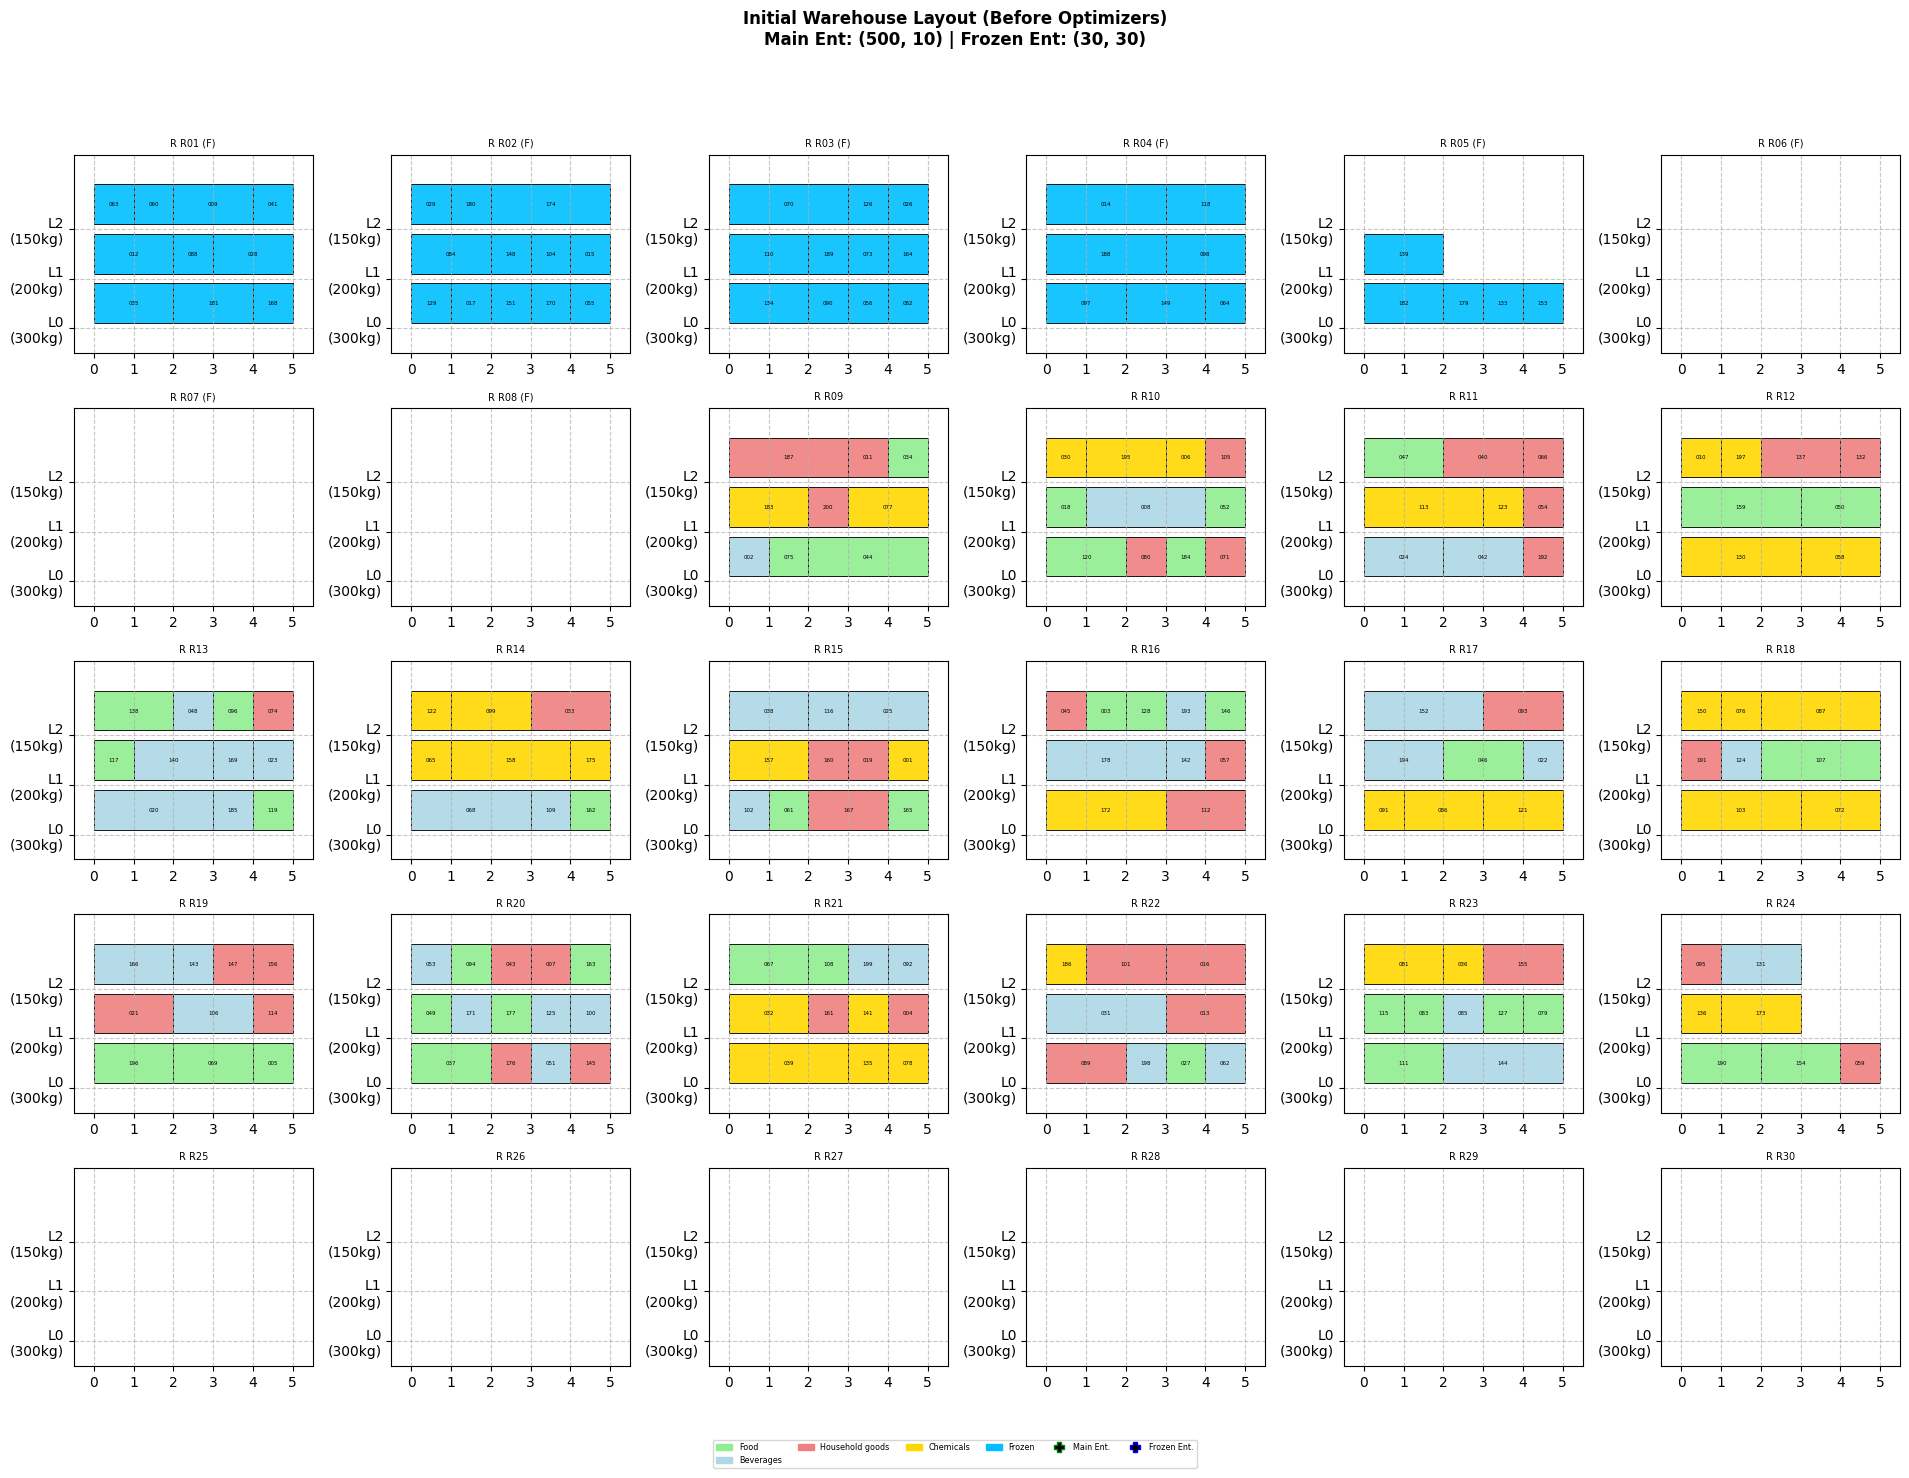

Initial Layout Fitness Score: 51.23

--- Starting GA Optimization ---
Initial Best Layout Fitness (GA): 54.36
  GA Gen 1/500: Best Overall Fit = 54.36 (Pop best: 54.36)
  GA Gen 51/500: Best Overall Fit = 66.08 (Pop best: 66.08)
  GA Gen 101/500: Best Overall Fit = 69.03 (Pop best: 69.03)
  GA Gen 151/500: Best Overall Fit = 72.11 (Pop best: 72.11)
  GA Gen 201/500: Best Overall Fit = 74.36 (Pop best: 74.36)
  GA Gen 251/500: Best Overall Fit = 75.39 (Pop best: 75.39)
  GA Gen 301/500: Best Overall Fit = 76.35 (Pop best: 76.35)
  GA Gen 351/500: Best Overall Fit = 77.52 (Pop best: 77.52)
  GA Gen 401/500: Best Overall Fit = 78.05 (Pop best: 78.05)
  GA Gen 451/500: Best Overall Fit = 78.61 (Pop best: 78.61)
  GA Gen 500/500: Best Overall Fit = 79.36 (Pop best: 79.36)
Finished GA. Final Best Layout Fitness: 79.36

--- Final Optimized Layout (GA) ---


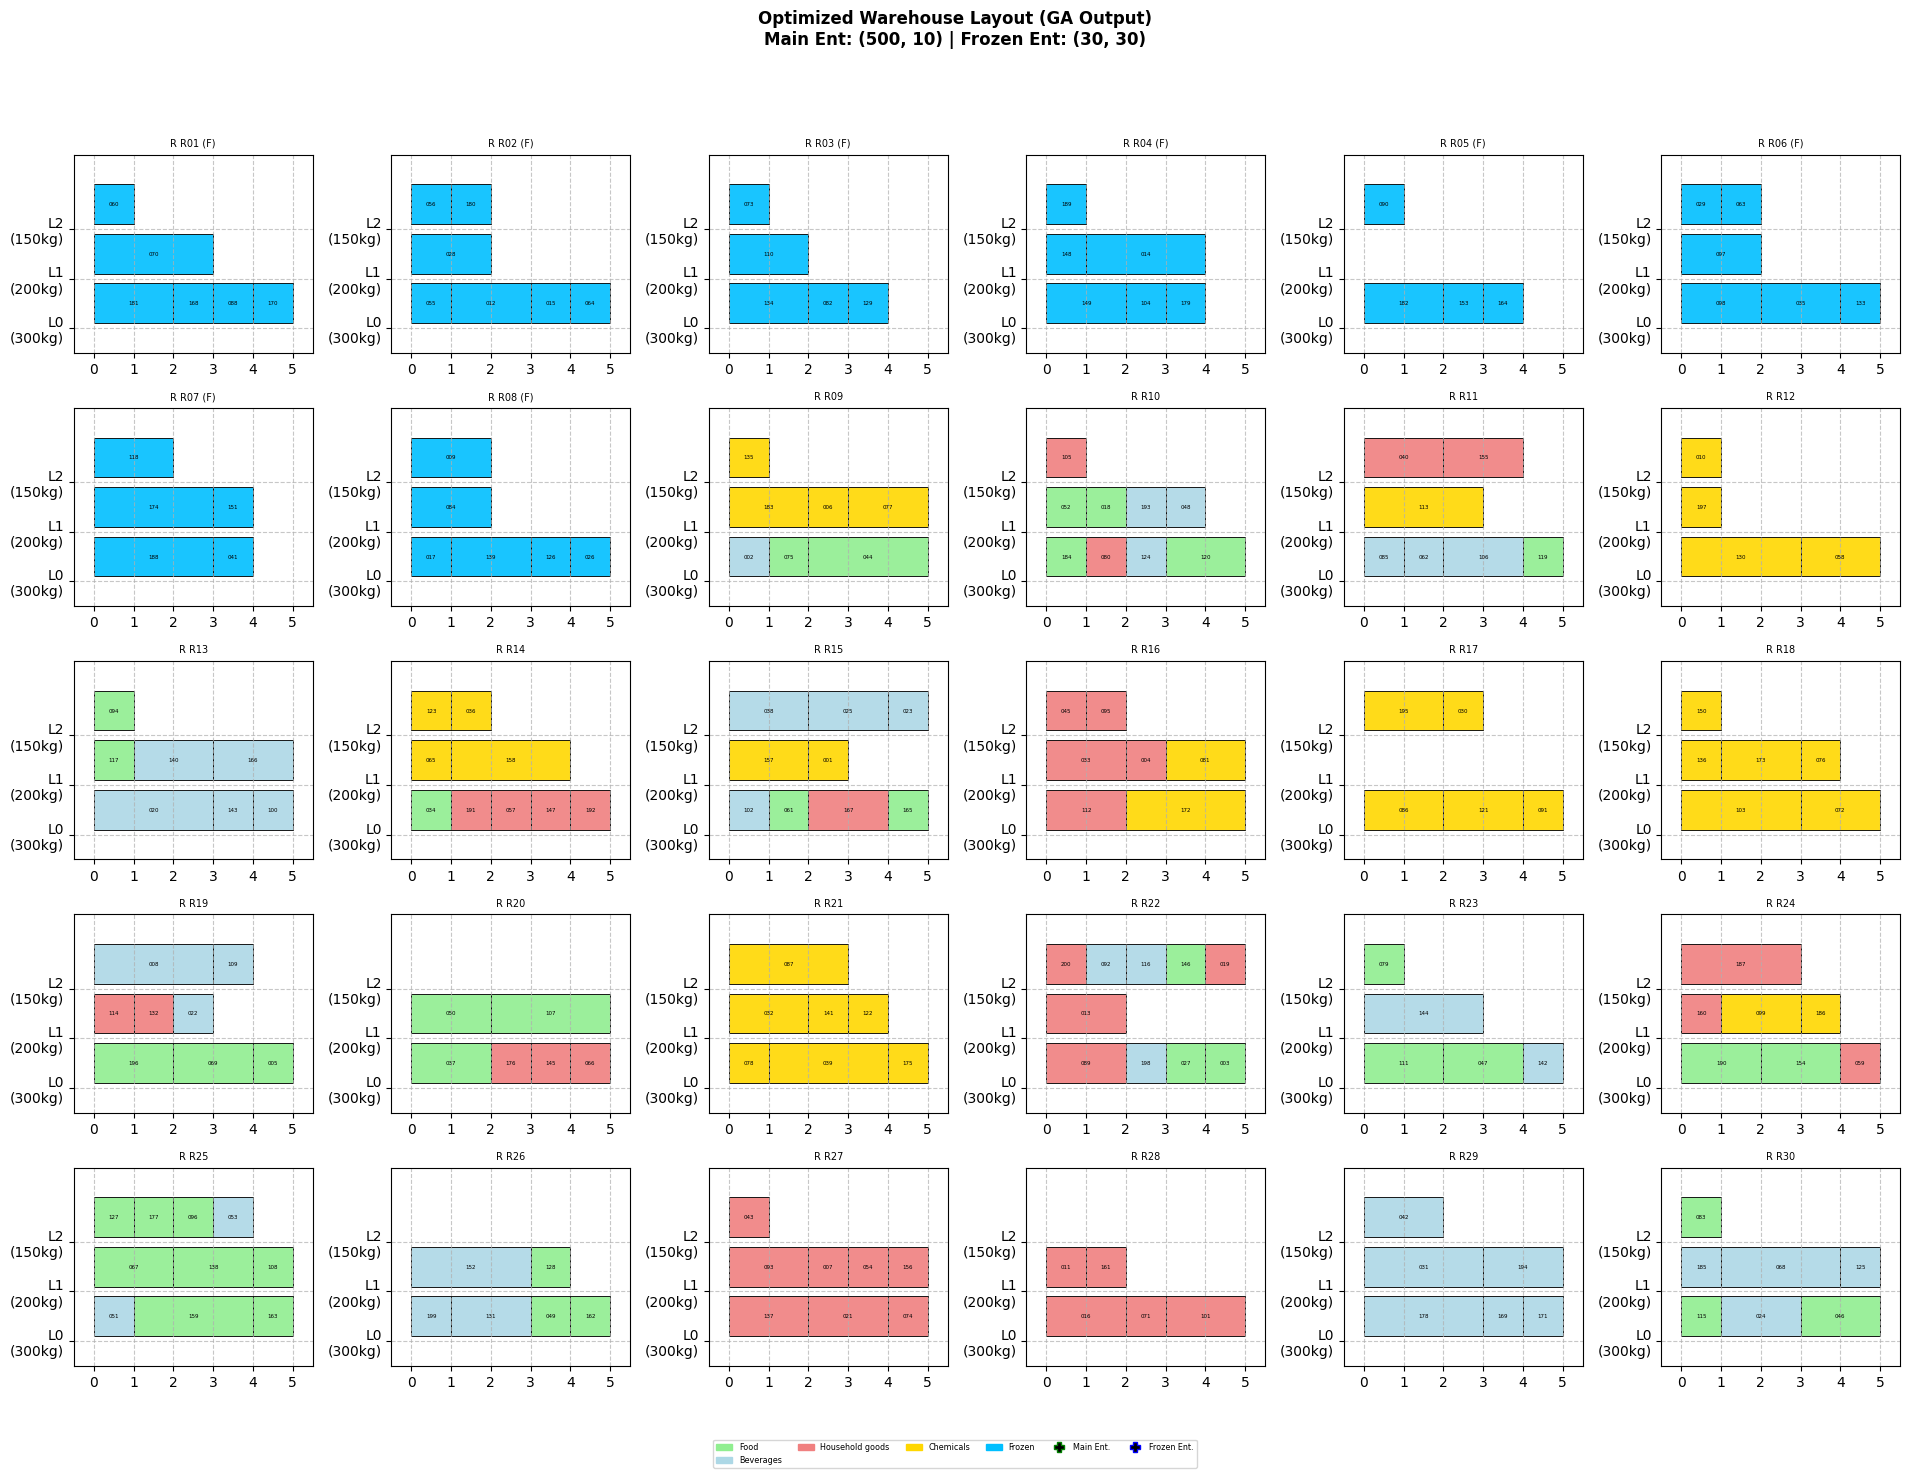

Optimized Layout Fitness Score (GA): 79.36

--- GA Move Instructions ---
  1: Item item003: RR16-L2 -> RR22-L0
  2: Item item004: RR21-L1 -> RR16-L1
  3: Item item006: RR10-L2 -> RR09-L1
  4: Item item007: RR20-L2 -> RR27-L1
  5: Item item008: RR10-L1 -> RR19-L2
  6: Item item009: RR01-L2 -> RR08-L2
  7: Item item011: RR09-L2 -> RR28-L1
  8: Item item012: RR01-L1 -> RR02-L0
  9: Item item014: RR04-L2 -> RR04-L1
  10: Item item015: RR02-L1 -> RR02-L0
  ... and 122 more moves.

--- Starting Local Beam Search Optimization ---
Initial Best Layout Fitness (LBS): 55.12
  LBS Iter 50/500: Best Overall Fit = 68.08 (Beam best: 68.08)
  LBS Iter 100/500: Best Overall Fit = 72.38 (Beam best: 72.38)
  LBS Iter 150/500: Best Overall Fit = 74.39 (Beam best: 74.12)
  LBS Iter 200/500: Best Overall Fit = 76.04 (Beam best: 75.93)
  LBS Iter 250/500: Best Overall Fit = 76.74 (Beam best: 76.58)
  LBS Iter 300/500: Best Overall Fit = 77.30 (Beam best: 77.05)
  LBS Iter 350/500: Best Overall Fit = 78.17 (B

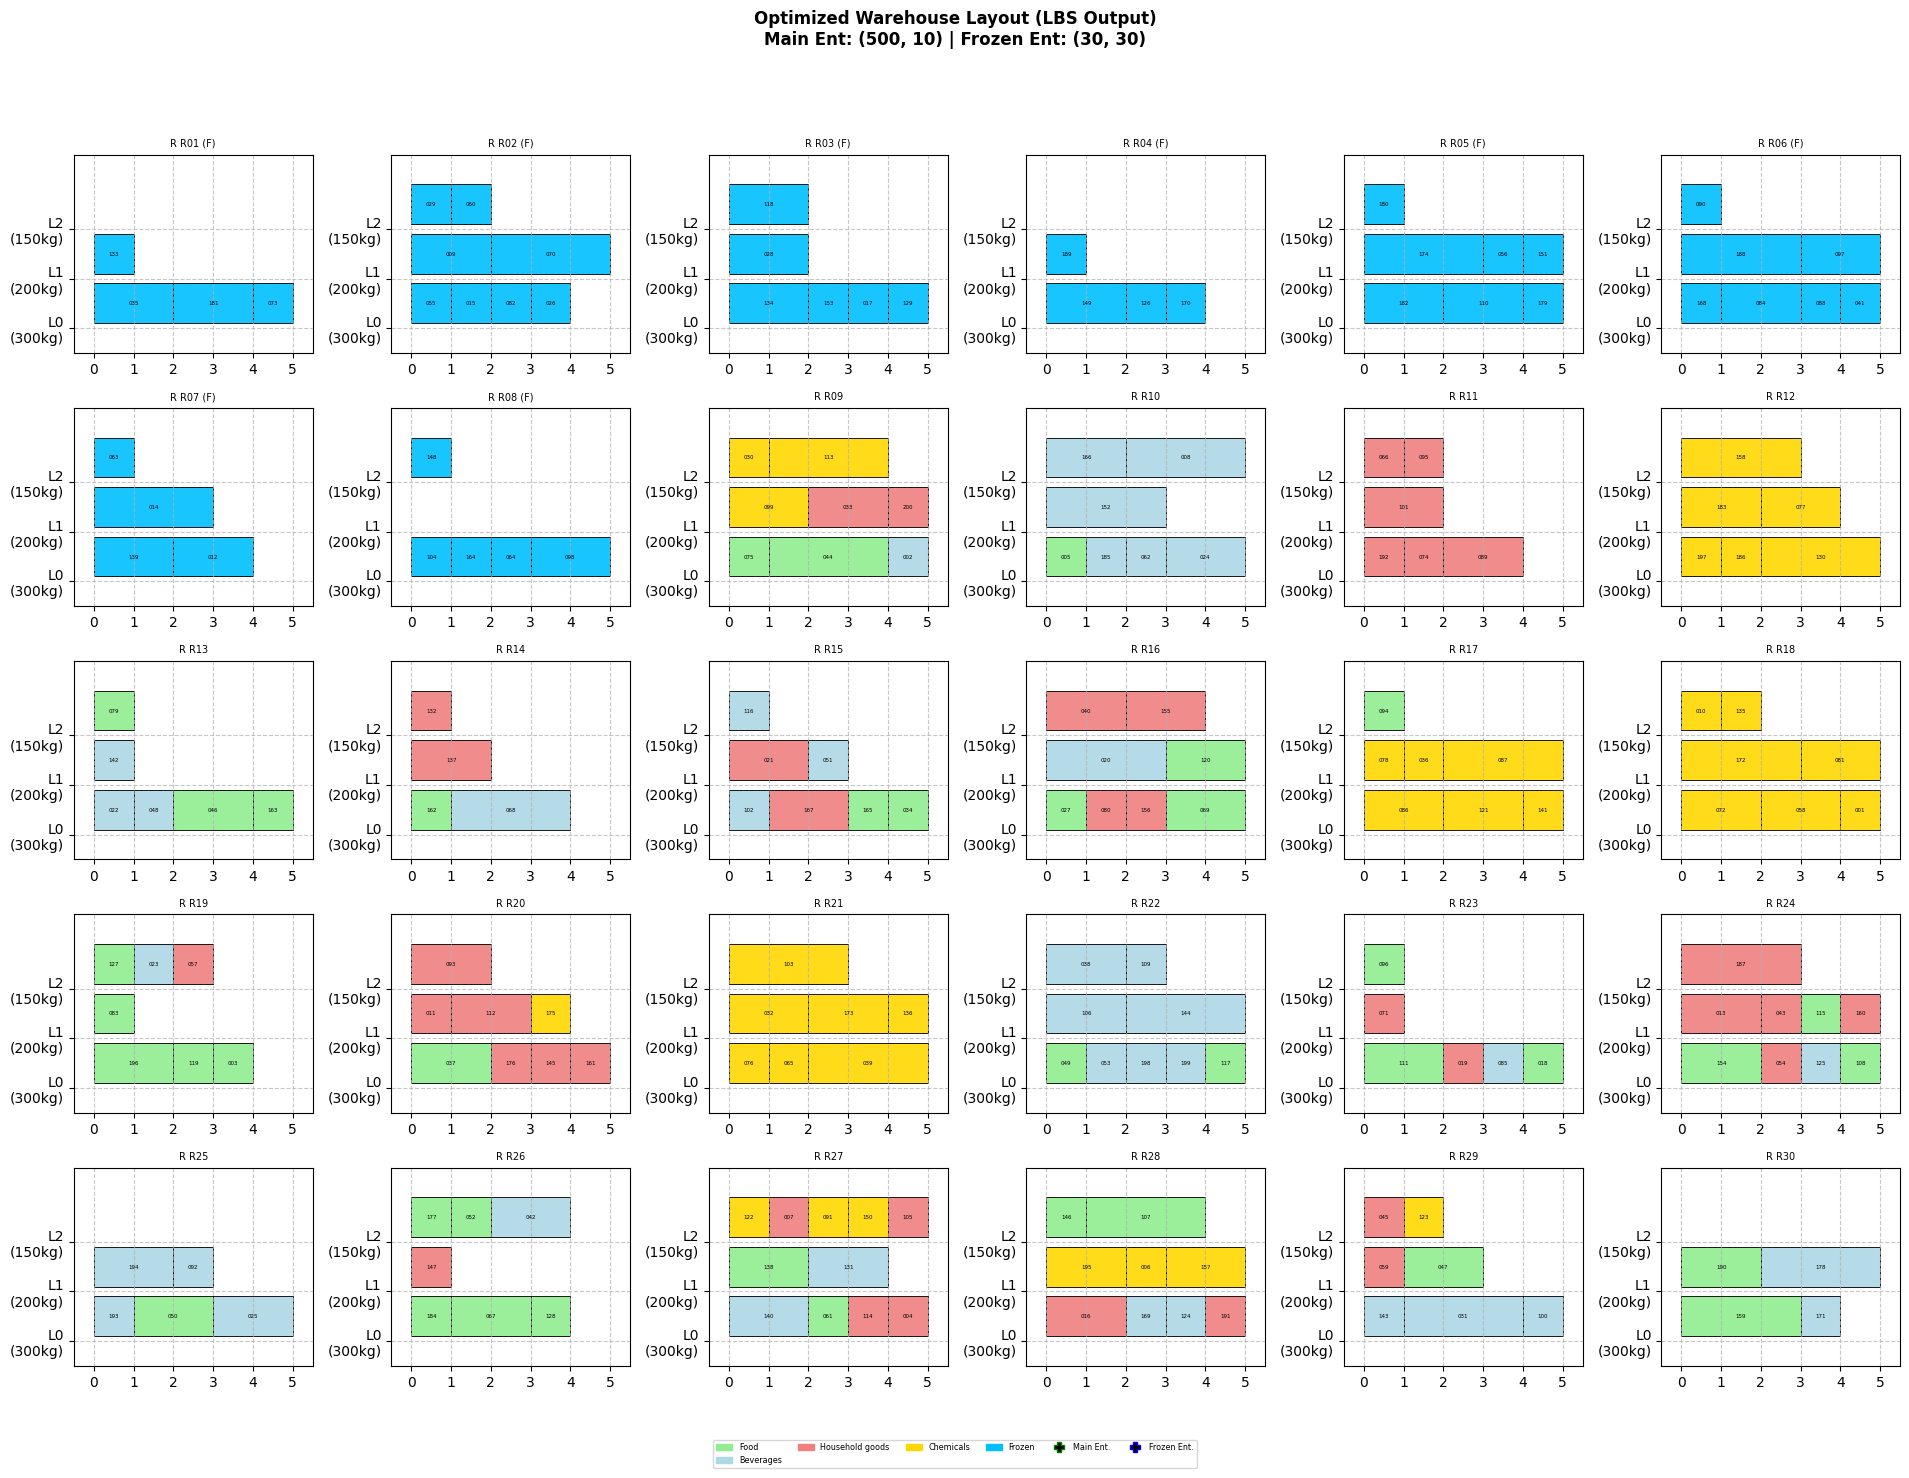

Optimized Layout Fitness Score (LBS): 78.17

--- LBS Move Instructions ---
  1: Item item001: RR15-L1 -> RR18-L0
  2: Item item003: RR16-L2 -> RR19-L0
  3: Item item004: RR21-L1 -> RR27-L0
  4: Item item005: RR19-L0 -> RR10-L0
  5: Item item006: RR10-L2 -> RR28-L1
  6: Item item007: RR20-L2 -> RR27-L2
  7: Item item008: RR10-L1 -> RR10-L2
  8: Item item009: RR01-L2 -> RR02-L1
  9: Item item010: RR12-L2 -> RR18-L2
  10: Item item011: RR09-L2 -> RR20-L1
  ... and 157 more moves.


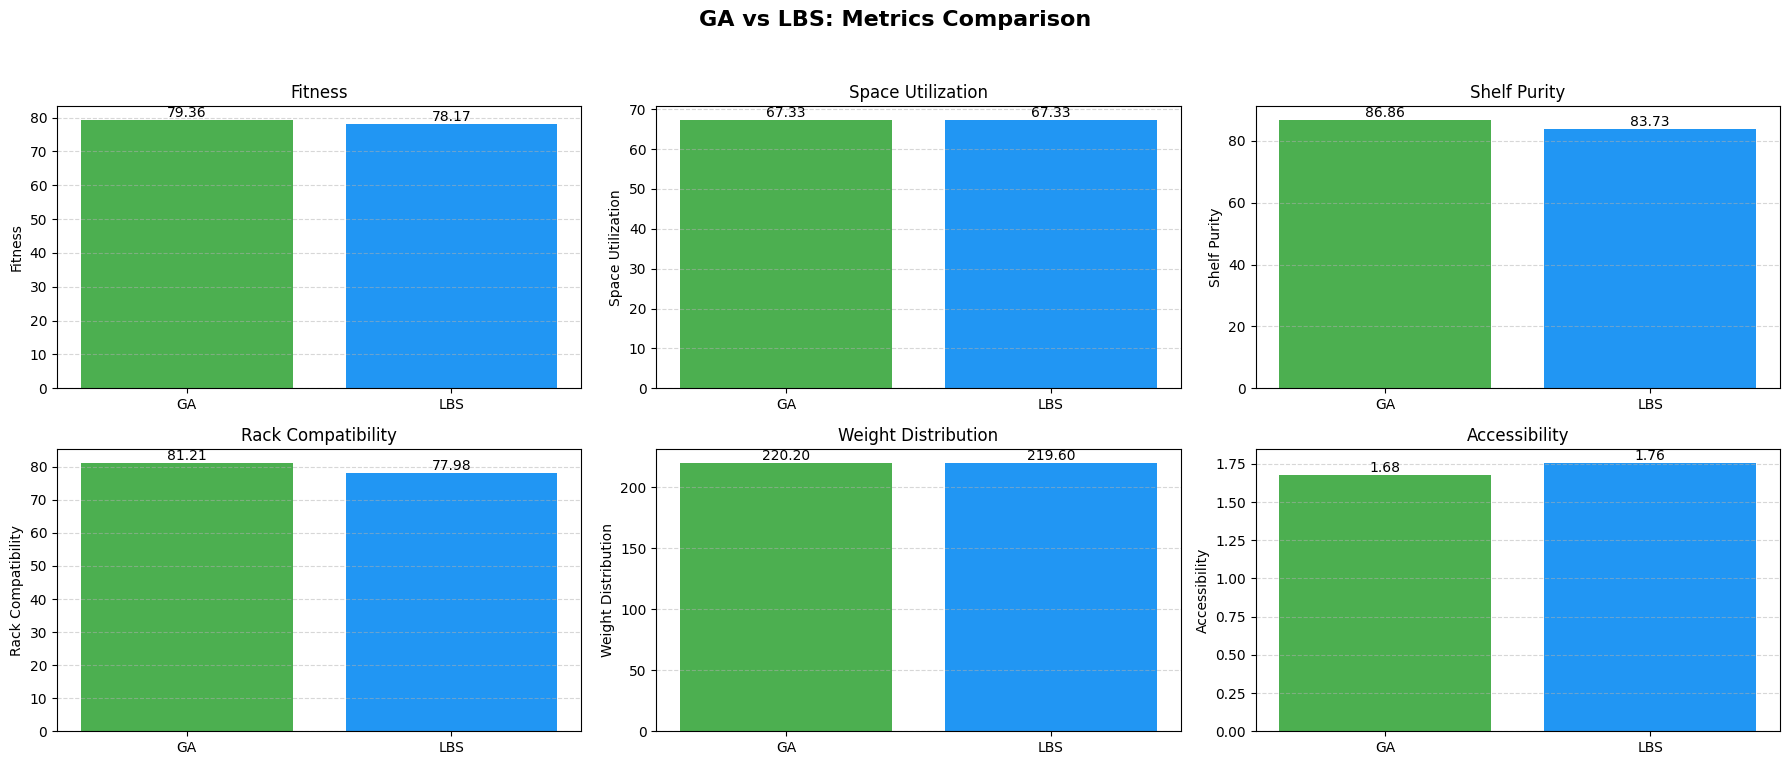

In [22]:
# --- Main Orchestration Logic ---
if __name__ == "__main__":
    load_actual_facts_and_items()
    initial_full_layout = {}
    for rack_id_main, is_frz_main in WAREHOUSE_CONFIG["RACK_FROZEN_STATUS"].items():
        initial_full_layout[rack_id_main] = {'is_frozen': is_frz_main, 'layout': [[] for _ in range(WAREHOUSE_CONFIG["SHELF_LEVELS"])]}

    all_item_ids_for_placement = list(WAREHOUSE_CONFIG["ITEM_DB"].keys())
    random.shuffle(all_item_ids_for_placement)
    placed_item_count_main = 0

    print("--- Generating Initial Warehouse Layout ---")
    dummy_layout_for_validation_ga = {r_id: {'is_frozen': WAREHOUSE_CONFIG["RACK_FROZEN_STATUS"][r_id],
                                              'layout': [[] for _ in range(WAREHOUSE_CONFIG["SHELF_LEVELS"])]}
                                      for r_id in WAREHOUSE_CONFIG["RACK_CENTERS"]}
    # Use GeneticLayoutOptimizer's methods via an instance for validation during initial placement
    # This is okay as these methods are self-contained with config and layout.
    temp_validator_instance = GeneticLayoutOptimizer(dummy_layout_for_validation_ga, WAREHOUSE_CONFIG, 1, 1)

    for item_id_main in all_item_ids_for_placement:
        item_obj_main = WAREHOUSE_CONFIG["ITEM_DB"].get(item_id_main)
        if not item_obj_main: continue
        placed_this_item_main = False
        possible_racks_main = [rid for rid, r_is_frozen in WAREHOUSE_CONFIG["RACK_FROZEN_STATUS"].items()
                               if r_is_frozen == item_obj_main.is_frozen]
        if not possible_racks_main: continue; random.shuffle(possible_racks_main)
        shelf_order_priority = list(range(WAREHOUSE_CONFIG["SHELF_LEVELS"]))
        if item_obj_main.weight > WAREHOUSE_CONFIG["HEAVY_ITEM_THRESHOLD"]: shelf_order_priority.sort()
        else: random.shuffle(shelf_order_priority)
        for rack_id_init_main in possible_racks_main:
            for shelf_level_init_main in shelf_order_priority:
                current_shelf_items = initial_full_layout[rack_id_init_main]['layout'][shelf_level_init_main]
                is_rack_frozen_main = initial_full_layout[rack_id_init_main]['is_frozen']
                if temp_validator_instance._can_place_item_on_shelf(list(current_shelf_items), item_obj_main, shelf_level_init_main, is_rack_frozen_main):
                    initial_full_layout[rack_id_init_main]['layout'][shelf_level_init_main].append(item_id_main)
                    placed_this_item_main = True; placed_item_count_main +=1; break
            if placed_this_item_main: break
        if not placed_this_item_main: print(f"Warning: Could not place item {item_id_main} in initial layout.")
    print(f"Generated initial layout with {placed_item_count_main} / {len(all_item_ids_for_placement)} items placed.")
    visualize_layout(initial_full_layout, WAREHOUSE_CONFIG, title="Initial Warehouse Layout (Before Optimizers)")

    # Calculate initial fitness using one of the optimizer classes (they share the fitness logic structure)
    temp_fitness_eval_instance = GeneticLayoutOptimizer(initial_full_layout, WAREHOUSE_CONFIG, 1, 1) # Or LBS
    initial_fitness_val = temp_fitness_eval_instance._calculate_fitness(initial_full_layout)
    print(f"Initial Layout Fitness Score: {initial_fitness_val:.2f}")

    # --- Configure and Run Genetic Algorithm Optimizer ---
    run_ga = True # Set to False to skip GA
    if run_ga:
        ga_optimizer = GeneticLayoutOptimizer(
            initial_full_layout=initial_full_layout, config=WAREHOUSE_CONFIG,
            generations=500, population_size=30, tournament_size=5,
            crossover_rate=0.85, mutation_rate=0.20, elite_size=3
        )
        print("\n--- Starting GA Optimization ---")
        best_final_layout_ga, best_final_fitness_ga = ga_optimizer.run()
        if best_final_layout_ga and best_final_layout_ga.keys():
            print("\n--- Final Optimized Layout (GA) ---")
            visualize_layout(best_final_layout_ga, WAREHOUSE_CONFIG, title="Optimized Warehouse Layout (GA Output)")
            print(f"Optimized Layout Fitness Score (GA): {best_final_fitness_ga:.2f}")
            move_instructions_ga = generate_move_instructions_simplified(initial_full_layout, best_final_layout_ga)
            print("\n--- GA Move Instructions ---")
            for idx, instr in enumerate(move_instructions_ga[:10]): print(f"  {idx+1}: {instr}") # Print first 10
            if len(move_instructions_ga) > 10: print(f"  ... and {len(move_instructions_ga)-10} more moves.")
        else: print("GA optimization did not produce a valid final layout.")

    # --- Configure and Run Local Beam Search Optimizer ---
    run_lbs = True # Set to False to skip LBS
    if run_lbs:
        lbs_optimizer = LocalBeamSearchOptimizer(
            initial_full_layout=initial_full_layout,
            config=WAREHOUSE_CONFIG,
            beam_width_k=8,         # K: Number of states in the beam
            max_iterations=500,      # Number of iterations
            num_initial_perturbations=10, # Applied to initial_layout to create diverse starting beam states (more changes)
            num_successor_perturbations=2, # Applied to a beam state to create one successor (fewer changes)
            successors_per_state_in_beam=4 # How many successors to generate for each state in the beam
        )
        print("\n--- Starting Local Beam Search Optimization ---")
        best_final_layout_lbs, best_final_fitness_lbs = lbs_optimizer.run()
        if best_final_layout_lbs and best_final_layout_lbs.keys():
            print("\n--- Final Optimized Layout (LBS) ---")
            visualize_layout(best_final_layout_lbs, WAREHOUSE_CONFIG, title="Optimized Warehouse Layout (LBS Output)")
            print(f"Optimized Layout Fitness Score (LBS): {best_final_fitness_lbs:.2f}")
            move_instructions_lbs = generate_move_instructions_simplified(initial_full_layout, best_final_layout_lbs)
            print("\n--- LBS Move Instructions ---")
            for idx, instr in enumerate(move_instructions_lbs[:10]): print(f"  {idx+1}: {instr}") # Print first 10
            if len(move_instructions_lbs) > 10: print(f"  ... and {len(move_instructions_lbs)-10} more moves.")
        else:
            print("LBS optimization did not produce a valid final layout.")

# --- Metrics Comparison Plot (GA vs LBS) ---
if run_ga and run_lbs and best_final_layout_ga and best_final_layout_lbs:
    def extract_metrics(layout, optimizer_class, config):
        # Use the optimizer's fitness calculation to extract all sub-metrics
        # We'll re-use the fitness calculation logic, but extract the sub-metrics
        optimizer = optimizer_class(layout, config, 1, 1)
        # Copy-paste the sub-metric extraction from _calculate_fitness
        penalty = 0.0
        total_slots_used_overall = 0.0
        total_shelf_category_purity_score = 0.0
        total_rack_compatibility_score = 0.0
        total_weight_dist_score = 0.0
        total_accessibility_score = 0.0
        num_racks_in_layout = len(layout)
        num_shelves_with_items = 0
        for rack_id, rack_data in layout.items():
            is_rack_frozen = rack_data['is_frozen']
            rack_center = config["RACK_CENTERS"].get(rack_id, (0,0))
            items_on_this_rack_objs = []
            for shelf_level_idx, shelf_item_ids in enumerate(rack_data['layout']):
                shelf_slots_used = 0.0; shelf_weight = 0.0; shelf_categories_present = set()
                current_shelf_item_objs = []
                for item_id in shelf_item_ids:
                    item_obj = optimizer._get_item_obj(item_id)
                    if item_obj is None:
                        penalty += optimizer.w_hard_penalty * 500
                        continue
                    current_shelf_item_objs.append(item_obj); items_on_this_rack_objs.append(item_obj)
                    shelf_slots_used += item_obj.slots; shelf_weight += item_obj.weight
                    shelf_categories_present.add(item_obj.category)
                    if item_obj.is_frozen != is_rack_frozen: penalty += optimizer.w_hard_penalty
                if shelf_slots_used > config["MAX_SLOTS_PER_SHELF"]: penalty += optimizer.w_hard_penalty * (shelf_slots_used - config["MAX_SLOTS_PER_SHELF"])
                if shelf_weight > config["MAX_WEIGHT_PER_LEVEL"][shelf_level_idx]: penalty += optimizer.w_hard_penalty * (shelf_weight - config["MAX_WEIGHT_PER_LEVEL"][shelf_level_idx]) / 20.0
                shelf_cats_list = list(shelf_categories_present)
                for c1_idx in range(len(shelf_cats_list)):
                    for c2_idx in range(c1_idx + 1, len(shelf_cats_list)):
                        cat1, cat2 = shelf_cats_list[c1_idx], shelf_cats_list[c2_idx]
                        if cat2 in config["CATEGORY_CONFLICTS_ON_SHELF"].get(cat1, []): penalty += optimizer.w_hard_penalty * 0.5
                total_slots_used_overall += shelf_slots_used
                if shelf_categories_present:
                    num_shelves_with_items +=1
                    total_shelf_category_purity_score += (1.0 / len(shelf_categories_present)) if len(shelf_categories_present) > 0 else 1.0
                target_entrance = config["ENTRANCE_COORDS_FROZEN"] if is_rack_frozen else config["ENTRANCE_COORDS_MAIN"]
                dist_to_entrance = euclidean_distance(rack_center, target_entrance); dist_to_entrance = max(dist_to_entrance, 1.0)
                for item_obj in current_shelf_item_objs:
                    if item_obj.weight > config["HEAVY_ITEM_THRESHOLD"]:
                        if shelf_level_idx == 0: total_weight_dist_score += 2.0
                        elif shelf_level_idx == 1: total_weight_dist_score += 0.5
                        else: total_weight_dist_score -= 1.0
                    elif shelf_level_idx == 2: total_weight_dist_score += 0.2
                    total_accessibility_score += (item_obj.frequency / (dist_to_entrance * (shelf_level_idx + 1.0))) * 0.1
            current_rack_compat_score = 0.0; rack_pair_count = 0
            if len(items_on_this_rack_objs) > 1:
                for i_idx in range(len(items_on_this_rack_objs)):
                    for j_idx in range(i_idx + 1, len(items_on_this_rack_objs)):
                        item_i_obj = items_on_this_rack_objs[i_idx]; item_j_obj = items_on_this_rack_objs[j_idx]
                        compat_val = config["COMPATIBILITY_MATRIX"].get(item_i_obj.category, {}).get(item_j_obj.category, 0.0)
                        current_rack_compat_score += compat_val; rack_pair_count +=1
                if rack_pair_count > 0: total_rack_compatibility_score += (current_rack_compat_score / rack_pair_count)
            elif items_on_this_rack_objs: total_rack_compatibility_score += 1.0
        total_possible_slots_overall = len(config["RACK_CENTERS"]) * config["SHELF_LEVELS"] * config["MAX_SLOTS_PER_SHELF"]
        overall_space_utilization = total_slots_used_overall / total_possible_slots_overall if total_possible_slots_overall > 0 else 0.0
        avg_shelf_purity = total_shelf_category_purity_score / num_shelves_with_items if num_shelves_with_items > 0 else (1.0 if total_slots_used_overall == 0 else 0.0)
        avg_rack_compatibility = total_rack_compatibility_score / num_racks_in_layout if num_racks_in_layout > 0 else (1.0 if total_slots_used_overall == 0 else 0.0)
        return {
            'Fitness': optimizer._calculate_fitness(layout),
            'Space Utilization': overall_space_utilization * 100.0,
            'Shelf Purity': avg_shelf_purity * 100.0,
            'Rack Compatibility': avg_rack_compatibility * 100.0,
            'Weight Distribution': total_weight_dist_score,
            'Accessibility': total_accessibility_score
        }

    ga_metrics = extract_metrics(best_final_layout_ga, GeneticLayoutOptimizer, WAREHOUSE_CONFIG)
    lbs_metrics = extract_metrics(best_final_layout_lbs, LocalBeamSearchOptimizer, WAREHOUSE_CONFIG)

    metrics_names = list(ga_metrics.keys())
    ga_values = [ga_metrics[m] for m in metrics_names]
    lbs_values = [lbs_metrics[m] for m in metrics_names]

    fig, axes = plt.subplots(2, 3, figsize=(18, 8))
    fig.suptitle("GA vs LBS: Metrics Comparison", fontsize=16, fontweight='bold')
    algo_names = ['GA', 'LBS']
    bar_colors = ['#4CAF50', '#2196F3']

    for idx, metric in enumerate(metrics_names):
        ax = axes[idx//3, idx%3]
        ax.bar(algo_names, [ga_values[idx], lbs_values[idx]], color=bar_colors)
        ax.set_title(metric)
        ax.set_ylabel(metric)
        for i, v in enumerate([ga_values[idx], lbs_values[idx]]):
            ax.text(i, v, f"{v:.2f}", ha='center', va='bottom', fontsize=10)
        ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()